This code is my assignment 4 for my machine learning module at UCL 2017/18. For this assignment I received 100% mark.

# Training a Neural Network (1.0 points)

In this assignment, your task is to train a Neural Network or Multilayered Perceptron (MLP) classifier on synthetic data. 



#### Imports

In [19]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from construct_data import construct_data
from gradientChecking import checkNNGradients,compute_numerical_gradient 
from numpy.random import RandomState
from numpy import unravel_index

#### Data Generation - Visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


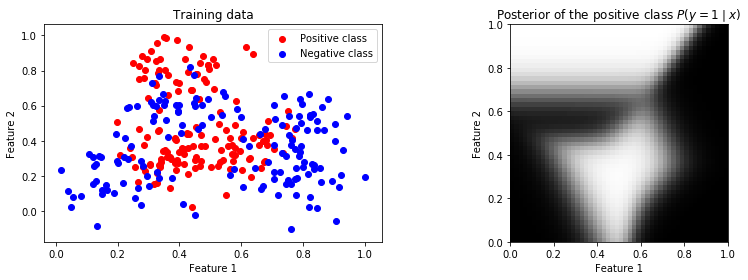

In [20]:
prng=RandomState(1)


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

features, labels, posterior = construct_data(300, 'train', 'nonlinear' , plusminus=True)

# Extract features for both classes
features_pos = features[labels == 1]
features_neg = features[labels != 1]

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")

ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.show()


#negative label values transformed from -1 to 0
for i in range(labels.shape[0]):
    if labels[i]==-1:
        labels[i]=0

# creating alternative input       
data=[] 
for x,y in zip(features,labels): # creating alternative input
    x=x[:,np.newaxis]
    #v.append(np.array([x,y]))
    data.append(np.array([x,y]))
    

## Analytical Derivative of a Function 
Here we present an example of how to compute the gradient of a function. Lets consider the function $f(x)=x^2$. Analytically we know that $f'(x)=2 x$. Thus for some x we can analytically caclulate the derivative of x. The following python functions compute $f$ and $f'$. 

In [21]:
def square(x):
    f=x**2
    return f
def derivative_square(x):
    f_dot=2*x
    return f_dot

We can visualize the function and its derivative using the following commands  

Text(0,0.5,'f')

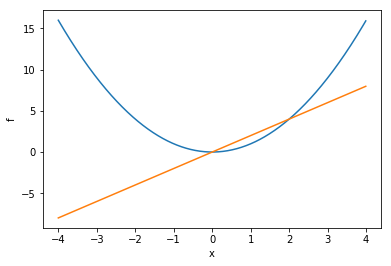

In [22]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
x= np.arange(-4,4,0.01) #interval in which we plot the functions
f=square(x)
ax.plot(x,f)
f_dot=derivative_square(x)
ax.plot(x,f_dot)
plt.xlabel('x')
plt.ylabel('f')

<a id='non-linear activation functions'></a>

# Question 1

## Non-linear activation functions 
Fill in the functions that implement the non-linear functions which are used to produve the activations of the neurons of a neural network. Remember that for if $\sigma(x)$ is the sigmoid function, its derivative is $\sigma'(x)=\sigma(x)*(1-\sigma(x))$. Finally if $relu(x)=max(0,x)$ then $relu'(x>0)= 1$ and $relu'(x<=0)=0$.
##### DO NOT CHANGE THE NAMES OF THE FUNCTIONS AND THE ARGUMENTS.



In [23]:
def sigmoid(z):
    g = 1/(1+np.exp(-z))
    return g

def sigmoid_gradient(z): 
    g = sigmoid(z)*(1-sigmoid(z))
    return g

def relu(x):
    g = np.maximum(x,0)
    return g

def relu_gradient(x):
    g = np.where(x>0,1,0)
    return g


##### Visualize the functions and their gradients by plotting their output in the [-6,6] interval:

In [1]:
x = np.arange(-6,6,0.001)
# Plots the cost and accuracy evolution during training 
fig = plt.figure(figsize=plt.figaspect(0.2))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Sigmoid and Gradient of Sigmoid")
ax1.plot(x,sigmoid(x))
ax1.plot(x,sigmoid_gradient(x))
plt.xlabel('x')
plt.ylabel('g')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("ReLU and Gradient of ReLU")
ax2.plot(x,relu(x))
ax2.plot(x,relu_gradient(x))
plt.xlabel('x')
plt.ylabel('g')

NameError: name 'np' is not defined

# Question 2
<a id='the neural network'></a>
## The Neural Network 
In this assignement in order to define, train and utilize a neural network we are going to first use the implementation provided below. Every operation related to the network is defined as a __method__ (ex. def feedforward , def backpropagation, etc) of the class __Neural_Network__. 

In [26]:
class Neural_Network(object):
    def __init__(self, nnodes,activation_functions='sigmoid'):
        # nnodes: number of hidden units per layer  - e.g. [2,5,10] indicates a three-layer network with the respective number of nodes
        self.num_layers = len(nnodes)
        
        # weights, biases: list of the numpy arrays containing model parameters for linear layers
        # sampled originally from a gaussian distribution
        self.sizes = nnodes
        prng=RandomState(2)
        self.biases = [prng.randn(y, 1) for y in nnodes[1:]]
        self.weights = [prng.randn(y, x) for x, y in zip(nnodes[:-1], nnodes[1:])]    
        
        # non-linearity, specified when the network is initialized 
        self.activation_functions=activation_functions
        self.costs=[]  # stores the costs during training
        self.accuracies=[] # stores the accuracies during training 
          
    def feedforward(self, inputs):
        #Computes the output of the network if a is the input 
        # In our case inputs.shape = (2,1), namely the input is a 2-dimensional vector
        activations = []
        activations.append(inputs) # non linear outputs appended to this list 
        
        zs= [] # linear outputs appended to this list
        # loop over all hidden layers (not the output layer, which is handled after the for loop)
        
        for l in range(len(self.weights)-1):
            b = self.biases[l]
            w = self.weights[l]
            
            # linear output of layer
            z = w @ inputs + b

            if self.activation_functions=='sigmoid':
                # sigmoid activation
                activation = sigmoid(z)

            elif self.activation_functions=='relu':   
                # relu activation
                activation = relu(z)
            
            # save z values for backprop 
            zs.append(z) 
            # save activations for backprop
            activations.append(activation)
            # the input at the next layer is the activation of the previous layer
            inputs=activation  
            
        # compute the output layer's linear and non-linear outputs
        w=self.weights[-1] # the final layer of weights
        b=self.biases[-1] # the final layer of biases
        z = w @ inputs + b # linear output of final layer
        
        activation = sigmoid(z) # final layer is sigmoid to reduce output domain
        
        activations.append(activation)
        
        zs.append(z)
        
        return activation,zs,activations
    
    
    def cost_function(self,X):
        # computes the cross entropy cost for a single example X=(x,y), where x is input and y is desired label
        cost = 0;
        for n in range(len(X)):
            x=X[n][0]
            y=X[n][1] 
            posterior,dum1,dum2=self.feedforward(x) # (2,1)
            sample_cost  = -int(y==0) * np.log(posterior[0]) - int(1-y==0) * np.log(1-posterior[0]) 
            sample_cost += -int(y==1) * np.log(posterior[1]) - int(1-y==1) * np.log(1-posterior[1]) 
            cost = cost + sample_cost
        return cost 

    def Gradient_Descent(self, training_data, epochs,lr,stop,test_data=None):
        # training_data is a list of tuples ([x1,x2],y) where y is the class and [x1,x2] is numpy array
        # lr is the learning_rate, it is scalar
        # epochs is a scalar value for the number of times the network is going to update its parameters        
        for j in range(epochs):
            self.update_params(training_data,lr) 
            cost =self.cost_function(training_data)
            self.costs.append(cost/len(training_data))
            if test_data:
                if test_data: n_test = len(test_data)
                correct = self.evaluate(test_data)
                print ("Epoch {0}: {1} / {2} Cost: {3}".format(j, correct, n_test,cost/len(training_data)))
                self.accuracies.append(correct/n_test)
                if correct > stop: return
            else:
                print ("Epoch {0} complete".format(j))

    def update_params(self, X, lr):
        # X is all the training data
        # X contains pairs (x,y) where x is the feature vector and y its class label
        N= len(X)
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        #Gradient Descent parameter updates
        for x, y in X:
            delta_grad_b, delta_grad_w = self.backprop(x, y) # take an example backpropagate to find the gradients
            grad_b = [nb+dnb for nb, dnb in zip(grad_b, delta_grad_b)] # accumulate gradients for biases
            grad_w = [nw+dnw for nw, dnw in zip(grad_w, delta_grad_w)] # accumulate gradients for weights
        
        # Update the weights and biases using the gradient of the cost computed using the whole training_dataset
        # divide by N to scale the overall gradient by the number of training examples
        self.weights = [w-lr*nw/N for w, nw in zip(self.weights, grad_w)]  
        self.biases =  [b-lr*nb/N for b, nb in zip(self.biases,  grad_b)]

        
        
    def backprop(self, x, y):
        #Returns (grad_b, grad_w) representing the
        #gradients for the cost function  wrt b and w . 
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        ######### Forward pass of the backprop #########
        
        dummy,zs,activations= self.feedforward(x) #dummy is not used below 
        
        # one hot encoding of the desired label
        # so if for example y=1 then the one-hot encoding of y is y =[0 , 1]
        
        if y==0:
            y=np.array([[1],[0]])
        else:
            y=np.array([[0],[1]])
        
        ######## Backward pass of the backprop ##########
        
        # Grad at the ouput layer 
        z=zs[-1]
        delta = (activations[-1]- y)
        # grad wrt the parameters of the output layer

        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].T)
        
        # By uncommenting the following lines the you will be printing the shapes of each variable used
        # to compute the gradient at the output layer
        '''
        print('---- shapes')
        print('output-layer')
        print('activation',activations[-1].shape) 
        print('z', z.shape)
        print('delta',delta.shape)
        print('grad_b ',grad_b[-1].shape,' grad_w ',grad_w[-1].shape,'delta',delta.shape) 
        '''
        
        
        # Grad at the rest of the layers

        L = self.num_layers #  input layer + hidden layers + ouput layers
        # zs has L-1 elements , activations has L elements , self.weights has L-1 elements
        # start from 2nd-to-last layer (hence the L-2 index) and move backwards 
        for l in range(L-2, 0,-1):   
            # linear output of the l-th layer
            z = zs[l-1]        
            
            # input to the l-th layer
            # which is the activation of the (l-1)-th layer
            activation=activations[l-1] 
            
            # take the weights that map the output of the 
            # l-th layer to the input of the (l+1)-th layer
            weights=self.weights[l] 
            
            # compute the value of the gradient of the non-linearity of the l-th layer 
            # given the z of the l-th layer 
            sg = relu_gradient(z)
            
                
            # backpropagate delta from (l+1)-th layer to l-th layer
            prod  = np.dot(weights.T, delta)    
            delta = prod * sg
            
            # gradients of the parameters of the l-th layer
            grad_b[l-1] = delta 
            grad_w[l-1] = np.dot(delta, activation.T) 
            
            # By uncommenting the following lines the 
            # function will be printing the shapes of each variable 
            
            '''
            print('---- shapes')
            print('layer:',l)  
            print('activation ',activation.shape)
            print('z ', z.shape)
            print('w ',weights.shape)       
            print('prod ',prod.shape,'sg',sg.shape)
            print('delta ',delta.shape)
            print('grad_b ',grad_b[-l].shape,' grad_w ',grad_w[-l].shape) 
            '''
        return (grad_b, grad_w)
        

    def evaluate(self, data):
        correct = 0
        for index in range(len(data)):
            feature = data[index][0]
            label   =  data[index][1]
            output,dum1,dum2 = self.feedforward(feature)
            correct = correct  + int(label == np.argmax(output))
        return correct



<a id='checking'></a>
#### Gradient checking:
We are going to use $gradient$ $checking$ to check if the numerical (using approximations) and analytical (computed by our backprop implementation) gradient computations match. To test that we are going to check the gradients computed for a small neural network. 

Suppose we have a neural network with 2 dimensional inputs , 2 hidden layers of 4 neurons each with sigmoid non-linearities and an output layer of 2 neurons with sigmoid non-linearity. This network is initialized as shown by the code in the next cell.

In [27]:
nnodes2=[2,4,2]
activation_functions_checking='sigmoid' 
nnet_checking = Neural_Network(nnodes2,activation_functions_checking)

We are going to use a few training examples to check if the analytical and numerical gradients match.

In [28]:
m=50 # using 50 examples to do gradient checking 
train_data = data[1:m] 
checkNNGradients(nnet_checking,train_data)                 # compute_numerical_gradient 

Relative difference 1.16238292082e-07 for layer 0 parameters
Analytical and numerical gradients match
as relative distance is less that 1e-5
Relative difference 2.55412964054e-08 for layer 1 parameters
Analytical and numerical gradients match
as relative distance is less that 1e-5


<a id='Define Network'></a>
#### Define a Network 
To initialize a Neural Network we must provide two arguments: $nnodes$ and activation_functions. $nnodes$ is a list. Each 
element of $nnodes$ defines the number of neurons of each layer of the network. By convention the first element of $nnodes$
defines the input layer of the network that is not associated with any weights and biases. The rest of the elements of 
$nnodes$ are used to initialize the weigths and biases of the hidden layers and the output layer. The activation_functions 
argument is a string that defines the type of non-linear function to be used for each neuron of the hidden layer. Our 
implementation supports ReLUs and sigmoids as activation functions. The output layer is set to always be a sigmoid function. 



#### Execute the following three cells to 1) define a network 2) train it 3) visualize the estimated posterior 

In [29]:
nnodes=[2, 10, 10, 2]
activation_functions='sigmoid' # use 'sigmoid' or 'relu'
nnet = Neural_Network(nnodes,activation_functions)
#print(nnet.weights) # uncomment to see weights after they have been initialized

In [30]:
learning_rate=2 # 
epochs = 15000  ## usually has already converged around that number
stop = 260 #  number of correctly classified performance to which we wish to stop training / set it to a number close to 300
train_data = data
test_data = data #evaluate the performance on the train data
nnet.Gradient_Descent(train_data,epochs,learning_rate,stop,test_data)

Epoch 0: 150 / 300 Cost: [ 2.16889996]
Epoch 1: 150 / 300 Cost: [ 2.8487349]
Epoch 2: 150 / 300 Cost: [ 2.48714604]
Epoch 3: 150 / 300 Cost: [ 2.12390887]
Epoch 4: 150 / 300 Cost: [ 2.02194588]
Epoch 5: 150 / 300 Cost: [ 1.6746181]
Epoch 6: 150 / 300 Cost: [ 1.69613043]
Epoch 7: 150 / 300 Cost: [ 1.78170732]
Epoch 8: 150 / 300 Cost: [ 2.16873431]
Epoch 9: 199 / 300 Cost: [ 1.84604524]
Epoch 10: 192 / 300 Cost: [ 1.87002109]
Epoch 11: 183 / 300 Cost: [ 1.57654504]
Epoch 12: 194 / 300 Cost: [ 1.53813784]
Epoch 13: 177 / 300 Cost: [ 1.4626254]
Epoch 14: 186 / 300 Cost: [ 1.43928743]
Epoch 15: 177 / 300 Cost: [ 1.41144273]
Epoch 16: 184 / 300 Cost: [ 1.39942273]
Epoch 17: 180 / 300 Cost: [ 1.3874795]
Epoch 18: 182 / 300 Cost: [ 1.38104454]
Epoch 19: 179 / 300 Cost: [ 1.37507961]
Epoch 20: 181 / 300 Cost: [ 1.37120408]
Epoch 21: 179 / 300 Cost: [ 1.36763733]
Epoch 22: 178 / 300 Cost: [ 1.36491257]
Epoch 23: 178 / 300 Cost: [ 1.36234613]
Epoch 24: 178 / 300 Cost: [ 1.36013383]
Epoch 25: 177 

Epoch 207: 169 / 300 Cost: [ 1.25261115]
Epoch 208: 192 / 300 Cost: [ 1.25218002]
Epoch 209: 170 / 300 Cost: [ 1.25134527]
Epoch 210: 192 / 300 Cost: [ 1.25090306]
Epoch 211: 169 / 300 Cost: [ 1.25005847]
Epoch 212: 192 / 300 Cost: [ 1.24960452]
Epoch 213: 170 / 300 Cost: [ 1.24874999]
Epoch 214: 192 / 300 Cost: [ 1.24828395]
Epoch 215: 171 / 300 Cost: [ 1.24741966]
Epoch 216: 192 / 300 Cost: [ 1.24694144]
Epoch 217: 173 / 300 Cost: [ 1.24606781]
Epoch 218: 192 / 300 Cost: [ 1.24557759]
Epoch 219: 174 / 300 Cost: [ 1.24469517]
Epoch 220: 192 / 300 Cost: [ 1.24419337]
Epoch 221: 174 / 300 Cost: [ 1.24330283]
Epoch 222: 193 / 300 Cost: [ 1.24279006]
Epoch 223: 174 / 300 Cost: [ 1.24189214]
Epoch 224: 194 / 300 Cost: [ 1.2413692]
Epoch 225: 174 / 300 Cost: [ 1.24046463]
Epoch 226: 194 / 300 Cost: [ 1.23993249]
Epoch 227: 174 / 300 Cost: [ 1.23902201]
Epoch 228: 194 / 300 Cost: [ 1.23848178]
Epoch 229: 174 / 300 Cost: [ 1.23756608]
Epoch 230: 194 / 300 Cost: [ 1.23701902]
Epoch 231: 173 / 

Epoch 410: 231 / 300 Cost: [ 1.03209581]
Epoch 411: 220 / 300 Cost: [ 1.0295445]
Epoch 412: 231 / 300 Cost: [ 1.03054376]
Epoch 413: 220 / 300 Cost: [ 1.02803347]
Epoch 414: 229 / 300 Cost: [ 1.02902517]
Epoch 415: 220 / 300 Cost: [ 1.02656141]
Epoch 416: 230 / 300 Cost: [ 1.02753851]
Epoch 417: 220 / 300 Cost: [ 1.02512693]
Epoch 418: 229 / 300 Cost: [ 1.02608272]
Epoch 419: 220 / 300 Cost: [ 1.02372901]
Epoch 420: 229 / 300 Cost: [ 1.02465715]
Epoch 421: 219 / 300 Cost: [ 1.02236697]
Epoch 422: 229 / 300 Cost: [ 1.02326157]
Epoch 423: 219 / 300 Cost: [ 1.02104042]
Epoch 424: 229 / 300 Cost: [ 1.02189605]
Epoch 425: 219 / 300 Cost: [ 1.0197493]
Epoch 426: 230 / 300 Cost: [ 1.02056099]
Epoch 427: 219 / 300 Cost: [ 1.01849375]
Epoch 428: 230 / 300 Cost: [ 1.01925703]
Epoch 429: 219 / 300 Cost: [ 1.01727419]
Epoch 430: 230 / 300 Cost: [ 1.01798505]
Epoch 431: 219 / 300 Cost: [ 1.01609124]
Epoch 432: 230 / 300 Cost: [ 1.01674611]
Epoch 433: 220 / 300 Cost: [ 1.01494573]
Epoch 434: 230 / 3

Epoch 613: 229 / 300 Cost: [ 0.98092747]
Epoch 614: 232 / 300 Cost: [ 0.98077014]
Epoch 615: 229 / 300 Cost: [ 0.98062346]
Epoch 616: 232 / 300 Cost: [ 0.98047292]
Epoch 617: 228 / 300 Cost: [ 0.98032384]
Epoch 618: 232 / 300 Cost: [ 0.98017991]
Epoch 619: 228 / 300 Cost: [ 0.9800285]
Epoch 620: 232 / 300 Cost: [ 0.97989101]
Epoch 621: 228 / 300 Cost: [ 0.97973735]
Epoch 622: 232 / 300 Cost: [ 0.9796061]
Epoch 623: 228 / 300 Cost: [ 0.97945025]
Epoch 624: 232 / 300 Cost: [ 0.97932507]
Epoch 625: 228 / 300 Cost: [ 0.97916706]
Epoch 626: 232 / 300 Cost: [ 0.97904776]
Epoch 627: 228 / 300 Cost: [ 0.97888766]
Epoch 628: 232 / 300 Cost: [ 0.97877406]
Epoch 629: 227 / 300 Cost: [ 0.97861189]
Epoch 630: 232 / 300 Cost: [ 0.97850381]
Epoch 631: 227 / 300 Cost: [ 0.97833961]
Epoch 632: 232 / 300 Cost: [ 0.97823688]
Epoch 633: 227 / 300 Cost: [ 0.97807068]
Epoch 634: 232 / 300 Cost: [ 0.97797313]
Epoch 635: 227 / 300 Cost: [ 0.97780496]
Epoch 636: 232 / 300 Cost: [ 0.97771241]
Epoch 637: 227 / 3

Epoch 816: 230 / 300 Cost: [ 0.96146354]
Epoch 817: 230 / 300 Cost: [ 0.96126424]
Epoch 818: 230 / 300 Cost: [ 0.96134163]
Epoch 819: 230 / 300 Cost: [ 0.96114266]
Epoch 820: 230 / 300 Cost: [ 0.96122064]
Epoch 821: 230 / 300 Cost: [ 0.961022]
Epoch 822: 230 / 300 Cost: [ 0.96110058]
Epoch 823: 230 / 300 Cost: [ 0.96090226]
Epoch 824: 230 / 300 Cost: [ 0.96098143]
Epoch 825: 230 / 300 Cost: [ 0.96078343]
Epoch 826: 230 / 300 Cost: [ 0.96086317]
Epoch 827: 230 / 300 Cost: [ 0.96066549]
Epoch 828: 230 / 300 Cost: [ 0.96074581]
Epoch 829: 230 / 300 Cost: [ 0.96054844]
Epoch 830: 230 / 300 Cost: [ 0.96062933]
Epoch 831: 230 / 300 Cost: [ 0.96043228]
Epoch 832: 230 / 300 Cost: [ 0.96051373]
Epoch 833: 230 / 300 Cost: [ 0.96031698]
Epoch 834: 230 / 300 Cost: [ 0.96039899]
Epoch 835: 230 / 300 Cost: [ 0.96020255]
Epoch 836: 230 / 300 Cost: [ 0.96028511]
Epoch 837: 230 / 300 Cost: [ 0.96008898]
Epoch 838: 230 / 300 Cost: [ 0.96017208]
Epoch 839: 230 / 300 Cost: [ 0.95997625]
Epoch 840: 231 / 3

Epoch 1019: 228 / 300 Cost: [ 0.95245055]
Epoch 1020: 232 / 300 Cost: [ 0.95260081]
Epoch 1021: 228 / 300 Cost: [ 0.95238946]
Epoch 1022: 232 / 300 Cost: [ 0.9525411]
Epoch 1023: 228 / 300 Cost: [ 0.95232883]
Epoch 1024: 232 / 300 Cost: [ 0.95248188]
Epoch 1025: 228 / 300 Cost: [ 0.95226869]
Epoch 1026: 232 / 300 Cost: [ 0.95242317]
Epoch 1027: 228 / 300 Cost: [ 0.95220904]
Epoch 1028: 232 / 300 Cost: [ 0.95236499]
Epoch 1029: 228 / 300 Cost: [ 0.95214989]
Epoch 1030: 232 / 300 Cost: [ 0.95230734]
Epoch 1031: 228 / 300 Cost: [ 0.95209125]
Epoch 1032: 232 / 300 Cost: [ 0.95225024]
Epoch 1033: 228 / 300 Cost: [ 0.95203313]
Epoch 1034: 232 / 300 Cost: [ 0.9521937]
Epoch 1035: 228 / 300 Cost: [ 0.95197556]
Epoch 1036: 231 / 300 Cost: [ 0.95213774]
Epoch 1037: 228 / 300 Cost: [ 0.95191854]
Epoch 1038: 231 / 300 Cost: [ 0.95208237]
Epoch 1039: 228 / 300 Cost: [ 0.95186209]
Epoch 1040: 231 / 300 Cost: [ 0.95202761]
Epoch 1041: 228 / 300 Cost: [ 0.95180623]
Epoch 1042: 231 / 300 Cost: [ 0.9519

Epoch 1215: 229 / 300 Cost: [ 0.95718244]
Epoch 1216: 228 / 300 Cost: [ 0.95781021]
Epoch 1217: 228 / 300 Cost: [ 0.95716535]
Epoch 1218: 228 / 300 Cost: [ 0.95778545]
Epoch 1219: 228 / 300 Cost: [ 0.95712437]
Epoch 1220: 228 / 300 Cost: [ 0.9577369]
Epoch 1221: 228 / 300 Cost: [ 0.95706091]
Epoch 1222: 228 / 300 Cost: [ 0.95766626]
Epoch 1223: 228 / 300 Cost: [ 0.95697681]
Epoch 1224: 228 / 300 Cost: [ 0.95757561]
Epoch 1225: 228 / 300 Cost: [ 0.95687422]
Epoch 1226: 228 / 300 Cost: [ 0.95746738]
Epoch 1227: 228 / 300 Cost: [ 0.95675555]
Epoch 1228: 228 / 300 Cost: [ 0.95734422]
Epoch 1229: 228 / 300 Cost: [ 0.95662343]
Epoch 1230: 228 / 300 Cost: [ 0.95720894]
Epoch 1231: 228 / 300 Cost: [ 0.95648059]
Epoch 1232: 228 / 300 Cost: [ 0.95706448]
Epoch 1233: 228 / 300 Cost: [ 0.9563298]
Epoch 1234: 229 / 300 Cost: [ 0.95691375]
Epoch 1235: 228 / 300 Cost: [ 0.95617381]
Epoch 1236: 229 / 300 Cost: [ 0.95675965]
Epoch 1237: 228 / 300 Cost: [ 0.95601529]
Epoch 1238: 229 / 300 Cost: [ 0.9566

Epoch 1411: 228 / 300 Cost: [ 0.94732259]
Epoch 1412: 228 / 300 Cost: [ 0.95060168]
Epoch 1413: 228 / 300 Cost: [ 0.94720802]
Epoch 1414: 228 / 300 Cost: [ 0.95052949]
Epoch 1415: 228 / 300 Cost: [ 0.94709289]
Epoch 1416: 228 / 300 Cost: [ 0.95045695]
Epoch 1417: 228 / 300 Cost: [ 0.9469773]
Epoch 1418: 228 / 300 Cost: [ 0.95038415]
Epoch 1419: 228 / 300 Cost: [ 0.94686132]
Epoch 1420: 228 / 300 Cost: [ 0.95031118]
Epoch 1421: 228 / 300 Cost: [ 0.94674503]
Epoch 1422: 228 / 300 Cost: [ 0.9502381]
Epoch 1423: 228 / 300 Cost: [ 0.94662847]
Epoch 1424: 228 / 300 Cost: [ 0.95016496]
Epoch 1425: 228 / 300 Cost: [ 0.94651165]
Epoch 1426: 228 / 300 Cost: [ 0.95009175]
Epoch 1427: 227 / 300 Cost: [ 0.94639459]
Epoch 1428: 228 / 300 Cost: [ 0.95001847]
Epoch 1429: 227 / 300 Cost: [ 0.94627727]
Epoch 1430: 228 / 300 Cost: [ 0.94994509]
Epoch 1431: 227 / 300 Cost: [ 0.94615967]
Epoch 1432: 228 / 300 Cost: [ 0.94987156]
Epoch 1433: 227 / 300 Cost: [ 0.94604174]
Epoch 1434: 228 / 300 Cost: [ 0.9497

Epoch 1613: 230 / 300 Cost: [ 0.93247638]
Epoch 1614: 228 / 300 Cost: [ 0.94049438]
Epoch 1615: 230 / 300 Cost: [ 0.932284]
Epoch 1616: 228 / 300 Cost: [ 0.94035322]
Epoch 1617: 230 / 300 Cost: [ 0.9320905]
Epoch 1618: 228 / 300 Cost: [ 0.94021105]
Epoch 1619: 230 / 300 Cost: [ 0.93189586]
Epoch 1620: 228 / 300 Cost: [ 0.94006788]
Epoch 1621: 230 / 300 Cost: [ 0.93170008]
Epoch 1622: 228 / 300 Cost: [ 0.93992369]
Epoch 1623: 230 / 300 Cost: [ 0.93150315]
Epoch 1624: 228 / 300 Cost: [ 0.93977848]
Epoch 1625: 230 / 300 Cost: [ 0.93130506]
Epoch 1626: 228 / 300 Cost: [ 0.93963225]
Epoch 1627: 230 / 300 Cost: [ 0.9311058]
Epoch 1628: 228 / 300 Cost: [ 0.93948498]
Epoch 1629: 230 / 300 Cost: [ 0.93090536]
Epoch 1630: 228 / 300 Cost: [ 0.93933668]
Epoch 1631: 230 / 300 Cost: [ 0.93070375]
Epoch 1632: 228 / 300 Cost: [ 0.93918734]
Epoch 1633: 230 / 300 Cost: [ 0.93050093]
Epoch 1634: 228 / 300 Cost: [ 0.93903694]
Epoch 1635: 230 / 300 Cost: [ 0.93029692]
Epoch 1636: 228 / 300 Cost: [ 0.938885

Epoch 1809: 236 / 300 Cost: [ 0.9067207]
Epoch 1810: 229 / 300 Cost: [ 0.92067091]
Epoch 1811: 236 / 300 Cost: [ 0.90636446]
Epoch 1812: 229 / 300 Cost: [ 0.92038222]
Epoch 1813: 236 / 300 Cost: [ 0.90600574]
Epoch 1814: 228 / 300 Cost: [ 0.92009076]
Epoch 1815: 236 / 300 Cost: [ 0.90564451]
Epoch 1816: 228 / 300 Cost: [ 0.91979647]
Epoch 1817: 236 / 300 Cost: [ 0.90528075]
Epoch 1818: 228 / 300 Cost: [ 0.9194993]
Epoch 1819: 237 / 300 Cost: [ 0.90491445]
Epoch 1820: 228 / 300 Cost: [ 0.91919919]
Epoch 1821: 237 / 300 Cost: [ 0.90454557]
Epoch 1822: 228 / 300 Cost: [ 0.91889606]
Epoch 1823: 235 / 300 Cost: [ 0.90417409]
Epoch 1824: 228 / 300 Cost: [ 0.91858986]
Epoch 1825: 233 / 300 Cost: [ 0.9038]
Epoch 1826: 228 / 300 Cost: [ 0.91828051]
Epoch 1827: 233 / 300 Cost: [ 0.90342326]
Epoch 1828: 228 / 300 Cost: [ 0.91796795]
Epoch 1829: 233 / 300 Cost: [ 0.90304385]
Epoch 1830: 228 / 300 Cost: [ 0.91765211]
Epoch 1831: 233 / 300 Cost: [ 0.90266175]
Epoch 1832: 228 / 300 Cost: [ 0.91733291

Epoch 2009: 241 / 300 Cost: [ 0.85516679]
Epoch 2010: 231 / 300 Cost: [ 0.86599786]
Epoch 2011: 241 / 300 Cost: [ 0.85446863]
Epoch 2012: 231 / 300 Cost: [ 0.86514557]
Epoch 2013: 241 / 300 Cost: [ 0.85376819]
Epoch 2014: 231 / 300 Cost: [ 0.86429153]
Epoch 2015: 241 / 300 Cost: [ 0.85306562]
Epoch 2016: 231 / 300 Cost: [ 0.86343606]
Epoch 2017: 241 / 300 Cost: [ 0.85236108]
Epoch 2018: 231 / 300 Cost: [ 0.86257944]
Epoch 2019: 241 / 300 Cost: [ 0.85165472]
Epoch 2020: 231 / 300 Cost: [ 0.86172198]
Epoch 2021: 241 / 300 Cost: [ 0.85094673]
Epoch 2022: 231 / 300 Cost: [ 0.86086397]
Epoch 2023: 242 / 300 Cost: [ 0.85023725]
Epoch 2024: 231 / 300 Cost: [ 0.86000568]
Epoch 2025: 242 / 300 Cost: [ 0.84952645]
Epoch 2026: 231 / 300 Cost: [ 0.8591474]
Epoch 2027: 242 / 300 Cost: [ 0.8488145]
Epoch 2028: 231 / 300 Cost: [ 0.8582894]
Epoch 2029: 242 / 300 Cost: [ 0.84810156]
Epoch 2030: 231 / 300 Cost: [ 0.85743191]
Epoch 2031: 242 / 300 Cost: [ 0.8473878]
Epoch 2032: 231 / 300 Cost: [ 0.856575

Epoch 2206: 244 / 300 Cost: [ 0.79416175]
Epoch 2207: 241 / 300 Cost: [ 0.79121217]
Epoch 2208: 243 / 300 Cost: [ 0.79356773]
Epoch 2209: 241 / 300 Cost: [ 0.7906598]
Epoch 2210: 243 / 300 Cost: [ 0.79297552]
Epoch 2211: 241 / 300 Cost: [ 0.79010863]
Epoch 2212: 245 / 300 Cost: [ 0.79238519]
Epoch 2213: 241 / 300 Cost: [ 0.78955872]
Epoch 2214: 245 / 300 Cost: [ 0.79179686]
Epoch 2215: 241 / 300 Cost: [ 0.78901018]
Epoch 2216: 244 / 300 Cost: [ 0.79121064]
Epoch 2217: 240 / 300 Cost: [ 0.78846311]
Epoch 2218: 244 / 300 Cost: [ 0.79062667]
Epoch 2219: 240 / 300 Cost: [ 0.78791764]
Epoch 2220: 242 / 300 Cost: [ 0.79004507]
Epoch 2221: 240 / 300 Cost: [ 0.78737391]
Epoch 2222: 243 / 300 Cost: [ 0.78946602]
Epoch 2223: 240 / 300 Cost: [ 0.78683205]
Epoch 2224: 243 / 300 Cost: [ 0.78888968]
Epoch 2225: 240 / 300 Cost: [ 0.78629224]
Epoch 2226: 244 / 300 Cost: [ 0.78831622]
Epoch 2227: 240 / 300 Cost: [ 0.78575464]
Epoch 2228: 244 / 300 Cost: [ 0.78774584]
Epoch 2229: 240 / 300 Cost: [ 0.785

Epoch 2403: 243 / 300 Cost: [ 0.75544989]
Epoch 2404: 250 / 300 Cost: [ 0.75659954]
Epoch 2405: 243 / 300 Cost: [ 0.75523192]
Epoch 2406: 250 / 300 Cost: [ 0.75637941]
Epoch 2407: 243 / 300 Cost: [ 0.75501526]
Epoch 2408: 250 / 300 Cost: [ 0.75616065]
Epoch 2409: 243 / 300 Cost: [ 0.75479992]
Epoch 2410: 250 / 300 Cost: [ 0.75594325]
Epoch 2411: 243 / 300 Cost: [ 0.75458587]
Epoch 2412: 250 / 300 Cost: [ 0.7557272]
Epoch 2413: 243 / 300 Cost: [ 0.75437313]
Epoch 2414: 250 / 300 Cost: [ 0.75551249]
Epoch 2415: 242 / 300 Cost: [ 0.75416166]
Epoch 2416: 250 / 300 Cost: [ 0.75529912]
Epoch 2417: 242 / 300 Cost: [ 0.75395148]
Epoch 2418: 250 / 300 Cost: [ 0.75508706]
Epoch 2419: 242 / 300 Cost: [ 0.75374257]
Epoch 2420: 250 / 300 Cost: [ 0.75487632]
Epoch 2421: 242 / 300 Cost: [ 0.75353492]
Epoch 2422: 250 / 300 Cost: [ 0.75466689]
Epoch 2423: 242 / 300 Cost: [ 0.75332853]
Epoch 2424: 250 / 300 Cost: [ 0.75445876]
Epoch 2425: 242 / 300 Cost: [ 0.7531234]
Epoch 2426: 250 / 300 Cost: [ 0.7542

Epoch 2601: 243 / 300 Cost: [ 0.73920402]
Epoch 2602: 251 / 300 Cost: [ 0.74023792]
Epoch 2603: 243 / 300 Cost: [ 0.73908394]
Epoch 2604: 251 / 300 Cost: [ 0.74011682]
Epoch 2605: 243 / 300 Cost: [ 0.73896453]
Epoch 2606: 251 / 300 Cost: [ 0.73999638]
Epoch 2607: 243 / 300 Cost: [ 0.73884578]
Epoch 2608: 251 / 300 Cost: [ 0.73987659]
Epoch 2609: 243 / 300 Cost: [ 0.73872768]
Epoch 2610: 251 / 300 Cost: [ 0.73975746]
Epoch 2611: 243 / 300 Cost: [ 0.73861022]
Epoch 2612: 251 / 300 Cost: [ 0.73963896]
Epoch 2613: 243 / 300 Cost: [ 0.73849341]
Epoch 2614: 252 / 300 Cost: [ 0.73952111]
Epoch 2615: 243 / 300 Cost: [ 0.73837723]
Epoch 2616: 252 / 300 Cost: [ 0.73940389]
Epoch 2617: 244 / 300 Cost: [ 0.73826168]
Epoch 2618: 252 / 300 Cost: [ 0.73928729]
Epoch 2619: 244 / 300 Cost: [ 0.73814676]
Epoch 2620: 252 / 300 Cost: [ 0.73917131]
Epoch 2621: 244 / 300 Cost: [ 0.73803246]
Epoch 2622: 252 / 300 Cost: [ 0.73905595]
Epoch 2623: 244 / 300 Cost: [ 0.73791876]
Epoch 2624: 252 / 300 Cost: [ 0.73

Epoch 2801: 245 / 300 Cost: [ 0.72970872]
Epoch 2802: 253 / 300 Cost: [ 0.73063294]
Epoch 2803: 245 / 300 Cost: [ 0.72963302]
Epoch 2804: 253 / 300 Cost: [ 0.7305562]
Epoch 2805: 245 / 300 Cost: [ 0.7295576]
Epoch 2806: 253 / 300 Cost: [ 0.73047974]
Epoch 2807: 245 / 300 Cost: [ 0.72948246]
Epoch 2808: 253 / 300 Cost: [ 0.73040356]
Epoch 2809: 245 / 300 Cost: [ 0.72940761]
Epoch 2810: 253 / 300 Cost: [ 0.73032767]
Epoch 2811: 245 / 300 Cost: [ 0.72933303]
Epoch 2812: 253 / 300 Cost: [ 0.73025206]
Epoch 2813: 245 / 300 Cost: [ 0.72925872]
Epoch 2814: 253 / 300 Cost: [ 0.73017673]
Epoch 2815: 245 / 300 Cost: [ 0.72918469]
Epoch 2816: 253 / 300 Cost: [ 0.73010167]
Epoch 2817: 245 / 300 Cost: [ 0.72911093]
Epoch 2818: 253 / 300 Cost: [ 0.73002689]
Epoch 2819: 245 / 300 Cost: [ 0.72903744]
Epoch 2820: 253 / 300 Cost: [ 0.72995238]
Epoch 2821: 245 / 300 Cost: [ 0.72896421]
Epoch 2822: 253 / 300 Cost: [ 0.72987815]
Epoch 2823: 245 / 300 Cost: [ 0.72889125]
Epoch 2824: 253 / 300 Cost: [ 0.7298

Epoch 2997: 244 / 300 Cost: [ 0.72338339]
Epoch 2998: 253 / 300 Cost: [ 0.72422809]
Epoch 2999: 244 / 300 Cost: [ 0.72332811]
Epoch 3000: 253 / 300 Cost: [ 0.7241723]
Epoch 3001: 244 / 300 Cost: [ 0.72327299]
Epoch 3002: 254 / 300 Cost: [ 0.72411666]
Epoch 3003: 244 / 300 Cost: [ 0.72321802]
Epoch 3004: 254 / 300 Cost: [ 0.72406118]
Epoch 3005: 244 / 300 Cost: [ 0.72316321]
Epoch 3006: 254 / 300 Cost: [ 0.72400586]
Epoch 3007: 244 / 300 Cost: [ 0.72310854]
Epoch 3008: 254 / 300 Cost: [ 0.72395069]
Epoch 3009: 244 / 300 Cost: [ 0.72305402]
Epoch 3010: 254 / 300 Cost: [ 0.72389568]
Epoch 3011: 244 / 300 Cost: [ 0.72299966]
Epoch 3012: 254 / 300 Cost: [ 0.72384083]
Epoch 3013: 244 / 300 Cost: [ 0.72294544]
Epoch 3014: 254 / 300 Cost: [ 0.72378613]
Epoch 3015: 244 / 300 Cost: [ 0.72289136]
Epoch 3016: 254 / 300 Cost: [ 0.72373159]
Epoch 3017: 244 / 300 Cost: [ 0.72283744]
Epoch 3018: 254 / 300 Cost: [ 0.7236772]
Epoch 3019: 244 / 300 Cost: [ 0.72278366]
Epoch 3020: 254 / 300 Cost: [ 0.7236

Epoch 3193: 246 / 300 Cost: [ 0.71858497]
Epoch 3194: 253 / 300 Cost: [ 0.71941034]
Epoch 3195: 246 / 300 Cost: [ 0.71854143]
Epoch 3196: 253 / 300 Cost: [ 0.71936695]
Epoch 3197: 246 / 300 Cost: [ 0.71849799]
Epoch 3198: 253 / 300 Cost: [ 0.71932367]
Epoch 3199: 246 / 300 Cost: [ 0.71845463]
Epoch 3200: 253 / 300 Cost: [ 0.71928047]
Epoch 3201: 246 / 300 Cost: [ 0.71841137]
Epoch 3202: 253 / 300 Cost: [ 0.71923738]
Epoch 3203: 246 / 300 Cost: [ 0.71836819]
Epoch 3204: 253 / 300 Cost: [ 0.71919438]
Epoch 3205: 246 / 300 Cost: [ 0.71832511]
Epoch 3206: 253 / 300 Cost: [ 0.71915148]
Epoch 3207: 246 / 300 Cost: [ 0.71828211]
Epoch 3208: 253 / 300 Cost: [ 0.71910867]
Epoch 3209: 246 / 300 Cost: [ 0.7182392]
Epoch 3210: 253 / 300 Cost: [ 0.71906597]
Epoch 3211: 247 / 300 Cost: [ 0.71819638]
Epoch 3212: 253 / 300 Cost: [ 0.71902335]
Epoch 3213: 247 / 300 Cost: [ 0.71815365]
Epoch 3214: 253 / 300 Cost: [ 0.71898083]
Epoch 3215: 247 / 300 Cost: [ 0.718111]
Epoch 3216: 253 / 300 Cost: [ 0.71893

Epoch 3389: 248 / 300 Cost: [ 0.71468129]
Epoch 3390: 253 / 300 Cost: [ 0.71555735]
Epoch 3391: 248 / 300 Cost: [ 0.71464455]
Epoch 3392: 253 / 300 Cost: [ 0.71552154]
Epoch 3393: 248 / 300 Cost: [ 0.71460787]
Epoch 3394: 253 / 300 Cost: [ 0.71548578]
Epoch 3395: 248 / 300 Cost: [ 0.71457123]
Epoch 3396: 253 / 300 Cost: [ 0.71545008]
Epoch 3397: 248 / 300 Cost: [ 0.71453464]
Epoch 3398: 253 / 300 Cost: [ 0.71541443]
Epoch 3399: 248 / 300 Cost: [ 0.7144981]
Epoch 3400: 253 / 300 Cost: [ 0.71537885]
Epoch 3401: 248 / 300 Cost: [ 0.71446161]
Epoch 3402: 253 / 300 Cost: [ 0.71534332]
Epoch 3403: 248 / 300 Cost: [ 0.71442517]
Epoch 3404: 253 / 300 Cost: [ 0.71530785]
Epoch 3405: 248 / 300 Cost: [ 0.71438877]
Epoch 3406: 253 / 300 Cost: [ 0.71527244]
Epoch 3407: 248 / 300 Cost: [ 0.71435242]
Epoch 3408: 253 / 300 Cost: [ 0.71523708]
Epoch 3409: 248 / 300 Cost: [ 0.71431612]
Epoch 3410: 253 / 300 Cost: [ 0.71520178]
Epoch 3411: 248 / 300 Cost: [ 0.71427987]
Epoch 3412: 253 / 300 Cost: [ 0.715

Epoch 3589: 247 / 300 Cost: [ 0.71120526]
Epoch 3590: 252 / 300 Cost: [ 0.71222185]
Epoch 3591: 247 / 300 Cost: [ 0.71117209]
Epoch 3592: 252 / 300 Cost: [ 0.71219064]
Epoch 3593: 247 / 300 Cost: [ 0.71113895]
Epoch 3594: 252 / 300 Cost: [ 0.71215947]
Epoch 3595: 247 / 300 Cost: [ 0.71110583]
Epoch 3596: 252 / 300 Cost: [ 0.71212834]
Epoch 3597: 247 / 300 Cost: [ 0.71107273]
Epoch 3598: 252 / 300 Cost: [ 0.71209725]
Epoch 3599: 247 / 300 Cost: [ 0.71103966]
Epoch 3600: 252 / 300 Cost: [ 0.71206619]
Epoch 3601: 247 / 300 Cost: [ 0.71100662]
Epoch 3602: 252 / 300 Cost: [ 0.71203517]
Epoch 3603: 247 / 300 Cost: [ 0.7109736]
Epoch 3604: 252 / 300 Cost: [ 0.71200418]
Epoch 3605: 247 / 300 Cost: [ 0.7109406]
Epoch 3606: 252 / 300 Cost: [ 0.71197324]
Epoch 3607: 247 / 300 Cost: [ 0.71090762]
Epoch 3608: 252 / 300 Cost: [ 0.71194232]
Epoch 3609: 247 / 300 Cost: [ 0.71087467]
Epoch 3610: 252 / 300 Cost: [ 0.71191145]
Epoch 3611: 247 / 300 Cost: [ 0.71084175]
Epoch 3612: 252 / 300 Cost: [ 0.7118

Epoch 3786: 252 / 300 Cost: [ 0.70934246]
Epoch 3787: 247 / 300 Cost: [ 0.70803651]
Epoch 3788: 252 / 300 Cost: [ 0.70931511]
Epoch 3789: 247 / 300 Cost: [ 0.70800579]
Epoch 3790: 252 / 300 Cost: [ 0.7092878]
Epoch 3791: 247 / 300 Cost: [ 0.7079751]
Epoch 3792: 252 / 300 Cost: [ 0.70926054]
Epoch 3793: 247 / 300 Cost: [ 0.70794443]
Epoch 3794: 252 / 300 Cost: [ 0.70923332]
Epoch 3795: 247 / 300 Cost: [ 0.7079138]
Epoch 3796: 252 / 300 Cost: [ 0.70920616]
Epoch 3797: 247 / 300 Cost: [ 0.7078832]
Epoch 3798: 252 / 300 Cost: [ 0.70917904]
Epoch 3799: 247 / 300 Cost: [ 0.70785263]
Epoch 3800: 252 / 300 Cost: [ 0.70915197]
Epoch 3801: 247 / 300 Cost: [ 0.7078221]
Epoch 3802: 252 / 300 Cost: [ 0.70912495]
Epoch 3803: 247 / 300 Cost: [ 0.70779159]
Epoch 3804: 252 / 300 Cost: [ 0.70909797]
Epoch 3805: 247 / 300 Cost: [ 0.70776112]
Epoch 3806: 252 / 300 Cost: [ 0.70907105]
Epoch 3807: 247 / 300 Cost: [ 0.70773068]
Epoch 3808: 252 / 300 Cost: [ 0.70904417]
Epoch 3809: 247 / 300 Cost: [ 0.7077002

Epoch 3982: 252 / 300 Cost: [ 0.70689415]
Epoch 3983: 247 / 300 Cost: [ 0.70518775]
Epoch 3984: 252 / 300 Cost: [ 0.70687121]
Epoch 3985: 247 / 300 Cost: [ 0.7051602]
Epoch 3986: 252 / 300 Cost: [ 0.70684829]
Epoch 3987: 247 / 300 Cost: [ 0.70513267]
Epoch 3988: 252 / 300 Cost: [ 0.7068254]
Epoch 3989: 247 / 300 Cost: [ 0.70510515]
Epoch 3990: 252 / 300 Cost: [ 0.70680252]
Epoch 3991: 247 / 300 Cost: [ 0.70507764]
Epoch 3992: 252 / 300 Cost: [ 0.70677965]
Epoch 3993: 247 / 300 Cost: [ 0.70505015]
Epoch 3994: 252 / 300 Cost: [ 0.7067568]
Epoch 3995: 247 / 300 Cost: [ 0.70502268]
Epoch 3996: 252 / 300 Cost: [ 0.70673397]
Epoch 3997: 247 / 300 Cost: [ 0.70499522]
Epoch 3998: 252 / 300 Cost: [ 0.70671115]
Epoch 3999: 247 / 300 Cost: [ 0.70496777]
Epoch 4000: 252 / 300 Cost: [ 0.70668834]
Epoch 4001: 247 / 300 Cost: [ 0.70494033]
Epoch 4002: 252 / 300 Cost: [ 0.70666554]
Epoch 4003: 247 / 300 Cost: [ 0.7049129]
Epoch 4004: 252 / 300 Cost: [ 0.70664275]
Epoch 4005: 247 / 300 Cost: [ 0.704885

Epoch 4182: 252 / 300 Cost: [ 0.70449475]
Epoch 4183: 246 / 300 Cost: [ 0.70237606]
Epoch 4184: 252 / 300 Cost: [ 0.70446776]
Epoch 4185: 246 / 300 Cost: [ 0.70234607]
Epoch 4186: 252 / 300 Cost: [ 0.70444068]
Epoch 4187: 246 / 300 Cost: [ 0.70231602]
Epoch 4188: 252 / 300 Cost: [ 0.70441351]
Epoch 4189: 246 / 300 Cost: [ 0.70228593]
Epoch 4190: 252 / 300 Cost: [ 0.70438626]
Epoch 4191: 246 / 300 Cost: [ 0.70225578]
Epoch 4192: 252 / 300 Cost: [ 0.70435893]
Epoch 4193: 246 / 300 Cost: [ 0.70222557]
Epoch 4194: 252 / 300 Cost: [ 0.70433151]
Epoch 4195: 247 / 300 Cost: [ 0.70219532]
Epoch 4196: 252 / 300 Cost: [ 0.704304]
Epoch 4197: 247 / 300 Cost: [ 0.70216501]
Epoch 4198: 252 / 300 Cost: [ 0.70427641]
Epoch 4199: 247 / 300 Cost: [ 0.70213464]
Epoch 4200: 252 / 300 Cost: [ 0.70424873]
Epoch 4201: 247 / 300 Cost: [ 0.70210423]
Epoch 4202: 252 / 300 Cost: [ 0.70422096]
Epoch 4203: 247 / 300 Cost: [ 0.70207376]
Epoch 4204: 252 / 300 Cost: [ 0.70419311]
Epoch 4205: 247 / 300 Cost: [ 0.7020

Epoch 4381: 247 / 300 Cost: [ 0.69919203]
Epoch 4382: 251 / 300 Cost: [ 0.70142314]
Epoch 4383: 247 / 300 Cost: [ 0.69915846]
Epoch 4384: 251 / 300 Cost: [ 0.70138966]
Epoch 4385: 247 / 300 Cost: [ 0.69912488]
Epoch 4386: 251 / 300 Cost: [ 0.70135615]
Epoch 4387: 247 / 300 Cost: [ 0.6990913]
Epoch 4388: 251 / 300 Cost: [ 0.7013226]
Epoch 4389: 247 / 300 Cost: [ 0.69905771]
Epoch 4390: 251 / 300 Cost: [ 0.70128904]
Epoch 4391: 247 / 300 Cost: [ 0.69902411]
Epoch 4392: 251 / 300 Cost: [ 0.70125544]
Epoch 4393: 247 / 300 Cost: [ 0.6989905]
Epoch 4394: 251 / 300 Cost: [ 0.70122182]
Epoch 4395: 247 / 300 Cost: [ 0.69895689]
Epoch 4396: 251 / 300 Cost: [ 0.70118817]
Epoch 4397: 247 / 300 Cost: [ 0.69892328]
Epoch 4398: 251 / 300 Cost: [ 0.7011545]
Epoch 4399: 247 / 300 Cost: [ 0.69888966]
Epoch 4400: 251 / 300 Cost: [ 0.7011208]
Epoch 4401: 247 / 300 Cost: [ 0.69885603]
Epoch 4402: 251 / 300 Cost: [ 0.70108708]
Epoch 4403: 247 / 300 Cost: [ 0.6988224]
Epoch 4404: 251 / 300 Cost: [ 0.70105333

Epoch 4580: 251 / 300 Cost: [ 0.69806358]
Epoch 4581: 247 / 300 Cost: [ 0.69586618]
Epoch 4582: 251 / 300 Cost: [ 0.69803]
Epoch 4583: 247 / 300 Cost: [ 0.69583383]
Epoch 4584: 251 / 300 Cost: [ 0.69799645]
Epoch 4585: 247 / 300 Cost: [ 0.6958015]
Epoch 4586: 251 / 300 Cost: [ 0.69796291]
Epoch 4587: 247 / 300 Cost: [ 0.6957692]
Epoch 4588: 251 / 300 Cost: [ 0.69792939]
Epoch 4589: 247 / 300 Cost: [ 0.69573693]
Epoch 4590: 251 / 300 Cost: [ 0.6978959]
Epoch 4591: 247 / 300 Cost: [ 0.69570468]
Epoch 4592: 251 / 300 Cost: [ 0.69786242]
Epoch 4593: 247 / 300 Cost: [ 0.69567246]
Epoch 4594: 251 / 300 Cost: [ 0.69782897]
Epoch 4595: 247 / 300 Cost: [ 0.69564027]
Epoch 4596: 251 / 300 Cost: [ 0.69779553]
Epoch 4597: 247 / 300 Cost: [ 0.69560811]
Epoch 4598: 251 / 300 Cost: [ 0.69776212]
Epoch 4599: 247 / 300 Cost: [ 0.69557597]
Epoch 4600: 251 / 300 Cost: [ 0.69772873]
Epoch 4601: 247 / 300 Cost: [ 0.69554386]
Epoch 4602: 251 / 300 Cost: [ 0.69769537]
Epoch 4603: 247 / 300 Cost: [ 0.69551178

Epoch 4781: 247 / 300 Cost: [ 0.69278242]
Epoch 4782: 251 / 300 Cost: [ 0.6948088]
Epoch 4783: 247 / 300 Cost: [ 0.69275327]
Epoch 4784: 251 / 300 Cost: [ 0.69477824]
Epoch 4785: 247 / 300 Cost: [ 0.69272415]
Epoch 4786: 251 / 300 Cost: [ 0.69474772]
Epoch 4787: 247 / 300 Cost: [ 0.69269507]
Epoch 4788: 251 / 300 Cost: [ 0.69471723]
Epoch 4789: 247 / 300 Cost: [ 0.69266603]
Epoch 4790: 251 / 300 Cost: [ 0.69468678]
Epoch 4791: 247 / 300 Cost: [ 0.69263702]
Epoch 4792: 251 / 300 Cost: [ 0.69465636]
Epoch 4793: 247 / 300 Cost: [ 0.69260805]
Epoch 4794: 251 / 300 Cost: [ 0.69462599]
Epoch 4795: 247 / 300 Cost: [ 0.69257911]
Epoch 4796: 251 / 300 Cost: [ 0.69459565]
Epoch 4797: 247 / 300 Cost: [ 0.69255021]
Epoch 4798: 251 / 300 Cost: [ 0.69456535]
Epoch 4799: 247 / 300 Cost: [ 0.69252134]
Epoch 4800: 251 / 300 Cost: [ 0.69453508]
Epoch 4801: 247 / 300 Cost: [ 0.69249251]
Epoch 4802: 251 / 300 Cost: [ 0.69450486]
Epoch 4803: 247 / 300 Cost: [ 0.69246372]
Epoch 4804: 251 / 300 Cost: [ 0.694

Epoch 4981: 249 / 300 Cost: [ 0.69004557]
Epoch 4982: 250 / 300 Cost: [ 0.69194808]
Epoch 4983: 249 / 300 Cost: [ 0.69002005]
Epoch 4984: 250 / 300 Cost: [ 0.69192158]
Epoch 4985: 249 / 300 Cost: [ 0.68999456]
Epoch 4986: 250 / 300 Cost: [ 0.69189512]
Epoch 4987: 249 / 300 Cost: [ 0.68996911]
Epoch 4988: 250 / 300 Cost: [ 0.69186871]
Epoch 4989: 249 / 300 Cost: [ 0.68994369]
Epoch 4990: 250 / 300 Cost: [ 0.69184234]
Epoch 4991: 249 / 300 Cost: [ 0.68991832]
Epoch 4992: 250 / 300 Cost: [ 0.69181601]
Epoch 4993: 249 / 300 Cost: [ 0.68989298]
Epoch 4994: 250 / 300 Cost: [ 0.69178973]
Epoch 4995: 249 / 300 Cost: [ 0.68986768]
Epoch 4996: 250 / 300 Cost: [ 0.69176349]
Epoch 4997: 249 / 300 Cost: [ 0.68984241]
Epoch 4998: 250 / 300 Cost: [ 0.6917373]
Epoch 4999: 249 / 300 Cost: [ 0.68981719]
Epoch 5000: 250 / 300 Cost: [ 0.69171115]
Epoch 5001: 249 / 300 Cost: [ 0.689792]
Epoch 5002: 250 / 300 Cost: [ 0.69168504]
Epoch 5003: 249 / 300 Cost: [ 0.68976684]
Epoch 5004: 250 / 300 Cost: [ 0.69165

Epoch 5184: 251 / 300 Cost: [ 0.68949752]
Epoch 5185: 250 / 300 Cost: [ 0.68763452]
Epoch 5186: 251 / 300 Cost: [ 0.68947555]
Epoch 5187: 250 / 300 Cost: [ 0.6876128]
Epoch 5188: 251 / 300 Cost: [ 0.68945362]
Epoch 5189: 250 / 300 Cost: [ 0.68759112]
Epoch 5190: 251 / 300 Cost: [ 0.68943173]
Epoch 5191: 250 / 300 Cost: [ 0.68756947]
Epoch 5192: 251 / 300 Cost: [ 0.68940989]
Epoch 5193: 250 / 300 Cost: [ 0.68754786]
Epoch 5194: 251 / 300 Cost: [ 0.68938809]
Epoch 5195: 250 / 300 Cost: [ 0.68752629]
Epoch 5196: 251 / 300 Cost: [ 0.68936633]
Epoch 5197: 250 / 300 Cost: [ 0.68750475]
Epoch 5198: 251 / 300 Cost: [ 0.68934462]
Epoch 5199: 250 / 300 Cost: [ 0.68748325]
Epoch 5200: 251 / 300 Cost: [ 0.68932294]
Epoch 5201: 250 / 300 Cost: [ 0.68746178]
Epoch 5202: 251 / 300 Cost: [ 0.68930131]
Epoch 5203: 250 / 300 Cost: [ 0.68744034]
Epoch 5204: 251 / 300 Cost: [ 0.68927972]
Epoch 5205: 250 / 300 Cost: [ 0.68741895]
Epoch 5206: 251 / 300 Cost: [ 0.68925817]
Epoch 5207: 250 / 300 Cost: [ 0.687

Epoch 5383: 250 / 300 Cost: [ 0.68561867]
Epoch 5384: 251 / 300 Cost: [ 0.6874551]
Epoch 5385: 250 / 300 Cost: [ 0.68559887]
Epoch 5386: 251 / 300 Cost: [ 0.68743513]
Epoch 5387: 250 / 300 Cost: [ 0.68557905]
Epoch 5388: 251 / 300 Cost: [ 0.68741513]
Epoch 5389: 250 / 300 Cost: [ 0.68555921]
Epoch 5390: 251 / 300 Cost: [ 0.6873951]
Epoch 5391: 250 / 300 Cost: [ 0.68553936]
Epoch 5392: 251 / 300 Cost: [ 0.68737504]
Epoch 5393: 250 / 300 Cost: [ 0.68551949]
Epoch 5394: 251 / 300 Cost: [ 0.68735495]
Epoch 5395: 250 / 300 Cost: [ 0.68549959]
Epoch 5396: 251 / 300 Cost: [ 0.68733483]
Epoch 5397: 250 / 300 Cost: [ 0.68547968]
Epoch 5398: 251 / 300 Cost: [ 0.68731467]
Epoch 5399: 250 / 300 Cost: [ 0.68545974]
Epoch 5400: 251 / 300 Cost: [ 0.68729448]
Epoch 5401: 250 / 300 Cost: [ 0.68543977]
Epoch 5402: 251 / 300 Cost: [ 0.68727425]
Epoch 5403: 250 / 300 Cost: [ 0.68541978]
Epoch 5404: 251 / 300 Cost: [ 0.68725398]
Epoch 5405: 250 / 300 Cost: [ 0.68539976]
Epoch 5406: 251 / 300 Cost: [ 0.6872

Epoch 5580: 252 / 300 Cost: [ 0.68512953]
Epoch 5581: 251 / 300 Cost: [ 0.68337026]
Epoch 5582: 252 / 300 Cost: [ 0.68509979]
Epoch 5583: 251 / 300 Cost: [ 0.68334257]
Epoch 5584: 252 / 300 Cost: [ 0.6850699]
Epoch 5585: 251 / 300 Cost: [ 0.68331476]
Epoch 5586: 252 / 300 Cost: [ 0.68503987]
Epoch 5587: 251 / 300 Cost: [ 0.68328683]
Epoch 5588: 252 / 300 Cost: [ 0.68500968]
Epoch 5589: 251 / 300 Cost: [ 0.68325876]
Epoch 5590: 252 / 300 Cost: [ 0.68497935]
Epoch 5591: 251 / 300 Cost: [ 0.68323058]
Epoch 5592: 252 / 300 Cost: [ 0.68494888]
Epoch 5593: 251 / 300 Cost: [ 0.68320226]
Epoch 5594: 252 / 300 Cost: [ 0.68491826]
Epoch 5595: 251 / 300 Cost: [ 0.68317382]
Epoch 5596: 252 / 300 Cost: [ 0.68488749]
Epoch 5597: 251 / 300 Cost: [ 0.68314526]
Epoch 5598: 252 / 300 Cost: [ 0.68485658]
Epoch 5599: 251 / 300 Cost: [ 0.68311657]
Epoch 5600: 252 / 300 Cost: [ 0.68482552]
Epoch 5601: 251 / 300 Cost: [ 0.68308775]
Epoch 5602: 252 / 300 Cost: [ 0.68479432]
Epoch 5603: 251 / 300 Cost: [ 0.683

Epoch 5780: 254 / 300 Cost: [ 0.68155319]
Epoch 5781: 251 / 300 Cost: [ 0.68006808]
Epoch 5782: 254 / 300 Cost: [ 0.68151326]
Epoch 5783: 251 / 300 Cost: [ 0.68003121]
Epoch 5784: 254 / 300 Cost: [ 0.68147329]
Epoch 5785: 251 / 300 Cost: [ 0.6799943]
Epoch 5786: 254 / 300 Cost: [ 0.68143329]
Epoch 5787: 251 / 300 Cost: [ 0.67995735]
Epoch 5788: 254 / 300 Cost: [ 0.68139324]
Epoch 5789: 251 / 300 Cost: [ 0.67992037]
Epoch 5790: 254 / 300 Cost: [ 0.68135317]
Epoch 5791: 251 / 300 Cost: [ 0.67988336]
Epoch 5792: 254 / 300 Cost: [ 0.68131306]
Epoch 5793: 251 / 300 Cost: [ 0.67984631]
Epoch 5794: 254 / 300 Cost: [ 0.68127292]
Epoch 5795: 251 / 300 Cost: [ 0.67980922]
Epoch 5796: 254 / 300 Cost: [ 0.68123274]
Epoch 5797: 251 / 300 Cost: [ 0.67977211]
Epoch 5798: 254 / 300 Cost: [ 0.68119254]
Epoch 5799: 251 / 300 Cost: [ 0.67973496]
Epoch 5800: 254 / 300 Cost: [ 0.68115231]
Epoch 5801: 251 / 300 Cost: [ 0.67969779]
Epoch 5802: 254 / 300 Cost: [ 0.68111206]
Epoch 5803: 250 / 300 Cost: [ 0.679

Epoch 5978: 253 / 300 Cost: [ 0.67758277]
Epoch 5979: 251 / 300 Cost: [ 0.67638246]
Epoch 5980: 253 / 300 Cost: [ 0.67754395]
Epoch 5981: 251 / 300 Cost: [ 0.67634618]
Epoch 5982: 253 / 300 Cost: [ 0.67750518]
Epoch 5983: 251 / 300 Cost: [ 0.67630994]
Epoch 5984: 253 / 300 Cost: [ 0.67746646]
Epoch 5985: 251 / 300 Cost: [ 0.67627374]
Epoch 5986: 253 / 300 Cost: [ 0.67742779]
Epoch 5987: 251 / 300 Cost: [ 0.67623757]
Epoch 5988: 253 / 300 Cost: [ 0.67738917]
Epoch 5989: 251 / 300 Cost: [ 0.67620146]
Epoch 5990: 253 / 300 Cost: [ 0.6773506]
Epoch 5991: 251 / 300 Cost: [ 0.67616538]
Epoch 5992: 253 / 300 Cost: [ 0.67731208]
Epoch 5993: 251 / 300 Cost: [ 0.67612934]
Epoch 5994: 253 / 300 Cost: [ 0.67727362]
Epoch 5995: 251 / 300 Cost: [ 0.67609335]
Epoch 5996: 253 / 300 Cost: [ 0.67723521]
Epoch 5997: 251 / 300 Cost: [ 0.6760574]
Epoch 5998: 253 / 300 Cost: [ 0.67719685]
Epoch 5999: 251 / 300 Cost: [ 0.6760215]
Epoch 6000: 253 / 300 Cost: [ 0.67715855]
Epoch 6001: 251 / 300 Cost: [ 0.67598

Epoch 6178: 253 / 300 Cost: [ 0.67400496]
Epoch 6179: 250 / 300 Cost: [ 0.6730061]
Epoch 6180: 253 / 300 Cost: [ 0.67397265]
Epoch 6181: 250 / 300 Cost: [ 0.67297523]
Epoch 6182: 253 / 300 Cost: [ 0.67394041]
Epoch 6183: 250 / 300 Cost: [ 0.67294442]
Epoch 6184: 253 / 300 Cost: [ 0.67390825]
Epoch 6185: 250 / 300 Cost: [ 0.67291367]
Epoch 6186: 253 / 300 Cost: [ 0.67387616]
Epoch 6187: 250 / 300 Cost: [ 0.67288299]
Epoch 6188: 253 / 300 Cost: [ 0.67384414]
Epoch 6189: 250 / 300 Cost: [ 0.67285236]
Epoch 6190: 253 / 300 Cost: [ 0.67381218]
Epoch 6191: 250 / 300 Cost: [ 0.67282179]
Epoch 6192: 253 / 300 Cost: [ 0.67378031]
Epoch 6193: 250 / 300 Cost: [ 0.67279128]
Epoch 6194: 253 / 300 Cost: [ 0.6737485]
Epoch 6195: 250 / 300 Cost: [ 0.67276084]
Epoch 6196: 253 / 300 Cost: [ 0.67371676]
Epoch 6197: 250 / 300 Cost: [ 0.67273045]
Epoch 6198: 253 / 300 Cost: [ 0.67368509]
Epoch 6199: 250 / 300 Cost: [ 0.67270012]
Epoch 6200: 253 / 300 Cost: [ 0.6736535]
Epoch 6201: 250 / 300 Cost: [ 0.67266

Epoch 6378: 256 / 300 Cost: [ 0.67111085]
Epoch 6379: 249 / 300 Cost: [ 0.67020111]
Epoch 6380: 256 / 300 Cost: [ 0.67108507]
Epoch 6381: 249 / 300 Cost: [ 0.67017569]
Epoch 6382: 256 / 300 Cost: [ 0.67105935]
Epoch 6383: 249 / 300 Cost: [ 0.67015033]
Epoch 6384: 256 / 300 Cost: [ 0.67103369]
Epoch 6385: 249 / 300 Cost: [ 0.67012501]
Epoch 6386: 256 / 300 Cost: [ 0.67100808]
Epoch 6387: 249 / 300 Cost: [ 0.67009974]
Epoch 6388: 256 / 300 Cost: [ 0.67098253]
Epoch 6389: 249 / 300 Cost: [ 0.67007451]
Epoch 6390: 256 / 300 Cost: [ 0.67095703]
Epoch 6391: 249 / 300 Cost: [ 0.67004933]
Epoch 6392: 256 / 300 Cost: [ 0.67093158]
Epoch 6393: 249 / 300 Cost: [ 0.67002419]
Epoch 6394: 256 / 300 Cost: [ 0.67090619]
Epoch 6395: 249 / 300 Cost: [ 0.6699991]
Epoch 6396: 256 / 300 Cost: [ 0.67088085]
Epoch 6397: 249 / 300 Cost: [ 0.66997405]
Epoch 6398: 256 / 300 Cost: [ 0.67085557]
Epoch 6399: 249 / 300 Cost: [ 0.66994904]
Epoch 6400: 256 / 300 Cost: [ 0.67083034]
Epoch 6401: 249 / 300 Cost: [ 0.669

Epoch 6578: 255 / 300 Cost: [ 0.66876911]
Epoch 6579: 249 / 300 Cost: [ 0.66785192]
Epoch 6580: 255 / 300 Cost: [ 0.66874763]
Epoch 6581: 249 / 300 Cost: [ 0.66782996]
Epoch 6582: 255 / 300 Cost: [ 0.66872618]
Epoch 6583: 249 / 300 Cost: [ 0.66780802]
Epoch 6584: 255 / 300 Cost: [ 0.66870476]
Epoch 6585: 249 / 300 Cost: [ 0.6677861]
Epoch 6586: 255 / 300 Cost: [ 0.66868337]
Epoch 6587: 249 / 300 Cost: [ 0.6677642]
Epoch 6588: 255 / 300 Cost: [ 0.668662]
Epoch 6589: 249 / 300 Cost: [ 0.66774233]
Epoch 6590: 255 / 300 Cost: [ 0.66864066]
Epoch 6591: 249 / 300 Cost: [ 0.66772046]
Epoch 6592: 255 / 300 Cost: [ 0.66861934]
Epoch 6593: 249 / 300 Cost: [ 0.66769862]
Epoch 6594: 256 / 300 Cost: [ 0.66859805]
Epoch 6595: 249 / 300 Cost: [ 0.6676768]
Epoch 6596: 256 / 300 Cost: [ 0.66857679]
Epoch 6597: 249 / 300 Cost: [ 0.667655]
Epoch 6598: 256 / 300 Cost: [ 0.66855555]
Epoch 6599: 249 / 300 Cost: [ 0.66763321]
Epoch 6600: 256 / 300 Cost: [ 0.66853433]
Epoch 6601: 249 / 300 Cost: [ 0.66761144]

Epoch 6778: 256 / 300 Cost: [ 0.66669167]
Epoch 6779: 248 / 300 Cost: [ 0.66569641]
Epoch 6780: 256 / 300 Cost: [ 0.6666708]
Epoch 6781: 248 / 300 Cost: [ 0.66567453]
Epoch 6782: 256 / 300 Cost: [ 0.6666499]
Epoch 6783: 248 / 300 Cost: [ 0.66565263]
Epoch 6784: 256 / 300 Cost: [ 0.66662898]
Epoch 6785: 248 / 300 Cost: [ 0.66563071]
Epoch 6786: 256 / 300 Cost: [ 0.66660804]
Epoch 6787: 248 / 300 Cost: [ 0.66560876]
Epoch 6788: 256 / 300 Cost: [ 0.66658708]
Epoch 6789: 248 / 300 Cost: [ 0.66558679]
Epoch 6790: 256 / 300 Cost: [ 0.66656609]
Epoch 6791: 248 / 300 Cost: [ 0.66556479]
Epoch 6792: 256 / 300 Cost: [ 0.66654508]
Epoch 6793: 248 / 300 Cost: [ 0.66554277]
Epoch 6794: 256 / 300 Cost: [ 0.66652405]
Epoch 6795: 248 / 300 Cost: [ 0.66552072]
Epoch 6796: 256 / 300 Cost: [ 0.66650299]
Epoch 6797: 248 / 300 Cost: [ 0.66549865]
Epoch 6798: 256 / 300 Cost: [ 0.66648191]
Epoch 6799: 248 / 300 Cost: [ 0.66547654]
Epoch 6800: 256 / 300 Cost: [ 0.66646079]
Epoch 6801: 248 / 300 Cost: [ 0.6654

Epoch 6977: 248 / 300 Cost: [ 0.66333876]
Epoch 6978: 256 / 300 Cost: [ 0.66440398]
Epoch 6979: 248 / 300 Cost: [ 0.66331222]
Epoch 6980: 256 / 300 Cost: [ 0.66437815]
Epoch 6981: 248 / 300 Cost: [ 0.66328562]
Epoch 6982: 256 / 300 Cost: [ 0.66435224]
Epoch 6983: 248 / 300 Cost: [ 0.66325895]
Epoch 6984: 256 / 300 Cost: [ 0.66432626]
Epoch 6985: 248 / 300 Cost: [ 0.66323221]
Epoch 6986: 256 / 300 Cost: [ 0.66430021]
Epoch 6987: 248 / 300 Cost: [ 0.6632054]
Epoch 6988: 256 / 300 Cost: [ 0.66427408]
Epoch 6989: 248 / 300 Cost: [ 0.66317853]
Epoch 6990: 256 / 300 Cost: [ 0.66424788]
Epoch 6991: 248 / 300 Cost: [ 0.66315159]
Epoch 6992: 256 / 300 Cost: [ 0.6642216]
Epoch 6993: 248 / 300 Cost: [ 0.66312458]
Epoch 6994: 256 / 300 Cost: [ 0.66419525]
Epoch 6995: 248 / 300 Cost: [ 0.66309751]
Epoch 6996: 256 / 300 Cost: [ 0.66416883]
Epoch 6997: 248 / 300 Cost: [ 0.66307037]
Epoch 6998: 256 / 300 Cost: [ 0.66414233]
Epoch 6999: 248 / 300 Cost: [ 0.66304316]
Epoch 7000: 256 / 300 Cost: [ 0.6641

Epoch 7177: 248 / 300 Cost: [ 0.66035244]
Epoch 7178: 257 / 300 Cost: [ 0.66144724]
Epoch 7179: 248 / 300 Cost: [ 0.66031941]
Epoch 7180: 257 / 300 Cost: [ 0.66141407]
Epoch 7181: 248 / 300 Cost: [ 0.66028632]
Epoch 7182: 257 / 300 Cost: [ 0.66138083]
Epoch 7183: 248 / 300 Cost: [ 0.66025318]
Epoch 7184: 257 / 300 Cost: [ 0.66134754]
Epoch 7185: 248 / 300 Cost: [ 0.66021999]
Epoch 7186: 257 / 300 Cost: [ 0.66131418]
Epoch 7187: 248 / 300 Cost: [ 0.66018674]
Epoch 7188: 257 / 300 Cost: [ 0.66128076]
Epoch 7189: 248 / 300 Cost: [ 0.66015345]
Epoch 7190: 257 / 300 Cost: [ 0.66124728]
Epoch 7191: 248 / 300 Cost: [ 0.6601201]
Epoch 7192: 257 / 300 Cost: [ 0.66121374]
Epoch 7193: 248 / 300 Cost: [ 0.66008669]
Epoch 7194: 257 / 300 Cost: [ 0.66118014]
Epoch 7195: 249 / 300 Cost: [ 0.66005324]
Epoch 7196: 257 / 300 Cost: [ 0.66114648]
Epoch 7197: 249 / 300 Cost: [ 0.66001974]
Epoch 7198: 257 / 300 Cost: [ 0.66111276]
Epoch 7199: 249 / 300 Cost: [ 0.65998618]
Epoch 7200: 257 / 300 Cost: [ 0.661

Epoch 7376: 257 / 300 Cost: [ 0.65792519]
Epoch 7377: 250 / 300 Cost: [ 0.65684061]
Epoch 7378: 257 / 300 Cost: [ 0.65788777]
Epoch 7379: 250 / 300 Cost: [ 0.65680391]
Epoch 7380: 257 / 300 Cost: [ 0.65785033]
Epoch 7381: 250 / 300 Cost: [ 0.65676719]
Epoch 7382: 257 / 300 Cost: [ 0.65781286]
Epoch 7383: 250 / 300 Cost: [ 0.65673045]
Epoch 7384: 257 / 300 Cost: [ 0.65777536]
Epoch 7385: 250 / 300 Cost: [ 0.65669369]
Epoch 7386: 257 / 300 Cost: [ 0.65773783]
Epoch 7387: 250 / 300 Cost: [ 0.6566569]
Epoch 7388: 257 / 300 Cost: [ 0.65770029]
Epoch 7389: 250 / 300 Cost: [ 0.65662009]
Epoch 7390: 257 / 300 Cost: [ 0.65766271]
Epoch 7391: 250 / 300 Cost: [ 0.65658326]
Epoch 7392: 257 / 300 Cost: [ 0.65762511]
Epoch 7393: 250 / 300 Cost: [ 0.65654641]
Epoch 7394: 257 / 300 Cost: [ 0.65758749]
Epoch 7395: 250 / 300 Cost: [ 0.65650954]
Epoch 7396: 257 / 300 Cost: [ 0.65754984]
Epoch 7397: 250 / 300 Cost: [ 0.65647265]
Epoch 7398: 257 / 300 Cost: [ 0.65751217]
Epoch 7399: 250 / 300 Cost: [ 0.656

Epoch 7572: 258 / 300 Cost: [ 0.6541568]
Epoch 7573: 251 / 300 Cost: [ 0.6531597]
Epoch 7574: 258 / 300 Cost: [ 0.65411746]
Epoch 7575: 251 / 300 Cost: [ 0.6531214]
Epoch 7576: 259 / 300 Cost: [ 0.6540781]
Epoch 7577: 251 / 300 Cost: [ 0.65308309]
Epoch 7578: 259 / 300 Cost: [ 0.65403873]
Epoch 7579: 251 / 300 Cost: [ 0.65304476]
Epoch 7580: 259 / 300 Cost: [ 0.65399934]
Epoch 7581: 251 / 300 Cost: [ 0.65300642]
Epoch 7582: 259 / 300 Cost: [ 0.65395993]
Epoch 7583: 251 / 300 Cost: [ 0.65296807]
Epoch 7584: 259 / 300 Cost: [ 0.65392051]
Epoch 7585: 251 / 300 Cost: [ 0.65292971]
Epoch 7586: 259 / 300 Cost: [ 0.65388107]
Epoch 7587: 251 / 300 Cost: [ 0.65289133]
Epoch 7588: 259 / 300 Cost: [ 0.65384162]
Epoch 7589: 251 / 300 Cost: [ 0.65285294]
Epoch 7590: 259 / 300 Cost: [ 0.65380215]
Epoch 7591: 251 / 300 Cost: [ 0.65281453]
Epoch 7592: 259 / 300 Cost: [ 0.65376267]
Epoch 7593: 251 / 300 Cost: [ 0.65277612]
Epoch 7594: 259 / 300 Cost: [ 0.65372317]
Epoch 7595: 251 / 300 Cost: [ 0.652737

Epoch 7774: 259 / 300 Cost: [ 0.65011468]
Epoch 7775: 251 / 300 Cost: [ 0.64923501]
Epoch 7776: 259 / 300 Cost: [ 0.65007417]
Epoch 7777: 251 / 300 Cost: [ 0.64919576]
Epoch 7778: 259 / 300 Cost: [ 0.65003365]
Epoch 7779: 251 / 300 Cost: [ 0.6491565]
Epoch 7780: 259 / 300 Cost: [ 0.64999312]
Epoch 7781: 251 / 300 Cost: [ 0.64911724]
Epoch 7782: 259 / 300 Cost: [ 0.64995259]
Epoch 7783: 251 / 300 Cost: [ 0.64907797]
Epoch 7784: 259 / 300 Cost: [ 0.64991206]
Epoch 7785: 251 / 300 Cost: [ 0.64903871]
Epoch 7786: 259 / 300 Cost: [ 0.64987153]
Epoch 7787: 251 / 300 Cost: [ 0.64899944]
Epoch 7788: 259 / 300 Cost: [ 0.64983099]
Epoch 7789: 251 / 300 Cost: [ 0.64896018]
Epoch 7790: 259 / 300 Cost: [ 0.64979046]
Epoch 7791: 251 / 300 Cost: [ 0.64892091]
Epoch 7792: 259 / 300 Cost: [ 0.64974992]
Epoch 7793: 251 / 300 Cost: [ 0.64888164]
Epoch 7794: 259 / 300 Cost: [ 0.64970937]
Epoch 7795: 251 / 300 Cost: [ 0.64884237]
Epoch 7796: 259 / 300 Cost: [ 0.64966883]
Epoch 7797: 251 / 300 Cost: [ 0.648

Epoch 7977: 252 / 300 Cost: [ 0.64530048]
Epoch 7978: 259 / 300 Cost: [ 0.64601217]
Epoch 7979: 252 / 300 Cost: [ 0.64526232]
Epoch 7980: 259 / 300 Cost: [ 0.64597281]
Epoch 7981: 252 / 300 Cost: [ 0.64522418]
Epoch 7982: 259 / 300 Cost: [ 0.64593347]
Epoch 7983: 252 / 300 Cost: [ 0.64518607]
Epoch 7984: 259 / 300 Cost: [ 0.64589416]
Epoch 7985: 252 / 300 Cost: [ 0.64514798]
Epoch 7986: 259 / 300 Cost: [ 0.64585488]
Epoch 7987: 252 / 300 Cost: [ 0.64510993]
Epoch 7988: 259 / 300 Cost: [ 0.64581563]
Epoch 7989: 252 / 300 Cost: [ 0.64507189]
Epoch 7990: 259 / 300 Cost: [ 0.64577641]
Epoch 7991: 252 / 300 Cost: [ 0.64503389]
Epoch 7992: 259 / 300 Cost: [ 0.64573721]
Epoch 7993: 252 / 300 Cost: [ 0.64499591]
Epoch 7994: 259 / 300 Cost: [ 0.64569805]
Epoch 7995: 252 / 300 Cost: [ 0.64495796]
Epoch 7996: 259 / 300 Cost: [ 0.64565891]
Epoch 7997: 252 / 300 Cost: [ 0.64492004]
Epoch 7998: 259 / 300 Cost: [ 0.64561981]
Epoch 7999: 252 / 300 Cost: [ 0.64488214]
Epoch 8000: 259 / 300 Cost: [ 0.64

Epoch 8175: 252 / 300 Cost: [ 0.6416784]
Epoch 8176: 258 / 300 Cost: [ 0.64228424]
Epoch 8177: 252 / 300 Cost: [ 0.64164365]
Epoch 8178: 258 / 300 Cost: [ 0.64224858]
Epoch 8179: 252 / 300 Cost: [ 0.64160894]
Epoch 8180: 258 / 300 Cost: [ 0.64221295]
Epoch 8181: 252 / 300 Cost: [ 0.64157428]
Epoch 8182: 258 / 300 Cost: [ 0.64217737]
Epoch 8183: 252 / 300 Cost: [ 0.64153965]
Epoch 8184: 258 / 300 Cost: [ 0.64214183]
Epoch 8185: 252 / 300 Cost: [ 0.64150506]
Epoch 8186: 258 / 300 Cost: [ 0.64210634]
Epoch 8187: 252 / 300 Cost: [ 0.64147051]
Epoch 8188: 258 / 300 Cost: [ 0.64207088]
Epoch 8189: 252 / 300 Cost: [ 0.641436]
Epoch 8190: 258 / 300 Cost: [ 0.64203547]
Epoch 8191: 252 / 300 Cost: [ 0.64140153]
Epoch 8192: 258 / 300 Cost: [ 0.6420001]
Epoch 8193: 252 / 300 Cost: [ 0.6413671]
Epoch 8194: 258 / 300 Cost: [ 0.64196477]
Epoch 8195: 252 / 300 Cost: [ 0.6413327]
Epoch 8196: 258 / 300 Cost: [ 0.64192948]
Epoch 8197: 252 / 300 Cost: [ 0.64129835]
Epoch 8198: 258 / 300 Cost: [ 0.64189424

Epoch 8377: 252 / 300 Cost: [ 0.63836112]
Epoch 8378: 259 / 300 Cost: [ 0.6388874]
Epoch 8379: 252 / 300 Cost: [ 0.6383301]
Epoch 8380: 259 / 300 Cost: [ 0.6388557]
Epoch 8381: 252 / 300 Cost: [ 0.63829911]
Epoch 8382: 259 / 300 Cost: [ 0.63882404]
Epoch 8383: 252 / 300 Cost: [ 0.63826815]
Epoch 8384: 259 / 300 Cost: [ 0.63879241]
Epoch 8385: 252 / 300 Cost: [ 0.63823722]
Epoch 8386: 259 / 300 Cost: [ 0.63876082]
Epoch 8387: 252 / 300 Cost: [ 0.63820633]
Epoch 8388: 259 / 300 Cost: [ 0.63872926]
Epoch 8389: 252 / 300 Cost: [ 0.63817547]
Epoch 8390: 259 / 300 Cost: [ 0.63869774]
Epoch 8391: 252 / 300 Cost: [ 0.63814464]
Epoch 8392: 259 / 300 Cost: [ 0.63866625]
Epoch 8393: 252 / 300 Cost: [ 0.63811385]
Epoch 8394: 259 / 300 Cost: [ 0.63863479]
Epoch 8395: 252 / 300 Cost: [ 0.63808308]
Epoch 8396: 259 / 300 Cost: [ 0.63860337]
Epoch 8397: 252 / 300 Cost: [ 0.63805235]
Epoch 8398: 259 / 300 Cost: [ 0.63857198]
Epoch 8399: 252 / 300 Cost: [ 0.63802165]
Epoch 8400: 259 / 300 Cost: [ 0.63854

Epoch 8573: 253 / 300 Cost: [ 0.63546101]
Epoch 8574: 258 / 300 Cost: [ 0.6359286]
Epoch 8575: 253 / 300 Cost: [ 0.63543272]
Epoch 8576: 258 / 300 Cost: [ 0.63589978]
Epoch 8577: 253 / 300 Cost: [ 0.63540446]
Epoch 8578: 258 / 300 Cost: [ 0.63587098]
Epoch 8579: 253 / 300 Cost: [ 0.63537622]
Epoch 8580: 258 / 300 Cost: [ 0.6358422]
Epoch 8581: 253 / 300 Cost: [ 0.635348]
Epoch 8582: 258 / 300 Cost: [ 0.63581345]
Epoch 8583: 253 / 300 Cost: [ 0.63531981]
Epoch 8584: 258 / 300 Cost: [ 0.63578473]
Epoch 8585: 253 / 300 Cost: [ 0.63529164]
Epoch 8586: 258 / 300 Cost: [ 0.63575603]
Epoch 8587: 253 / 300 Cost: [ 0.63526349]
Epoch 8588: 258 / 300 Cost: [ 0.63572735]
Epoch 8589: 253 / 300 Cost: [ 0.63523537]
Epoch 8590: 258 / 300 Cost: [ 0.63569869]
Epoch 8591: 253 / 300 Cost: [ 0.63520727]
Epoch 8592: 258 / 300 Cost: [ 0.63567006]
Epoch 8593: 253 / 300 Cost: [ 0.63517919]
Epoch 8594: 258 / 300 Cost: [ 0.63564146]
Epoch 8595: 253 / 300 Cost: [ 0.63515114]
Epoch 8596: 258 / 300 Cost: [ 0.635612

Epoch 8769: 253 / 300 Cost: [ 0.63278961]
Epoch 8770: 257 / 300 Cost: [ 0.63320891]
Epoch 8771: 253 / 300 Cost: [ 0.6327633]
Epoch 8772: 257 / 300 Cost: [ 0.63318214]
Epoch 8773: 253 / 300 Cost: [ 0.632737]
Epoch 8774: 257 / 300 Cost: [ 0.63315539]
Epoch 8775: 253 / 300 Cost: [ 0.63271072]
Epoch 8776: 257 / 300 Cost: [ 0.63312866]
Epoch 8777: 253 / 300 Cost: [ 0.63268446]
Epoch 8778: 257 / 300 Cost: [ 0.63310195]
Epoch 8779: 253 / 300 Cost: [ 0.63265821]
Epoch 8780: 257 / 300 Cost: [ 0.63307525]
Epoch 8781: 253 / 300 Cost: [ 0.63263198]
Epoch 8782: 257 / 300 Cost: [ 0.63304858]
Epoch 8783: 253 / 300 Cost: [ 0.63260577]
Epoch 8784: 257 / 300 Cost: [ 0.63302192]
Epoch 8785: 253 / 300 Cost: [ 0.63257958]
Epoch 8786: 257 / 300 Cost: [ 0.63299527]
Epoch 8787: 253 / 300 Cost: [ 0.6325534]
Epoch 8788: 257 / 300 Cost: [ 0.63296865]
Epoch 8789: 253 / 300 Cost: [ 0.63252724]
Epoch 8790: 257 / 300 Cost: [ 0.63294204]
Epoch 8791: 253 / 300 Cost: [ 0.63250109]
Epoch 8792: 257 / 300 Cost: [ 0.632915

Epoch 8965: 253 / 300 Cost: [ 0.63028569]
Epoch 8966: 256 / 300 Cost: [ 0.63066392]
Epoch 8967: 253 / 300 Cost: [ 0.63026086]
Epoch 8968: 256 / 300 Cost: [ 0.6306387]
Epoch 8969: 253 / 300 Cost: [ 0.63023604]
Epoch 8970: 256 / 300 Cost: [ 0.63061349]
Epoch 8971: 253 / 300 Cost: [ 0.63021123]
Epoch 8972: 256 / 300 Cost: [ 0.6305883]
Epoch 8973: 253 / 300 Cost: [ 0.63018643]
Epoch 8974: 256 / 300 Cost: [ 0.63056311]
Epoch 8975: 253 / 300 Cost: [ 0.63016165]
Epoch 8976: 256 / 300 Cost: [ 0.63053795]
Epoch 8977: 253 / 300 Cost: [ 0.63013688]
Epoch 8978: 256 / 300 Cost: [ 0.63051279]
Epoch 8979: 253 / 300 Cost: [ 0.63011212]
Epoch 8980: 256 / 300 Cost: [ 0.63048766]
Epoch 8981: 253 / 300 Cost: [ 0.63008737]
Epoch 8982: 256 / 300 Cost: [ 0.63046253]
Epoch 8983: 253 / 300 Cost: [ 0.63006264]
Epoch 8984: 256 / 300 Cost: [ 0.63043742]
Epoch 8985: 253 / 300 Cost: [ 0.63003793]
Epoch 8986: 256 / 300 Cost: [ 0.63041232]
Epoch 8987: 253 / 300 Cost: [ 0.63001322]
Epoch 8988: 256 / 300 Cost: [ 0.6303

Epoch 9161: 255 / 300 Cost: [ 0.62791015]
Epoch 9162: 255 / 300 Cost: [ 0.62825351]
Epoch 9163: 255 / 300 Cost: [ 0.62788647]
Epoch 9164: 255 / 300 Cost: [ 0.62822951]
Epoch 9165: 255 / 300 Cost: [ 0.62786281]
Epoch 9166: 255 / 300 Cost: [ 0.62820552]
Epoch 9167: 255 / 300 Cost: [ 0.62783916]
Epoch 9168: 255 / 300 Cost: [ 0.62818154]
Epoch 9169: 255 / 300 Cost: [ 0.62781551]
Epoch 9170: 255 / 300 Cost: [ 0.62815758]
Epoch 9171: 255 / 300 Cost: [ 0.62779188]
Epoch 9172: 255 / 300 Cost: [ 0.62813362]
Epoch 9173: 255 / 300 Cost: [ 0.62776826]
Epoch 9174: 255 / 300 Cost: [ 0.62810968]
Epoch 9175: 255 / 300 Cost: [ 0.62774465]
Epoch 9176: 255 / 300 Cost: [ 0.62808574]
Epoch 9177: 255 / 300 Cost: [ 0.62772105]
Epoch 9178: 255 / 300 Cost: [ 0.62806182]
Epoch 9179: 255 / 300 Cost: [ 0.62769746]
Epoch 9180: 255 / 300 Cost: [ 0.62803791]
Epoch 9181: 255 / 300 Cost: [ 0.62767388]
Epoch 9182: 255 / 300 Cost: [ 0.62801401]
Epoch 9183: 255 / 300 Cost: [ 0.62765031]
Epoch 9184: 255 / 300 Cost: [ 0.62

Epoch 9357: 255 / 300 Cost: [ 0.62563802]
Epoch 9358: 256 / 300 Cost: [ 0.62595232]
Epoch 9359: 255 / 300 Cost: [ 0.62561531]
Epoch 9360: 256 / 300 Cost: [ 0.62592935]
Epoch 9361: 255 / 300 Cost: [ 0.62559261]
Epoch 9362: 256 / 300 Cost: [ 0.62590638]
Epoch 9363: 255 / 300 Cost: [ 0.62556992]
Epoch 9364: 256 / 300 Cost: [ 0.62588342]
Epoch 9365: 255 / 300 Cost: [ 0.62554723]
Epoch 9366: 256 / 300 Cost: [ 0.62586048]
Epoch 9367: 255 / 300 Cost: [ 0.62552456]
Epoch 9368: 256 / 300 Cost: [ 0.62583754]
Epoch 9369: 255 / 300 Cost: [ 0.6255019]
Epoch 9370: 256 / 300 Cost: [ 0.62581461]
Epoch 9371: 255 / 300 Cost: [ 0.62547924]
Epoch 9372: 256 / 300 Cost: [ 0.62579169]
Epoch 9373: 255 / 300 Cost: [ 0.6254566]
Epoch 9374: 256 / 300 Cost: [ 0.62576878]
Epoch 9375: 255 / 300 Cost: [ 0.62543396]
Epoch 9376: 256 / 300 Cost: [ 0.62574589]
Epoch 9377: 255 / 300 Cost: [ 0.62541134]
Epoch 9378: 256 / 300 Cost: [ 0.625723]
Epoch 9379: 255 / 300 Cost: [ 0.62538872]
Epoch 9380: 256 / 300 Cost: [ 0.625700

Epoch 9553: 255 / 300 Cost: [ 0.62345525]
Epoch 9554: 256 / 300 Cost: [ 0.62374618]
Epoch 9555: 255 / 300 Cost: [ 0.62343342]
Epoch 9556: 256 / 300 Cost: [ 0.62372414]
Epoch 9557: 255 / 300 Cost: [ 0.62341159]
Epoch 9558: 256 / 300 Cost: [ 0.6237021]
Epoch 9559: 255 / 300 Cost: [ 0.62338978]
Epoch 9560: 256 / 300 Cost: [ 0.62368008]
Epoch 9561: 255 / 300 Cost: [ 0.62336797]
Epoch 9562: 256 / 300 Cost: [ 0.62365806]
Epoch 9563: 255 / 300 Cost: [ 0.62334617]
Epoch 9564: 256 / 300 Cost: [ 0.62363606]
Epoch 9565: 255 / 300 Cost: [ 0.62332438]
Epoch 9566: 256 / 300 Cost: [ 0.62361406]
Epoch 9567: 255 / 300 Cost: [ 0.6233026]
Epoch 9568: 256 / 300 Cost: [ 0.62359207]
Epoch 9569: 255 / 300 Cost: [ 0.62328082]
Epoch 9570: 256 / 300 Cost: [ 0.62357009]
Epoch 9571: 255 / 300 Cost: [ 0.62325906]
Epoch 9572: 256 / 300 Cost: [ 0.62354813]
Epoch 9573: 255 / 300 Cost: [ 0.62323731]
Epoch 9574: 256 / 300 Cost: [ 0.62352617]
Epoch 9575: 255 / 300 Cost: [ 0.62321556]
Epoch 9576: 256 / 300 Cost: [ 0.6235

Epoch 9754: 255 / 300 Cost: [ 0.62158893]
Epoch 9755: 255 / 300 Cost: [ 0.621295]
Epoch 9756: 255 / 300 Cost: [ 0.62156784]
Epoch 9757: 255 / 300 Cost: [ 0.62127407]
Epoch 9758: 255 / 300 Cost: [ 0.62154677]
Epoch 9759: 255 / 300 Cost: [ 0.62125315]
Epoch 9760: 255 / 300 Cost: [ 0.62152571]
Epoch 9761: 255 / 300 Cost: [ 0.62123225]
Epoch 9762: 255 / 300 Cost: [ 0.62150465]
Epoch 9763: 255 / 300 Cost: [ 0.62121135]
Epoch 9764: 255 / 300 Cost: [ 0.62148361]
Epoch 9765: 255 / 300 Cost: [ 0.62119046]
Epoch 9766: 255 / 300 Cost: [ 0.62146257]
Epoch 9767: 255 / 300 Cost: [ 0.62116958]
Epoch 9768: 255 / 300 Cost: [ 0.62144155]
Epoch 9769: 255 / 300 Cost: [ 0.62114871]
Epoch 9770: 255 / 300 Cost: [ 0.62142054]
Epoch 9771: 255 / 300 Cost: [ 0.62112785]
Epoch 9772: 255 / 300 Cost: [ 0.62139953]
Epoch 9773: 255 / 300 Cost: [ 0.621107]
Epoch 9774: 255 / 300 Cost: [ 0.62137854]
Epoch 9775: 255 / 300 Cost: [ 0.62108616]
Epoch 9776: 255 / 300 Cost: [ 0.62135755]
Epoch 9777: 255 / 300 Cost: [ 0.621065

Epoch 9950: 254 / 300 Cost: [ 0.61957115]
Epoch 9951: 255 / 300 Cost: [ 0.6192898]
Epoch 9952: 254 / 300 Cost: [ 0.61955108]
Epoch 9953: 255 / 300 Cost: [ 0.61926982]
Epoch 9954: 254 / 300 Cost: [ 0.61953102]
Epoch 9955: 255 / 300 Cost: [ 0.61924986]
Epoch 9956: 254 / 300 Cost: [ 0.61951097]
Epoch 9957: 255 / 300 Cost: [ 0.61922991]
Epoch 9958: 254 / 300 Cost: [ 0.61949093]
Epoch 9959: 255 / 300 Cost: [ 0.61920997]
Epoch 9960: 254 / 300 Cost: [ 0.6194709]
Epoch 9961: 255 / 300 Cost: [ 0.61919004]
Epoch 9962: 254 / 300 Cost: [ 0.61945089]
Epoch 9963: 255 / 300 Cost: [ 0.61917011]
Epoch 9964: 254 / 300 Cost: [ 0.61943088]
Epoch 9965: 255 / 300 Cost: [ 0.6191502]
Epoch 9966: 254 / 300 Cost: [ 0.61941088]
Epoch 9967: 255 / 300 Cost: [ 0.6191303]
Epoch 9968: 254 / 300 Cost: [ 0.6193909]
Epoch 9969: 255 / 300 Cost: [ 0.61911041]
Epoch 9970: 254 / 300 Cost: [ 0.61937093]
Epoch 9971: 255 / 300 Cost: [ 0.61909053]
Epoch 9972: 254 / 300 Cost: [ 0.61935096]
Epoch 9973: 255 / 300 Cost: [ 0.6190706

Epoch 10148: 254 / 300 Cost: [ 0.61763748]
Epoch 10149: 255 / 300 Cost: [ 0.61736311]
Epoch 10150: 254 / 300 Cost: [ 0.61761851]
Epoch 10151: 255 / 300 Cost: [ 0.61734418]
Epoch 10152: 254 / 300 Cost: [ 0.61759955]
Epoch 10153: 255 / 300 Cost: [ 0.61732526]
Epoch 10154: 254 / 300 Cost: [ 0.6175806]
Epoch 10155: 255 / 300 Cost: [ 0.61730635]
Epoch 10156: 254 / 300 Cost: [ 0.61756166]
Epoch 10157: 255 / 300 Cost: [ 0.61728746]
Epoch 10158: 254 / 300 Cost: [ 0.61754274]
Epoch 10159: 255 / 300 Cost: [ 0.61726857]
Epoch 10160: 254 / 300 Cost: [ 0.61752382]
Epoch 10161: 255 / 300 Cost: [ 0.6172497]
Epoch 10162: 254 / 300 Cost: [ 0.61750492]
Epoch 10163: 255 / 300 Cost: [ 0.61723084]
Epoch 10164: 254 / 300 Cost: [ 0.61748603]
Epoch 10165: 255 / 300 Cost: [ 0.61721198]
Epoch 10166: 254 / 300 Cost: [ 0.61746715]
Epoch 10167: 255 / 300 Cost: [ 0.61719314]
Epoch 10168: 254 / 300 Cost: [ 0.61744828]
Epoch 10169: 255 / 300 Cost: [ 0.61717431]
Epoch 10170: 254 / 300 Cost: [ 0.61742942]
Epoch 10171: 

Epoch 10344: 254 / 300 Cost: [ 0.61583237]
Epoch 10345: 255 / 300 Cost: [ 0.61556008]
Epoch 10346: 254 / 300 Cost: [ 0.61581451]
Epoch 10347: 255 / 300 Cost: [ 0.61554222]
Epoch 10348: 254 / 300 Cost: [ 0.61579667]
Epoch 10349: 255 / 300 Cost: [ 0.61552438]
Epoch 10350: 254 / 300 Cost: [ 0.61577883]
Epoch 10351: 255 / 300 Cost: [ 0.61550654]
Epoch 10352: 254 / 300 Cost: [ 0.61576101]
Epoch 10353: 255 / 300 Cost: [ 0.61548872]
Epoch 10354: 254 / 300 Cost: [ 0.6157432]
Epoch 10355: 255 / 300 Cost: [ 0.61547091]
Epoch 10356: 254 / 300 Cost: [ 0.6157254]
Epoch 10357: 255 / 300 Cost: [ 0.61545311]
Epoch 10358: 254 / 300 Cost: [ 0.61570761]
Epoch 10359: 255 / 300 Cost: [ 0.61543532]
Epoch 10360: 254 / 300 Cost: [ 0.61568983]
Epoch 10361: 255 / 300 Cost: [ 0.61541754]
Epoch 10362: 254 / 300 Cost: [ 0.61567206]
Epoch 10363: 255 / 300 Cost: [ 0.61539977]
Epoch 10364: 254 / 300 Cost: [ 0.61565431]
Epoch 10365: 255 / 300 Cost: [ 0.61538201]
Epoch 10366: 254 / 300 Cost: [ 0.61563656]
Epoch 10367: 

Epoch 10540: 254 / 300 Cost: [ 0.61413519]
Epoch 10541: 256 / 300 Cost: [ 0.61386177]
Epoch 10542: 254 / 300 Cost: [ 0.61411841]
Epoch 10543: 256 / 300 Cost: [ 0.61384497]
Epoch 10544: 254 / 300 Cost: [ 0.61410165]
Epoch 10545: 256 / 300 Cost: [ 0.61382818]
Epoch 10546: 254 / 300 Cost: [ 0.61408489]
Epoch 10547: 256 / 300 Cost: [ 0.6138114]
Epoch 10548: 254 / 300 Cost: [ 0.61406814]
Epoch 10549: 256 / 300 Cost: [ 0.61379464]
Epoch 10550: 254 / 300 Cost: [ 0.6140514]
Epoch 10551: 256 / 300 Cost: [ 0.61377788]
Epoch 10552: 254 / 300 Cost: [ 0.61403468]
Epoch 10553: 256 / 300 Cost: [ 0.61376113]
Epoch 10554: 254 / 300 Cost: [ 0.61401796]
Epoch 10555: 256 / 300 Cost: [ 0.61374439]
Epoch 10556: 254 / 300 Cost: [ 0.61400126]
Epoch 10557: 256 / 300 Cost: [ 0.61372767]
Epoch 10558: 254 / 300 Cost: [ 0.61398457]
Epoch 10559: 256 / 300 Cost: [ 0.61371095]
Epoch 10560: 254 / 300 Cost: [ 0.61396788]
Epoch 10561: 256 / 300 Cost: [ 0.61369424]
Epoch 10562: 254 / 300 Cost: [ 0.61395121]
Epoch 10563: 

Epoch 10737: 256 / 300 Cost: [ 0.61226428]
Epoch 10738: 254 / 300 Cost: [ 0.6125243]
Epoch 10739: 256 / 300 Cost: [ 0.61224847]
Epoch 10740: 254 / 300 Cost: [ 0.61250853]
Epoch 10741: 256 / 300 Cost: [ 0.61223268]
Epoch 10742: 254 / 300 Cost: [ 0.61249277]
Epoch 10743: 256 / 300 Cost: [ 0.6122169]
Epoch 10744: 254 / 300 Cost: [ 0.61247702]
Epoch 10745: 256 / 300 Cost: [ 0.61220112]
Epoch 10746: 254 / 300 Cost: [ 0.61246128]
Epoch 10747: 256 / 300 Cost: [ 0.61218536]
Epoch 10748: 254 / 300 Cost: [ 0.61244555]
Epoch 10749: 256 / 300 Cost: [ 0.6121696]
Epoch 10750: 254 / 300 Cost: [ 0.61242983]
Epoch 10751: 256 / 300 Cost: [ 0.61215386]
Epoch 10752: 254 / 300 Cost: [ 0.61241411]
Epoch 10753: 256 / 300 Cost: [ 0.61213812]
Epoch 10754: 254 / 300 Cost: [ 0.61239841]
Epoch 10755: 256 / 300 Cost: [ 0.6121224]
Epoch 10756: 254 / 300 Cost: [ 0.61238272]
Epoch 10757: 256 / 300 Cost: [ 0.61210668]
Epoch 10758: 254 / 300 Cost: [ 0.61236704]
Epoch 10759: 256 / 300 Cost: [ 0.61209097]
Epoch 10760: 25

Epoch 10933: 256 / 300 Cost: [ 0.61076065]
Epoch 10934: 254 / 300 Cost: [ 0.61102343]
Epoch 10935: 256 / 300 Cost: [ 0.61074576]
Epoch 10936: 254 / 300 Cost: [ 0.61100856]
Epoch 10937: 256 / 300 Cost: [ 0.61073088]
Epoch 10938: 254 / 300 Cost: [ 0.6109937]
Epoch 10939: 256 / 300 Cost: [ 0.61071601]
Epoch 10940: 254 / 300 Cost: [ 0.61097885]
Epoch 10941: 256 / 300 Cost: [ 0.61070115]
Epoch 10942: 254 / 300 Cost: [ 0.61096401]
Epoch 10943: 256 / 300 Cost: [ 0.61068629]
Epoch 10944: 254 / 300 Cost: [ 0.61094917]
Epoch 10945: 256 / 300 Cost: [ 0.61067145]
Epoch 10946: 254 / 300 Cost: [ 0.61093435]
Epoch 10947: 256 / 300 Cost: [ 0.61065662]
Epoch 10948: 254 / 300 Cost: [ 0.61091953]
Epoch 10949: 256 / 300 Cost: [ 0.61064179]
Epoch 10950: 254 / 300 Cost: [ 0.61090473]
Epoch 10951: 256 / 300 Cost: [ 0.61062697]
Epoch 10952: 254 / 300 Cost: [ 0.61088993]
Epoch 10953: 256 / 300 Cost: [ 0.61061216]
Epoch 10954: 254 / 300 Cost: [ 0.61087514]
Epoch 10955: 256 / 300 Cost: [ 0.61059736]
Epoch 10956:

Epoch 11125: 256 / 300 Cost: [ 0.60937027]
Epoch 11126: 254 / 300 Cost: [ 0.60963391]
Epoch 11127: 256 / 300 Cost: [ 0.60935619]
Epoch 11128: 254 / 300 Cost: [ 0.60961982]
Epoch 11129: 256 / 300 Cost: [ 0.60934211]
Epoch 11130: 254 / 300 Cost: [ 0.60960574]
Epoch 11131: 256 / 300 Cost: [ 0.60932804]
Epoch 11132: 254 / 300 Cost: [ 0.60959166]
Epoch 11133: 256 / 300 Cost: [ 0.60931397]
Epoch 11134: 254 / 300 Cost: [ 0.60957759]
Epoch 11135: 256 / 300 Cost: [ 0.60929992]
Epoch 11136: 254 / 300 Cost: [ 0.60956353]
Epoch 11137: 256 / 300 Cost: [ 0.60928587]
Epoch 11138: 254 / 300 Cost: [ 0.60954948]
Epoch 11139: 256 / 300 Cost: [ 0.60927183]
Epoch 11140: 254 / 300 Cost: [ 0.60953543]
Epoch 11141: 256 / 300 Cost: [ 0.60925779]
Epoch 11142: 254 / 300 Cost: [ 0.60952139]
Epoch 11143: 256 / 300 Cost: [ 0.60924377]
Epoch 11144: 254 / 300 Cost: [ 0.60950736]
Epoch 11145: 256 / 300 Cost: [ 0.60922975]
Epoch 11146: 254 / 300 Cost: [ 0.60949334]
Epoch 11147: 256 / 300 Cost: [ 0.60921574]
Epoch 11148

Epoch 11320: 254 / 300 Cost: [ 0.60829993]
Epoch 11321: 256 / 300 Cost: [ 0.6080247]
Epoch 11322: 254 / 300 Cost: [ 0.6082865]
Epoch 11323: 256 / 300 Cost: [ 0.60801131]
Epoch 11324: 254 / 300 Cost: [ 0.60827308]
Epoch 11325: 256 / 300 Cost: [ 0.60799793]
Epoch 11326: 254 / 300 Cost: [ 0.60825966]
Epoch 11327: 256 / 300 Cost: [ 0.60798455]
Epoch 11328: 254 / 300 Cost: [ 0.60824625]
Epoch 11329: 256 / 300 Cost: [ 0.60797118]
Epoch 11330: 254 / 300 Cost: [ 0.60823284]
Epoch 11331: 256 / 300 Cost: [ 0.60795782]
Epoch 11332: 254 / 300 Cost: [ 0.60821944]
Epoch 11333: 256 / 300 Cost: [ 0.60794446]
Epoch 11334: 254 / 300 Cost: [ 0.60820605]
Epoch 11335: 256 / 300 Cost: [ 0.60793111]
Epoch 11336: 254 / 300 Cost: [ 0.60819266]
Epoch 11337: 256 / 300 Cost: [ 0.60791777]
Epoch 11338: 254 / 300 Cost: [ 0.60817928]
Epoch 11339: 256 / 300 Cost: [ 0.60790443]
Epoch 11340: 254 / 300 Cost: [ 0.6081659]
Epoch 11341: 256 / 300 Cost: [ 0.6078911]
Epoch 11342: 254 / 300 Cost: [ 0.60815253]
Epoch 11343: 25

Epoch 11519: 256 / 300 Cost: [ 0.60672764]
Epoch 11520: 254 / 300 Cost: [ 0.60698418]
Epoch 11521: 256 / 300 Cost: [ 0.60671481]
Epoch 11522: 254 / 300 Cost: [ 0.60697127]
Epoch 11523: 256 / 300 Cost: [ 0.60670197]
Epoch 11524: 254 / 300 Cost: [ 0.60695837]
Epoch 11525: 256 / 300 Cost: [ 0.60668915]
Epoch 11526: 254 / 300 Cost: [ 0.60694546]
Epoch 11527: 256 / 300 Cost: [ 0.60667632]
Epoch 11528: 254 / 300 Cost: [ 0.60693257]
Epoch 11529: 256 / 300 Cost: [ 0.6066635]
Epoch 11530: 254 / 300 Cost: [ 0.60691967]
Epoch 11531: 256 / 300 Cost: [ 0.60665069]
Epoch 11532: 254 / 300 Cost: [ 0.60690678]
Epoch 11533: 256 / 300 Cost: [ 0.60663788]
Epoch 11534: 254 / 300 Cost: [ 0.6068939]
Epoch 11535: 256 / 300 Cost: [ 0.60662508]
Epoch 11536: 254 / 300 Cost: [ 0.60688102]
Epoch 11537: 256 / 300 Cost: [ 0.60661227]
Epoch 11538: 254 / 300 Cost: [ 0.60686814]
Epoch 11539: 256 / 300 Cost: [ 0.60659948]
Epoch 11540: 254 / 300 Cost: [ 0.60685527]
Epoch 11541: 256 / 300 Cost: [ 0.60658669]
Epoch 11542: 

Epoch 11710: 254 / 300 Cost: [ 0.60577361]
Epoch 11711: 256 / 300 Cost: [ 0.6055135]
Epoch 11712: 254 / 300 Cost: [ 0.60576101]
Epoch 11713: 256 / 300 Cost: [ 0.60550101]
Epoch 11714: 254 / 300 Cost: [ 0.6057484]
Epoch 11715: 256 / 300 Cost: [ 0.60548852]
Epoch 11716: 254 / 300 Cost: [ 0.6057358]
Epoch 11717: 256 / 300 Cost: [ 0.60547604]
Epoch 11718: 254 / 300 Cost: [ 0.6057232]
Epoch 11719: 256 / 300 Cost: [ 0.60546356]
Epoch 11720: 254 / 300 Cost: [ 0.6057106]
Epoch 11721: 256 / 300 Cost: [ 0.60545108]
Epoch 11722: 254 / 300 Cost: [ 0.605698]
Epoch 11723: 256 / 300 Cost: [ 0.6054386]
Epoch 11724: 254 / 300 Cost: [ 0.6056854]
Epoch 11725: 256 / 300 Cost: [ 0.60542613]
Epoch 11726: 254 / 300 Cost: [ 0.60567281]
Epoch 11727: 256 / 300 Cost: [ 0.60541366]
Epoch 11728: 254 / 300 Cost: [ 0.60566022]
Epoch 11729: 256 / 300 Cost: [ 0.60540119]
Epoch 11730: 254 / 300 Cost: [ 0.60564763]
Epoch 11731: 256 / 300 Cost: [ 0.60538872]
Epoch 11732: 254 / 300 Cost: [ 0.60563504]
Epoch 11733: 256 / 3

Epoch 11904: 255 / 300 Cost: [ 0.6045558]
Epoch 11905: 255 / 300 Cost: [ 0.60430973]
Epoch 11906: 255 / 300 Cost: [ 0.60454325]
Epoch 11907: 255 / 300 Cost: [ 0.60429735]
Epoch 11908: 255 / 300 Cost: [ 0.6045307]
Epoch 11909: 255 / 300 Cost: [ 0.60428498]
Epoch 11910: 255 / 300 Cost: [ 0.60451814]
Epoch 11911: 255 / 300 Cost: [ 0.6042726]
Epoch 11912: 255 / 300 Cost: [ 0.60450559]
Epoch 11913: 255 / 300 Cost: [ 0.60426022]
Epoch 11914: 255 / 300 Cost: [ 0.60449304]
Epoch 11915: 255 / 300 Cost: [ 0.60424784]
Epoch 11916: 255 / 300 Cost: [ 0.60448048]
Epoch 11917: 255 / 300 Cost: [ 0.60423546]
Epoch 11918: 255 / 300 Cost: [ 0.60446792]
Epoch 11919: 255 / 300 Cost: [ 0.60422308]
Epoch 11920: 255 / 300 Cost: [ 0.60445537]
Epoch 11921: 255 / 300 Cost: [ 0.6042107]
Epoch 11922: 255 / 300 Cost: [ 0.60444281]
Epoch 11923: 255 / 300 Cost: [ 0.60419832]
Epoch 11924: 255 / 300 Cost: [ 0.60443025]
Epoch 11925: 255 / 300 Cost: [ 0.60418594]
Epoch 11926: 255 / 300 Cost: [ 0.60441768]
Epoch 11927: 25

Epoch 12101: 255 / 300 Cost: [ 0.60308936]
Epoch 12102: 255 / 300 Cost: [ 0.6033023]
Epoch 12103: 255 / 300 Cost: [ 0.60307676]
Epoch 12104: 255 / 300 Cost: [ 0.60328946]
Epoch 12105: 255 / 300 Cost: [ 0.60306417]
Epoch 12106: 255 / 300 Cost: [ 0.60327661]
Epoch 12107: 255 / 300 Cost: [ 0.60305156]
Epoch 12108: 255 / 300 Cost: [ 0.60326376]
Epoch 12109: 255 / 300 Cost: [ 0.60303896]
Epoch 12110: 255 / 300 Cost: [ 0.6032509]
Epoch 12111: 255 / 300 Cost: [ 0.60302634]
Epoch 12112: 255 / 300 Cost: [ 0.60323803]
Epoch 12113: 255 / 300 Cost: [ 0.60301373]
Epoch 12114: 255 / 300 Cost: [ 0.60322516]
Epoch 12115: 255 / 300 Cost: [ 0.60300111]
Epoch 12116: 255 / 300 Cost: [ 0.60321229]
Epoch 12117: 255 / 300 Cost: [ 0.60298848]
Epoch 12118: 255 / 300 Cost: [ 0.60319941]
Epoch 12119: 255 / 300 Cost: [ 0.60297585]
Epoch 12120: 255 / 300 Cost: [ 0.60318652]
Epoch 12121: 255 / 300 Cost: [ 0.60296322]
Epoch 12122: 255 / 300 Cost: [ 0.60317363]
Epoch 12123: 255 / 300 Cost: [ 0.60295058]
Epoch 12124: 

Epoch 12297: 255 / 300 Cost: [ 0.6018277]
Epoch 12298: 255 / 300 Cost: [ 0.60201177]
Epoch 12299: 255 / 300 Cost: [ 0.60181446]
Epoch 12300: 255 / 300 Cost: [ 0.60199819]
Epoch 12301: 255 / 300 Cost: [ 0.60180122]
Epoch 12302: 255 / 300 Cost: [ 0.6019846]
Epoch 12303: 255 / 300 Cost: [ 0.60178796]
Epoch 12304: 255 / 300 Cost: [ 0.601971]
Epoch 12305: 255 / 300 Cost: [ 0.6017747]
Epoch 12306: 255 / 300 Cost: [ 0.60195739]
Epoch 12307: 255 / 300 Cost: [ 0.60176142]
Epoch 12308: 255 / 300 Cost: [ 0.60194377]
Epoch 12309: 255 / 300 Cost: [ 0.60174814]
Epoch 12310: 255 / 300 Cost: [ 0.60193014]
Epoch 12311: 255 / 300 Cost: [ 0.60173485]
Epoch 12312: 255 / 300 Cost: [ 0.6019165]
Epoch 12313: 255 / 300 Cost: [ 0.60172155]
Epoch 12314: 255 / 300 Cost: [ 0.60190285]
Epoch 12315: 255 / 300 Cost: [ 0.60170824]
Epoch 12316: 255 / 300 Cost: [ 0.60188918]
Epoch 12317: 255 / 300 Cost: [ 0.60169492]
Epoch 12318: 255 / 300 Cost: [ 0.60187551]
Epoch 12319: 255 / 300 Cost: [ 0.60168159]
Epoch 12320: 255 

Epoch 12493: 255 / 300 Cost: [ 0.60048083]
Epoch 12494: 255 / 300 Cost: [ 0.60062672]
Epoch 12495: 255 / 300 Cost: [ 0.6004665]
Epoch 12496: 255 / 300 Cost: [ 0.60061195]
Epoch 12497: 255 / 300 Cost: [ 0.60045216]
Epoch 12498: 255 / 300 Cost: [ 0.60059718]
Epoch 12499: 255 / 300 Cost: [ 0.6004378]
Epoch 12500: 255 / 300 Cost: [ 0.60058239]
Epoch 12501: 255 / 300 Cost: [ 0.60042344]
Epoch 12502: 255 / 300 Cost: [ 0.60056758]
Epoch 12503: 255 / 300 Cost: [ 0.60040905]
Epoch 12504: 255 / 300 Cost: [ 0.60055277]
Epoch 12505: 255 / 300 Cost: [ 0.60039466]
Epoch 12506: 255 / 300 Cost: [ 0.60053793]
Epoch 12507: 255 / 300 Cost: [ 0.60038025]
Epoch 12508: 255 / 300 Cost: [ 0.60052309]
Epoch 12509: 255 / 300 Cost: [ 0.60036583]
Epoch 12510: 255 / 300 Cost: [ 0.60050823]
Epoch 12511: 255 / 300 Cost: [ 0.6003514]
Epoch 12512: 255 / 300 Cost: [ 0.60049335]
Epoch 12513: 255 / 300 Cost: [ 0.60033695]
Epoch 12514: 255 / 300 Cost: [ 0.60047847]
Epoch 12515: 255 / 300 Cost: [ 0.60032249]
Epoch 12516: 2

Epoch 12685: 255 / 300 Cost: [ 0.59904191]
Epoch 12686: 253 / 300 Cost: [ 0.59914352]
Epoch 12687: 255 / 300 Cost: [ 0.59902622]
Epoch 12688: 253 / 300 Cost: [ 0.59912735]
Epoch 12689: 255 / 300 Cost: [ 0.59901051]
Epoch 12690: 253 / 300 Cost: [ 0.59911116]
Epoch 12691: 255 / 300 Cost: [ 0.59899478]
Epoch 12692: 253 / 300 Cost: [ 0.59909496]
Epoch 12693: 255 / 300 Cost: [ 0.59897904]
Epoch 12694: 253 / 300 Cost: [ 0.59907874]
Epoch 12695: 255 / 300 Cost: [ 0.59896329]
Epoch 12696: 253 / 300 Cost: [ 0.59906251]
Epoch 12697: 255 / 300 Cost: [ 0.59894752]
Epoch 12698: 253 / 300 Cost: [ 0.59904626]
Epoch 12699: 255 / 300 Cost: [ 0.59893173]
Epoch 12700: 253 / 300 Cost: [ 0.59902999]
Epoch 12701: 255 / 300 Cost: [ 0.59891593]
Epoch 12702: 253 / 300 Cost: [ 0.59901371]
Epoch 12703: 255 / 300 Cost: [ 0.59890011]
Epoch 12704: 253 / 300 Cost: [ 0.59899742]
Epoch 12705: 255 / 300 Cost: [ 0.59888428]
Epoch 12706: 253 / 300 Cost: [ 0.59898111]
Epoch 12707: 255 / 300 Cost: [ 0.59886844]
Epoch 12708

Epoch 12877: 255 / 300 Cost: [ 0.59746481]
Epoch 12878: 254 / 300 Cost: [ 0.59752136]
Epoch 12879: 255 / 300 Cost: [ 0.59744762]
Epoch 12880: 254 / 300 Cost: [ 0.59750372]
Epoch 12881: 255 / 300 Cost: [ 0.59743041]
Epoch 12882: 254 / 300 Cost: [ 0.59748606]
Epoch 12883: 255 / 300 Cost: [ 0.59741319]
Epoch 12884: 254 / 300 Cost: [ 0.59746839]
Epoch 12885: 255 / 300 Cost: [ 0.59739595]
Epoch 12886: 254 / 300 Cost: [ 0.59745071]
Epoch 12887: 255 / 300 Cost: [ 0.59737869]
Epoch 12888: 254 / 300 Cost: [ 0.597433]
Epoch 12889: 255 / 300 Cost: [ 0.59736142]
Epoch 12890: 254 / 300 Cost: [ 0.59741529]
Epoch 12891: 255 / 300 Cost: [ 0.59734413]
Epoch 12892: 254 / 300 Cost: [ 0.59739756]
Epoch 12893: 255 / 300 Cost: [ 0.59732683]
Epoch 12894: 254 / 300 Cost: [ 0.59737981]
Epoch 12895: 255 / 300 Cost: [ 0.5973095]
Epoch 12896: 254 / 300 Cost: [ 0.59736205]
Epoch 12897: 255 / 300 Cost: [ 0.59729217]
Epoch 12898: 254 / 300 Cost: [ 0.59734427]
Epoch 12899: 255 / 300 Cost: [ 0.59727481]
Epoch 12900: 2

Epoch 13075: 255 / 300 Cost: [ 0.59568525]
Epoch 13076: 254 / 300 Cost: [ 0.59570241]
Epoch 13077: 255 / 300 Cost: [ 0.59566651]
Epoch 13078: 254 / 300 Cost: [ 0.59568334]
Epoch 13079: 255 / 300 Cost: [ 0.59564776]
Epoch 13080: 254 / 300 Cost: [ 0.59566426]
Epoch 13081: 255 / 300 Cost: [ 0.595629]
Epoch 13082: 254 / 300 Cost: [ 0.59564516]
Epoch 13083: 255 / 300 Cost: [ 0.59561022]
Epoch 13084: 254 / 300 Cost: [ 0.59562606]
Epoch 13085: 255 / 300 Cost: [ 0.59559142]
Epoch 13086: 254 / 300 Cost: [ 0.59560694]
Epoch 13087: 254 / 300 Cost: [ 0.59557262]
Epoch 13088: 254 / 300 Cost: [ 0.59558781]
Epoch 13089: 254 / 300 Cost: [ 0.5955538]
Epoch 13090: 254 / 300 Cost: [ 0.59556867]
Epoch 13091: 254 / 300 Cost: [ 0.59553497]
Epoch 13092: 254 / 300 Cost: [ 0.59554952]
Epoch 13093: 254 / 300 Cost: [ 0.59551613]
Epoch 13094: 254 / 300 Cost: [ 0.59553036]
Epoch 13095: 254 / 300 Cost: [ 0.59549727]
Epoch 13096: 254 / 300 Cost: [ 0.59551119]
Epoch 13097: 254 / 300 Cost: [ 0.5954784]
Epoch 13098: 25

Epoch 13267: 253 / 300 Cost: [ 0.59385408]
Epoch 13268: 255 / 300 Cost: [ 0.59384882]
Epoch 13269: 253 / 300 Cost: [ 0.59383518]
Epoch 13270: 255 / 300 Cost: [ 0.59382981]
Epoch 13271: 253 / 300 Cost: [ 0.5938163]
Epoch 13272: 255 / 300 Cost: [ 0.59381081]
Epoch 13273: 253 / 300 Cost: [ 0.59379743]
Epoch 13274: 255 / 300 Cost: [ 0.59379183]
Epoch 13275: 253 / 300 Cost: [ 0.59377859]
Epoch 13276: 255 / 300 Cost: [ 0.59377288]
Epoch 13277: 253 / 300 Cost: [ 0.59375976]
Epoch 13278: 255 / 300 Cost: [ 0.59375395]
Epoch 13279: 253 / 300 Cost: [ 0.59374096]
Epoch 13280: 255 / 300 Cost: [ 0.59373505]
Epoch 13281: 253 / 300 Cost: [ 0.59372218]
Epoch 13282: 255 / 300 Cost: [ 0.59371617]
Epoch 13283: 253 / 300 Cost: [ 0.59370342]
Epoch 13284: 255 / 300 Cost: [ 0.59369731]
Epoch 13285: 253 / 300 Cost: [ 0.59368469]
Epoch 13286: 255 / 300 Cost: [ 0.59367848]
Epoch 13287: 253 / 300 Cost: [ 0.59366598]
Epoch 13288: 255 / 300 Cost: [ 0.59365968]
Epoch 13289: 253 / 300 Cost: [ 0.59364729]
Epoch 13290:

Epoch 13459: 253 / 300 Cost: [ 0.59217102]
Epoch 13460: 255 / 300 Cost: [ 0.59216285]
Epoch 13461: 253 / 300 Cost: [ 0.59215465]
Epoch 13462: 255 / 300 Cost: [ 0.59214648]
Epoch 13463: 253 / 300 Cost: [ 0.59213827]
Epoch 13464: 255 / 300 Cost: [ 0.5921301]
Epoch 13465: 253 / 300 Cost: [ 0.5921219]
Epoch 13466: 255 / 300 Cost: [ 0.59211373]
Epoch 13467: 253 / 300 Cost: [ 0.59210553]
Epoch 13468: 255 / 300 Cost: [ 0.59209736]
Epoch 13469: 253 / 300 Cost: [ 0.59208916]
Epoch 13470: 255 / 300 Cost: [ 0.59208098]
Epoch 13471: 253 / 300 Cost: [ 0.59207279]
Epoch 13472: 255 / 300 Cost: [ 0.59206461]
Epoch 13473: 254 / 300 Cost: [ 0.59205641]
Epoch 13474: 255 / 300 Cost: [ 0.59204824]
Epoch 13475: 254 / 300 Cost: [ 0.59204004]
Epoch 13476: 255 / 300 Cost: [ 0.59203186]
Epoch 13477: 254 / 300 Cost: [ 0.59202366]
Epoch 13478: 255 / 300 Cost: [ 0.59201548]
Epoch 13479: 254 / 300 Cost: [ 0.59200728]
Epoch 13480: 255 / 300 Cost: [ 0.59199909]
Epoch 13481: 254 / 300 Cost: [ 0.59199089]
Epoch 13482: 

Epoch 13652: 256 / 300 Cost: [ 0.59053741]
Epoch 13653: 256 / 300 Cost: [ 0.59052855]
Epoch 13654: 256 / 300 Cost: [ 0.59051969]
Epoch 13655: 256 / 300 Cost: [ 0.59051082]
Epoch 13656: 256 / 300 Cost: [ 0.59050194]
Epoch 13657: 256 / 300 Cost: [ 0.59049307]
Epoch 13658: 256 / 300 Cost: [ 0.59048418]
Epoch 13659: 256 / 300 Cost: [ 0.5904753]
Epoch 13660: 256 / 300 Cost: [ 0.59046641]
Epoch 13661: 256 / 300 Cost: [ 0.59045752]
Epoch 13662: 256 / 300 Cost: [ 0.59044862]
Epoch 13663: 256 / 300 Cost: [ 0.59043972]
Epoch 13664: 256 / 300 Cost: [ 0.59043081]
Epoch 13665: 256 / 300 Cost: [ 0.59042191]
Epoch 13666: 256 / 300 Cost: [ 0.59041299]
Epoch 13667: 256 / 300 Cost: [ 0.59040408]
Epoch 13668: 256 / 300 Cost: [ 0.59039516]
Epoch 13669: 256 / 300 Cost: [ 0.59038623]
Epoch 13670: 256 / 300 Cost: [ 0.59037731]
Epoch 13671: 256 / 300 Cost: [ 0.59036837]
Epoch 13672: 256 / 300 Cost: [ 0.59035944]
Epoch 13673: 256 / 300 Cost: [ 0.5903505]
Epoch 13674: 256 / 300 Cost: [ 0.59034156]
Epoch 13675: 

Epoch 13848: 256 / 300 Cost: [ 0.58873997]
Epoch 13849: 256 / 300 Cost: [ 0.58873057]
Epoch 13850: 256 / 300 Cost: [ 0.58872117]
Epoch 13851: 256 / 300 Cost: [ 0.58871177]
Epoch 13852: 256 / 300 Cost: [ 0.58870237]
Epoch 13853: 256 / 300 Cost: [ 0.58869297]
Epoch 13854: 256 / 300 Cost: [ 0.58868356]
Epoch 13855: 256 / 300 Cost: [ 0.58867416]
Epoch 13856: 256 / 300 Cost: [ 0.58866475]
Epoch 13857: 256 / 300 Cost: [ 0.58865534]
Epoch 13858: 256 / 300 Cost: [ 0.58864593]
Epoch 13859: 256 / 300 Cost: [ 0.58863652]
Epoch 13860: 256 / 300 Cost: [ 0.58862711]
Epoch 13861: 256 / 300 Cost: [ 0.58861769]
Epoch 13862: 256 / 300 Cost: [ 0.58860828]
Epoch 13863: 256 / 300 Cost: [ 0.58859886]
Epoch 13864: 256 / 300 Cost: [ 0.58858944]
Epoch 13865: 256 / 300 Cost: [ 0.58858002]
Epoch 13866: 256 / 300 Cost: [ 0.5885706]
Epoch 13867: 256 / 300 Cost: [ 0.58856118]
Epoch 13868: 256 / 300 Cost: [ 0.58855176]
Epoch 13869: 256 / 300 Cost: [ 0.58854233]
Epoch 13870: 256 / 300 Cost: [ 0.58853291]
Epoch 13871:

Epoch 14041: 256 / 300 Cost: [ 0.58691189]
Epoch 14042: 256 / 300 Cost: [ 0.5869024]
Epoch 14043: 256 / 300 Cost: [ 0.5868929]
Epoch 14044: 256 / 300 Cost: [ 0.58688341]
Epoch 14045: 256 / 300 Cost: [ 0.58687391]
Epoch 14046: 256 / 300 Cost: [ 0.58686442]
Epoch 14047: 256 / 300 Cost: [ 0.58685492]
Epoch 14048: 256 / 300 Cost: [ 0.58684543]
Epoch 14049: 256 / 300 Cost: [ 0.58683593]
Epoch 14050: 256 / 300 Cost: [ 0.58682644]
Epoch 14051: 256 / 300 Cost: [ 0.58681694]
Epoch 14052: 256 / 300 Cost: [ 0.58680745]
Epoch 14053: 256 / 300 Cost: [ 0.58679796]
Epoch 14054: 256 / 300 Cost: [ 0.58678846]
Epoch 14055: 256 / 300 Cost: [ 0.58677897]
Epoch 14056: 256 / 300 Cost: [ 0.58676948]
Epoch 14057: 256 / 300 Cost: [ 0.58675998]
Epoch 14058: 256 / 300 Cost: [ 0.58675049]
Epoch 14059: 256 / 300 Cost: [ 0.586741]
Epoch 14060: 256 / 300 Cost: [ 0.5867315]
Epoch 14061: 256 / 300 Cost: [ 0.58672201]
Epoch 14062: 256 / 300 Cost: [ 0.58671252]
Epoch 14063: 256 / 300 Cost: [ 0.58670303]
Epoch 14064: 256

Epoch 14232: 255 / 300 Cost: [ 0.58510339]
Epoch 14233: 255 / 300 Cost: [ 0.58509396]
Epoch 14234: 255 / 300 Cost: [ 0.58508452]
Epoch 14235: 255 / 300 Cost: [ 0.58507509]
Epoch 14236: 255 / 300 Cost: [ 0.58506566]
Epoch 14237: 255 / 300 Cost: [ 0.58505623]
Epoch 14238: 255 / 300 Cost: [ 0.5850468]
Epoch 14239: 255 / 300 Cost: [ 0.58503736]
Epoch 14240: 255 / 300 Cost: [ 0.58502793]
Epoch 14241: 255 / 300 Cost: [ 0.5850185]
Epoch 14242: 255 / 300 Cost: [ 0.58500907]
Epoch 14243: 255 / 300 Cost: [ 0.58499964]
Epoch 14244: 255 / 300 Cost: [ 0.58499021]
Epoch 14245: 255 / 300 Cost: [ 0.58498078]
Epoch 14246: 255 / 300 Cost: [ 0.58497135]
Epoch 14247: 255 / 300 Cost: [ 0.58496193]
Epoch 14248: 255 / 300 Cost: [ 0.5849525]
Epoch 14249: 255 / 300 Cost: [ 0.58494307]
Epoch 14250: 255 / 300 Cost: [ 0.58493364]
Epoch 14251: 255 / 300 Cost: [ 0.58492422]
Epoch 14252: 255 / 300 Cost: [ 0.58491479]
Epoch 14253: 255 / 300 Cost: [ 0.58490536]
Epoch 14254: 255 / 300 Cost: [ 0.58489594]
Epoch 14255: 2

Epoch 14428: 255 / 300 Cost: [ 0.58326184]
Epoch 14429: 255 / 300 Cost: [ 0.58325249]
Epoch 14430: 255 / 300 Cost: [ 0.58324313]
Epoch 14431: 255 / 300 Cost: [ 0.58323377]
Epoch 14432: 255 / 300 Cost: [ 0.58322442]
Epoch 14433: 255 / 300 Cost: [ 0.58321506]
Epoch 14434: 255 / 300 Cost: [ 0.58320571]
Epoch 14435: 255 / 300 Cost: [ 0.58319635]
Epoch 14436: 255 / 300 Cost: [ 0.583187]
Epoch 14437: 255 / 300 Cost: [ 0.58317764]
Epoch 14438: 255 / 300 Cost: [ 0.58316829]
Epoch 14439: 255 / 300 Cost: [ 0.58315894]
Epoch 14440: 255 / 300 Cost: [ 0.58314959]
Epoch 14441: 255 / 300 Cost: [ 0.58314023]
Epoch 14442: 255 / 300 Cost: [ 0.58313088]
Epoch 14443: 255 / 300 Cost: [ 0.58312153]
Epoch 14444: 255 / 300 Cost: [ 0.58311218]
Epoch 14445: 255 / 300 Cost: [ 0.58310283]
Epoch 14446: 255 / 300 Cost: [ 0.58309348]
Epoch 14447: 255 / 300 Cost: [ 0.58308413]
Epoch 14448: 255 / 300 Cost: [ 0.58307478]
Epoch 14449: 255 / 300 Cost: [ 0.58306543]
Epoch 14450: 255 / 300 Cost: [ 0.58305608]
Epoch 14451: 

Epoch 14625: 255 / 300 Cost: [ 0.58142665]
Epoch 14626: 255 / 300 Cost: [ 0.58141738]
Epoch 14627: 255 / 300 Cost: [ 0.58140811]
Epoch 14628: 255 / 300 Cost: [ 0.58139884]
Epoch 14629: 255 / 300 Cost: [ 0.58138957]
Epoch 14630: 255 / 300 Cost: [ 0.5813803]
Epoch 14631: 255 / 300 Cost: [ 0.58137103]
Epoch 14632: 255 / 300 Cost: [ 0.58136176]
Epoch 14633: 255 / 300 Cost: [ 0.5813525]
Epoch 14634: 255 / 300 Cost: [ 0.58134323]
Epoch 14635: 255 / 300 Cost: [ 0.58133396]
Epoch 14636: 255 / 300 Cost: [ 0.58132469]
Epoch 14637: 255 / 300 Cost: [ 0.58131543]
Epoch 14638: 255 / 300 Cost: [ 0.58130616]
Epoch 14639: 255 / 300 Cost: [ 0.5812969]
Epoch 14640: 255 / 300 Cost: [ 0.58128763]
Epoch 14641: 255 / 300 Cost: [ 0.58127837]
Epoch 14642: 255 / 300 Cost: [ 0.5812691]
Epoch 14643: 255 / 300 Cost: [ 0.58125984]
Epoch 14644: 255 / 300 Cost: [ 0.58125058]
Epoch 14645: 255 / 300 Cost: [ 0.58124132]
Epoch 14646: 255 / 300 Cost: [ 0.58123206]
Epoch 14647: 255 / 300 Cost: [ 0.58122279]
Epoch 14648: 25

Epoch 14817: 255 / 300 Cost: [ 0.57965588]
Epoch 14818: 255 / 300 Cost: [ 0.5796467]
Epoch 14819: 255 / 300 Cost: [ 0.57963753]
Epoch 14820: 255 / 300 Cost: [ 0.57962836]
Epoch 14821: 255 / 300 Cost: [ 0.5796192]
Epoch 14822: 255 / 300 Cost: [ 0.57961003]
Epoch 14823: 255 / 300 Cost: [ 0.57960086]
Epoch 14824: 255 / 300 Cost: [ 0.57959169]
Epoch 14825: 255 / 300 Cost: [ 0.57958252]
Epoch 14826: 255 / 300 Cost: [ 0.57957336]
Epoch 14827: 255 / 300 Cost: [ 0.57956419]
Epoch 14828: 255 / 300 Cost: [ 0.57955503]
Epoch 14829: 255 / 300 Cost: [ 0.57954586]
Epoch 14830: 255 / 300 Cost: [ 0.5795367]
Epoch 14831: 255 / 300 Cost: [ 0.57952754]
Epoch 14832: 255 / 300 Cost: [ 0.57951837]
Epoch 14833: 255 / 300 Cost: [ 0.57950921]
Epoch 14834: 255 / 300 Cost: [ 0.57950005]
Epoch 14835: 255 / 300 Cost: [ 0.57949089]
Epoch 14836: 255 / 300 Cost: [ 0.57948173]
Epoch 14837: 255 / 300 Cost: [ 0.57947257]
Epoch 14838: 255 / 300 Cost: [ 0.57946341]
Epoch 14839: 255 / 300 Cost: [ 0.57945425]
Epoch 14840: 2

### Train a network with sigmoid non-linearities across all layers
To train the Network we use the Gradient_Descent method defined inside the Neural_Network Class 

best_accuracy: 0.8633333333333333 achieved at epoch: 7576


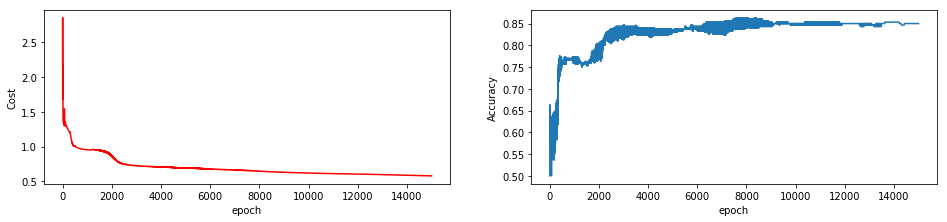

In [31]:
#### RUN this after training is done
#access the cost and accuracy during training by referencing the nnet object's attributes costs and accuracies
#This is done in the following way:
cost_training= nnet.costs
accuracy_training=nnet.accuracies
# Plots the cost and accuracy evolution during training 
fig = plt.figure(figsize=plt.figaspect(0.2))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(cost_training,'r')
plt.xlabel('epoch')
plt.ylabel('Cost')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(accuracy_training)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
A=np.array(accuracy_training)
best_epoch=np.argmax(A)
print('best_accuracy:',max(accuracy_training),'achieved at epoch:',best_epoch)

#### Visualize the posterior of the network trained above

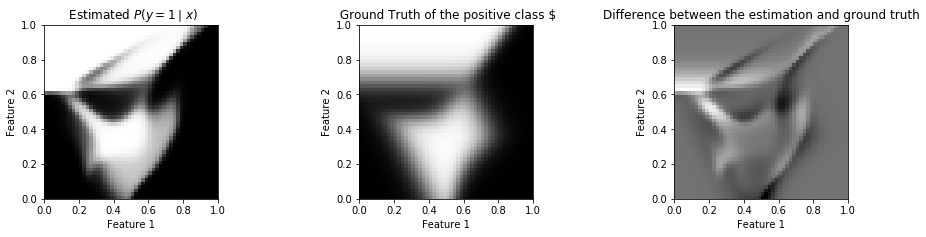

In [32]:
#### RUN this after training is done
x_rng = y_rng = np.linspace(0, 1, 50)
gridx,gridy = np.meshgrid(x_rng, y_rng)
p1=np.zeros((50,50))
p0=np.zeros((50,50))
for i in range(50):
    for j in range(50):
        v = np.array([gridx[i,j],gridy[i,j]])
        v=v[:,np.newaxis]
        out,dum,dum2=nnet.feedforward(v)
        p0[i,j]=out[0]
        p1[i,j]=out[1]

fig = plt.figure(figsize=plt.figaspect(0.2))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(p1, extent=[0, 1, 0, 1], origin='lower')
ax1.set_title(" Estimated $P(y=1 \mid x)$")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")

ax1 = fig.add_subplot(1, 3, 2)
ax1.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax1.set_title(" Ground Truth of the positive class $")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")

ax1 = fig.add_subplot(1, 3, 3)
ax1.imshow(p1-posterior, extent=[0, 1, 0, 1], origin='lower')
ax1.set_title("Difference between the estimation and ground truth")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
plt.show()  

<a id='Train2'></a>
#### Train a network with Relu non-linearities for the hidden layers and sigmoid non-linearity for the output layer
__ Use nnodes = [2 , 10 , 10 ,2]__

In [33]:
nnodes = [2, 10, 10, 2]
learning_rate = 0.2 
epochs = 15000
# Recommended to set the learning rate less than or equal to 0.2 
# use the previous network that was trained above as an example

activation_functions='relu' # use 'sigmoid' or 'relu'
nnet_2 = Neural_Network(nnodes,activation_functions)
stop = 260 #  number of correctly classified performance to which we wish to stop training / set it to a number close to 300
train_data = data
test_data = data #evaluate the performance on the train data
nnet_2.Gradient_Descent(train_data,epochs,learning_rate,stop,test_data)




Epoch 0: 137 / 300 Cost: [ 3.31624438]
Epoch 1: 159 / 300 Cost: [ 5.23059686]
Epoch 2: 168 / 300 Cost: [ 2.75172696]
Epoch 3: 181 / 300 Cost: [ 1.64530462]
Epoch 4: 160 / 300 Cost: [ 1.53540589]
Epoch 5: 184 / 300 Cost: [ 1.4843889]
Epoch 6: 168 / 300 Cost: [ 1.45272479]
Epoch 7: 186 / 300 Cost: [ 1.43496312]
Epoch 8: 168 / 300 Cost: [ 1.42103822]
Epoch 9: 194 / 300 Cost: [ 1.41528195]
Epoch 10: 176 / 300 Cost: [ 1.40145188]
Epoch 11: 196 / 300 Cost: [ 1.4007747]
Epoch 12: 185 / 300 Cost: [ 1.38129208]
Epoch 13: 198 / 300 Cost: [ 1.38037749]
Epoch 14: 190 / 300 Cost: [ 1.36058768]
Epoch 15: 199 / 300 Cost: [ 1.35803765]
Epoch 16: 195 / 300 Cost: [ 1.3387699]
Epoch 17: 201 / 300 Cost: [ 1.33287991]
Epoch 18: 201 / 300 Cost: [ 1.3163518]
Epoch 19: 199 / 300 Cost: [ 1.31113182]
Epoch 20: 204 / 300 Cost: [ 1.29837265]
Epoch 21: 199 / 300 Cost: [ 1.29403234]
Epoch 22: 210 / 300 Cost: [ 1.28202459]
Epoch 23: 199 / 300 Cost: [ 1.27682126]
Epoch 24: 212 / 300 Cost: [ 1.26644627]
Epoch 25: 200 

Epoch 204: 213 / 300 Cost: [ 1.02879574]
Epoch 205: 216 / 300 Cost: [ 1.06439471]
Epoch 206: 213 / 300 Cost: [ 1.03128855]
Epoch 207: 215 / 300 Cost: [ 1.06735966]
Epoch 208: 215 / 300 Cost: [ 1.02553889]
Epoch 209: 217 / 300 Cost: [ 1.06143343]
Epoch 210: 214 / 300 Cost: [ 1.02466467]
Epoch 211: 217 / 300 Cost: [ 1.05972904]
Epoch 212: 213 / 300 Cost: [ 1.02654595]
Epoch 213: 215 / 300 Cost: [ 1.06657459]
Epoch 214: 213 / 300 Cost: [ 1.02841602]
Epoch 215: 214 / 300 Cost: [ 1.06767215]
Epoch 216: 212 / 300 Cost: [ 1.03084708]
Epoch 217: 213 / 300 Cost: [ 1.07381026]
Epoch 218: 213 / 300 Cost: [ 1.02477564]
Epoch 219: 216 / 300 Cost: [ 1.05975922]
Epoch 220: 213 / 300 Cost: [ 1.02563176]
Epoch 221: 215 / 300 Cost: [ 1.06436647]
Epoch 222: 211 / 300 Cost: [ 1.02739551]
Epoch 223: 215 / 300 Cost: [ 1.06672683]
Epoch 224: 210 / 300 Cost: [ 1.031004]
Epoch 225: 214 / 300 Cost: [ 1.07353418]
Epoch 226: 212 / 300 Cost: [ 1.02650842]
Epoch 227: 215 / 300 Cost: [ 1.06597534]
Epoch 228: 211 / 3

Epoch 405: 215 / 300 Cost: [ 1.05635894]
Epoch 406: 223 / 300 Cost: [ 1.00074287]
Epoch 407: 215 / 300 Cost: [ 1.06324642]
Epoch 408: 223 / 300 Cost: [ 0.99965126]
Epoch 409: 214 / 300 Cost: [ 1.05925091]
Epoch 410: 223 / 300 Cost: [ 0.99911285]
Epoch 411: 214 / 300 Cost: [ 1.06205475]
Epoch 412: 223 / 300 Cost: [ 0.99909542]
Epoch 413: 215 / 300 Cost: [ 1.06141826]
Epoch 414: 223 / 300 Cost: [ 0.99863405]
Epoch 415: 214 / 300 Cost: [ 1.05877527]
Epoch 416: 224 / 300 Cost: [ 0.99529239]
Epoch 417: 215 / 300 Cost: [ 1.0537608]
Epoch 418: 223 / 300 Cost: [ 0.9997999]
Epoch 419: 214 / 300 Cost: [ 1.06617562]
Epoch 420: 223 / 300 Cost: [ 1.00182593]
Epoch 421: 214 / 300 Cost: [ 1.0700064]
Epoch 422: 222 / 300 Cost: [ 1.00484677]
Epoch 423: 214 / 300 Cost: [ 1.07122936]
Epoch 424: 222 / 300 Cost: [ 1.00328782]
Epoch 425: 215 / 300 Cost: [ 1.06860871]
Epoch 426: 222 / 300 Cost: [ 1.00177254]
Epoch 427: 214 / 300 Cost: [ 1.06397718]
Epoch 428: 223 / 300 Cost: [ 0.99937199]
Epoch 429: 214 / 30

Epoch 607: 219 / 300 Cost: [ 1.02194313]
Epoch 608: 227 / 300 Cost: [ 0.96497026]
Epoch 609: 219 / 300 Cost: [ 1.0209899]
Epoch 610: 226 / 300 Cost: [ 0.96964841]
Epoch 611: 219 / 300 Cost: [ 1.01817046]
Epoch 612: 227 / 300 Cost: [ 0.96222035]
Epoch 613: 220 / 300 Cost: [ 1.01695409]
Epoch 614: 227 / 300 Cost: [ 0.96641838]
Epoch 615: 219 / 300 Cost: [ 1.02256725]
Epoch 616: 226 / 300 Cost: [ 0.97002796]
Epoch 617: 219 / 300 Cost: [ 1.02754076]
Epoch 618: 226 / 300 Cost: [ 0.97089065]
Epoch 619: 219 / 300 Cost: [ 1.02757334]
Epoch 620: 225 / 300 Cost: [ 0.97059465]
Epoch 621: 219 / 300 Cost: [ 1.02698913]
Epoch 622: 227 / 300 Cost: [ 0.96876213]
Epoch 623: 219 / 300 Cost: [ 1.02412002]
Epoch 624: 227 / 300 Cost: [ 0.96701788]
Epoch 625: 219 / 300 Cost: [ 1.02107179]
Epoch 626: 227 / 300 Cost: [ 0.96569509]
Epoch 627: 220 / 300 Cost: [ 1.01821491]
Epoch 628: 229 / 300 Cost: [ 0.96395764]
Epoch 629: 220 / 300 Cost: [ 1.01547123]
Epoch 630: 229 / 300 Cost: [ 0.96223442]
Epoch 631: 220 / 

Epoch 815: 238 / 300 Cost: [ 0.87194342]
Epoch 816: 244 / 300 Cost: [ 0.86641796]
Epoch 817: 238 / 300 Cost: [ 0.87145968]
Epoch 818: 244 / 300 Cost: [ 0.86591069]
Epoch 819: 239 / 300 Cost: [ 0.87026961]
Epoch 820: 244 / 300 Cost: [ 0.86853266]
Epoch 821: 236 / 300 Cost: [ 0.87772086]
Epoch 822: 243 / 300 Cost: [ 0.8742861]
Epoch 823: 234 / 300 Cost: [ 0.88589908]
Epoch 824: 242 / 300 Cost: [ 0.88042912]
Epoch 825: 232 / 300 Cost: [ 0.89460058]
Epoch 826: 243 / 300 Cost: [ 0.88810062]
Epoch 827: 233 / 300 Cost: [ 0.90896846]
Epoch 828: 242 / 300 Cost: [ 0.89695217]
Epoch 829: 229 / 300 Cost: [ 0.92921988]
Epoch 830: 234 / 300 Cost: [ 0.91789404]
Epoch 831: 226 / 300 Cost: [ 0.96809966]
Epoch 832: 230 / 300 Cost: [ 0.94030761]
Epoch 833: 222 / 300 Cost: [ 1.00725213]
Epoch 834: 229 / 300 Cost: [ 0.96209911]
Epoch 835: 219 / 300 Cost: [ 1.03812444]
Epoch 836: 226 / 300 Cost: [ 0.98562352]
Epoch 837: 216 / 300 Cost: [ 1.0599699]
Epoch 838: 228 / 300 Cost: [ 0.96212881]
Epoch 839: 219 / 3

Epoch 1021: 232 / 300 Cost: [ 0.90073253]
Epoch 1022: 243 / 300 Cost: [ 0.87479777]
Epoch 1023: 232 / 300 Cost: [ 0.89667666]
Epoch 1024: 244 / 300 Cost: [ 0.88166684]
Epoch 1025: 232 / 300 Cost: [ 0.89825309]
Epoch 1026: 243 / 300 Cost: [ 0.86951197]
Epoch 1027: 233 / 300 Cost: [ 0.8950786]
Epoch 1028: 244 / 300 Cost: [ 0.88649442]
Epoch 1029: 231 / 300 Cost: [ 0.90506762]
Epoch 1030: 243 / 300 Cost: [ 0.87530176]
Epoch 1031: 232 / 300 Cost: [ 0.89808156]
Epoch 1032: 244 / 300 Cost: [ 0.88468086]
Epoch 1033: 231 / 300 Cost: [ 0.90270936]
Epoch 1034: 243 / 300 Cost: [ 0.87572037]
Epoch 1035: 232 / 300 Cost: [ 0.88539705]
Epoch 1036: 242 / 300 Cost: [ 0.86443222]
Epoch 1037: 233 / 300 Cost: [ 0.88646621]
Epoch 1038: 244 / 300 Cost: [ 0.88111281]
Epoch 1039: 232 / 300 Cost: [ 0.89904011]
Epoch 1040: 243 / 300 Cost: [ 0.87598319]
Epoch 1041: 233 / 300 Cost: [ 0.89014223]
Epoch 1042: 243 / 300 Cost: [ 0.86402124]
Epoch 1043: 233 / 300 Cost: [ 0.8866386]
Epoch 1044: 244 / 300 Cost: [ 0.8794

Epoch 1220: 244 / 300 Cost: [ 0.87110965]
Epoch 1221: 233 / 300 Cost: [ 0.88732133]
Epoch 1222: 243 / 300 Cost: [ 0.87941033]
Epoch 1223: 233 / 300 Cost: [ 0.89709721]
Epoch 1224: 243 / 300 Cost: [ 0.87260393]
Epoch 1225: 233 / 300 Cost: [ 0.88849849]
Epoch 1226: 243 / 300 Cost: [ 0.87994761]
Epoch 1227: 234 / 300 Cost: [ 0.89584968]
Epoch 1228: 243 / 300 Cost: [ 0.87103075]
Epoch 1229: 233 / 300 Cost: [ 0.88490423]
Epoch 1230: 244 / 300 Cost: [ 0.86892406]
Epoch 1231: 231 / 300 Cost: [ 0.8889919]
Epoch 1232: 244 / 300 Cost: [ 0.88133736]
Epoch 1233: 234 / 300 Cost: [ 0.89184913]
Epoch 1234: 243 / 300 Cost: [ 0.8617945]
Epoch 1235: 235 / 300 Cost: [ 0.87139588]
Epoch 1236: 243 / 300 Cost: [ 0.85384954]
Epoch 1237: 237 / 300 Cost: [ 0.86346472]
Epoch 1238: 242 / 300 Cost: [ 0.84675349]
Epoch 1239: 238 / 300 Cost: [ 0.85476807]
Epoch 1240: 245 / 300 Cost: [ 0.83971319]
Epoch 1241: 242 / 300 Cost: [ 0.84938982]
Epoch 1242: 244 / 300 Cost: [ 0.8352704]
Epoch 1243: 243 / 300 Cost: [ 0.84179

Epoch 1419: 247 / 300 Cost: [ 0.82562494]
Epoch 1420: 244 / 300 Cost: [ 0.83287439]
Epoch 1421: 242 / 300 Cost: [ 0.85379772]
Epoch 1422: 242 / 300 Cost: [ 0.87654945]
Epoch 1423: 234 / 300 Cost: [ 0.94900341]
Epoch 1424: 237 / 300 Cost: [ 0.9791063]
Epoch 1425: 226 / 300 Cost: [ 1.11112282]
Epoch 1426: 239 / 300 Cost: [ 1.02045521]
Epoch 1427: 223 / 300 Cost: [ 1.11206052]
Epoch 1428: 231 / 300 Cost: [ 0.99757333]
Epoch 1429: 224 / 300 Cost: [ 1.05301989]
Epoch 1430: 239 / 300 Cost: [ 0.93271421]
Epoch 1431: 228 / 300 Cost: [ 0.95923708]
Epoch 1432: 243 / 300 Cost: [ 0.89437503]
Epoch 1433: 233 / 300 Cost: [ 0.89291279]
Epoch 1434: 241 / 300 Cost: [ 0.85787735]
Epoch 1435: 239 / 300 Cost: [ 0.86592086]
Epoch 1436: 242 / 300 Cost: [ 0.84924554]
Epoch 1437: 242 / 300 Cost: [ 0.8519564]
Epoch 1438: 245 / 300 Cost: [ 0.83588135]
Epoch 1439: 245 / 300 Cost: [ 0.83345542]
Epoch 1440: 245 / 300 Cost: [ 0.82788295]
Epoch 1441: 248 / 300 Cost: [ 0.82613387]
Epoch 1442: 247 / 300 Cost: [ 0.8218

Epoch 1620: 245 / 300 Cost: [ 0.80300127]
Epoch 1621: 246 / 300 Cost: [ 0.80287154]
Epoch 1622: 244 / 300 Cost: [ 0.80391581]
Epoch 1623: 247 / 300 Cost: [ 0.80006808]
Epoch 1624: 246 / 300 Cost: [ 0.80034371]
Epoch 1625: 247 / 300 Cost: [ 0.79994852]
Epoch 1626: 245 / 300 Cost: [ 0.80021965]
Epoch 1627: 247 / 300 Cost: [ 0.799411]
Epoch 1628: 245 / 300 Cost: [ 0.79967]
Epoch 1629: 247 / 300 Cost: [ 0.79903262]
Epoch 1630: 245 / 300 Cost: [ 0.79915252]
Epoch 1631: 247 / 300 Cost: [ 0.79910729]
Epoch 1632: 245 / 300 Cost: [ 0.79916598]
Epoch 1633: 246 / 300 Cost: [ 0.79991799]
Epoch 1634: 245 / 300 Cost: [ 0.80004154]
Epoch 1635: 246 / 300 Cost: [ 0.80023284]
Epoch 1636: 245 / 300 Cost: [ 0.8003452]
Epoch 1637: 246 / 300 Cost: [ 0.8007554]
Epoch 1638: 244 / 300 Cost: [ 0.80199574]
Epoch 1639: 246 / 300 Cost: [ 0.8028805]
Epoch 1640: 241 / 300 Cost: [ 0.80431663]
Epoch 1641: 246 / 300 Cost: [ 0.80059297]
Epoch 1642: 244 / 300 Cost: [ 0.80190664]
Epoch 1643: 246 / 300 Cost: [ 0.80208703]


Epoch 1828: 245 / 300 Cost: [ 0.80744174]
Epoch 1829: 248 / 300 Cost: [ 0.80523762]
Epoch 1830: 244 / 300 Cost: [ 0.80988425]
Epoch 1831: 248 / 300 Cost: [ 0.80828285]
Epoch 1832: 245 / 300 Cost: [ 0.80841066]
Epoch 1833: 245 / 300 Cost: [ 0.80548687]
Epoch 1834: 248 / 300 Cost: [ 0.80933108]
Epoch 1835: 243 / 300 Cost: [ 0.80766301]
Epoch 1836: 246 / 300 Cost: [ 0.81253304]
Epoch 1837: 245 / 300 Cost: [ 0.81331892]
Epoch 1838: 245 / 300 Cost: [ 0.81799162]
Epoch 1839: 245 / 300 Cost: [ 0.81874704]
Epoch 1840: 244 / 300 Cost: [ 0.82389331]
Epoch 1841: 244 / 300 Cost: [ 0.82351596]
Epoch 1842: 243 / 300 Cost: [ 0.82867832]
Epoch 1843: 242 / 300 Cost: [ 0.835854]
Epoch 1844: 244 / 300 Cost: [ 0.83644297]
Epoch 1845: 242 / 300 Cost: [ 0.84832064]
Epoch 1846: 241 / 300 Cost: [ 0.85777038]
Epoch 1847: 241 / 300 Cost: [ 0.87159552]
Epoch 1848: 238 / 300 Cost: [ 0.87341183]
Epoch 1849: 241 / 300 Cost: [ 0.86856528]
Epoch 1850: 242 / 300 Cost: [ 0.84090017]
Epoch 1851: 245 / 300 Cost: [ 0.8391

Epoch 2027: 243 / 300 Cost: [ 0.81928445]
Epoch 2028: 245 / 300 Cost: [ 0.82773069]
Epoch 2029: 242 / 300 Cost: [ 0.83565081]
Epoch 2030: 243 / 300 Cost: [ 0.84633476]
Epoch 2031: 238 / 300 Cost: [ 0.86633456]
Epoch 2032: 243 / 300 Cost: [ 0.86960339]
Epoch 2033: 240 / 300 Cost: [ 0.89629699]
Epoch 2034: 237 / 300 Cost: [ 0.88402391]
Epoch 2035: 240 / 300 Cost: [ 0.88232703]
Epoch 2036: 241 / 300 Cost: [ 0.86078435]
Epoch 2037: 241 / 300 Cost: [ 0.8451511]
Epoch 2038: 244 / 300 Cost: [ 0.82281216]
Epoch 2039: 245 / 300 Cost: [ 0.81976379]
Epoch 2040: 243 / 300 Cost: [ 0.81478774]
Epoch 2041: 245 / 300 Cost: [ 0.81172189]
Epoch 2042: 245 / 300 Cost: [ 0.80947625]
Epoch 2043: 244 / 300 Cost: [ 0.80736124]
Epoch 2044: 248 / 300 Cost: [ 0.80191153]
Epoch 2045: 247 / 300 Cost: [ 0.79893298]
Epoch 2046: 247 / 300 Cost: [ 0.79736873]
Epoch 2047: 245 / 300 Cost: [ 0.79653918]
Epoch 2048: 247 / 300 Cost: [ 0.79619915]
Epoch 2049: 244 / 300 Cost: [ 0.79564778]
Epoch 2050: 248 / 300 Cost: [ 0.795

Epoch 2227: 238 / 300 Cost: [ 0.86920656]
Epoch 2228: 244 / 300 Cost: [ 0.85965855]
Epoch 2229: 242 / 300 Cost: [ 0.86109194]
Epoch 2230: 244 / 300 Cost: [ 0.84984043]
Epoch 2231: 245 / 300 Cost: [ 0.84830504]
Epoch 2232: 245 / 300 Cost: [ 0.83881199]
Epoch 2233: 245 / 300 Cost: [ 0.83676353]
Epoch 2234: 243 / 300 Cost: [ 0.8304616]
Epoch 2235: 249 / 300 Cost: [ 0.82943972]
Epoch 2236: 244 / 300 Cost: [ 0.82712915]
Epoch 2237: 248 / 300 Cost: [ 0.831803]
Epoch 2238: 243 / 300 Cost: [ 0.83172792]
Epoch 2239: 244 / 300 Cost: [ 0.83997882]
Epoch 2240: 244 / 300 Cost: [ 0.83544642]
Epoch 2241: 244 / 300 Cost: [ 0.84110105]
Epoch 2242: 244 / 300 Cost: [ 0.83835668]
Epoch 2243: 245 / 300 Cost: [ 0.83684675]
Epoch 2244: 244 / 300 Cost: [ 0.83317688]
Epoch 2245: 246 / 300 Cost: [ 0.82896066]
Epoch 2246: 244 / 300 Cost: [ 0.82621586]
Epoch 2247: 247 / 300 Cost: [ 0.82317592]
Epoch 2248: 244 / 300 Cost: [ 0.81927678]
Epoch 2249: 247 / 300 Cost: [ 0.82123014]
Epoch 2250: 244 / 300 Cost: [ 0.82002

Epoch 2429: 245 / 300 Cost: [ 0.83516241]
Epoch 2430: 241 / 300 Cost: [ 0.82727063]
Epoch 2431: 245 / 300 Cost: [ 0.82801554]
Epoch 2432: 244 / 300 Cost: [ 0.82061017]
Epoch 2433: 245 / 300 Cost: [ 0.81974714]
Epoch 2434: 242 / 300 Cost: [ 0.81678614]
Epoch 2435: 246 / 300 Cost: [ 0.81823138]
Epoch 2436: 243 / 300 Cost: [ 0.81622556]
Epoch 2437: 246 / 300 Cost: [ 0.81701444]
Epoch 2438: 245 / 300 Cost: [ 0.8147793]
Epoch 2439: 247 / 300 Cost: [ 0.81572508]
Epoch 2440: 245 / 300 Cost: [ 0.81303052]
Epoch 2441: 248 / 300 Cost: [ 0.81350715]
Epoch 2442: 245 / 300 Cost: [ 0.80912539]
Epoch 2443: 245 / 300 Cost: [ 0.80454554]
Epoch 2444: 248 / 300 Cost: [ 0.80294832]
Epoch 2445: 245 / 300 Cost: [ 0.79944419]
Epoch 2446: 247 / 300 Cost: [ 0.79833572]
Epoch 2447: 245 / 300 Cost: [ 0.7981562]
Epoch 2448: 247 / 300 Cost: [ 0.79690659]
Epoch 2449: 244 / 300 Cost: [ 0.79722386]
Epoch 2450: 247 / 300 Cost: [ 0.79679455]
Epoch 2451: 244 / 300 Cost: [ 0.79764273]
Epoch 2452: 247 / 300 Cost: [ 0.7973

Epoch 2631: 246 / 300 Cost: [ 0.78533394]
Epoch 2632: 245 / 300 Cost: [ 0.78559039]
Epoch 2633: 246 / 300 Cost: [ 0.78547436]
Epoch 2634: 245 / 300 Cost: [ 0.78596549]
Epoch 2635: 248 / 300 Cost: [ 0.78638637]
Epoch 2636: 248 / 300 Cost: [ 0.78867421]
Epoch 2637: 246 / 300 Cost: [ 0.79004911]
Epoch 2638: 248 / 300 Cost: [ 0.793766]
Epoch 2639: 244 / 300 Cost: [ 0.79663562]
Epoch 2640: 247 / 300 Cost: [ 0.80385314]
Epoch 2641: 243 / 300 Cost: [ 0.80737948]
Epoch 2642: 245 / 300 Cost: [ 0.81304813]
Epoch 2643: 242 / 300 Cost: [ 0.82583403]
Epoch 2644: 246 / 300 Cost: [ 0.84548475]
Epoch 2645: 239 / 300 Cost: [ 0.8683031]
Epoch 2646: 240 / 300 Cost: [ 0.87747317]
Epoch 2647: 240 / 300 Cost: [ 0.90024475]
Epoch 2648: 238 / 300 Cost: [ 0.9011616]
Epoch 2649: 239 / 300 Cost: [ 0.89196127]
Epoch 2650: 240 / 300 Cost: [ 0.85654715]
Epoch 2651: 240 / 300 Cost: [ 0.85535033]
Epoch 2652: 242 / 300 Cost: [ 0.83854827]
Epoch 2653: 243 / 300 Cost: [ 0.83659895]
Epoch 2654: 245 / 300 Cost: [ 0.823293

Epoch 2829: 244 / 300 Cost: [ 0.81519473]
Epoch 2830: 248 / 300 Cost: [ 0.81025054]
Epoch 2831: 245 / 300 Cost: [ 0.80121353]
Epoch 2832: 251 / 300 Cost: [ 0.80226867]
Epoch 2833: 245 / 300 Cost: [ 0.80011658]
Epoch 2834: 249 / 300 Cost: [ 0.80232015]
Epoch 2835: 245 / 300 Cost: [ 0.80251819]
Epoch 2836: 246 / 300 Cost: [ 0.80450299]
Epoch 2837: 244 / 300 Cost: [ 0.8110652]
Epoch 2838: 247 / 300 Cost: [ 0.81972639]
Epoch 2839: 241 / 300 Cost: [ 0.83110495]
Epoch 2840: 245 / 300 Cost: [ 0.84131487]
Epoch 2841: 244 / 300 Cost: [ 0.85093051]
Epoch 2842: 243 / 300 Cost: [ 0.86631893]
Epoch 2843: 244 / 300 Cost: [ 0.8723484]
Epoch 2844: 241 / 300 Cost: [ 0.88523278]
Epoch 2845: 244 / 300 Cost: [ 0.87501743]
Epoch 2846: 241 / 300 Cost: [ 0.86726787]
Epoch 2847: 244 / 300 Cost: [ 0.83056379]
Epoch 2848: 245 / 300 Cost: [ 0.82588028]
Epoch 2849: 244 / 300 Cost: [ 0.81539661]
Epoch 2850: 245 / 300 Cost: [ 0.80973455]
Epoch 2851: 248 / 300 Cost: [ 0.80570253]
Epoch 2852: 246 / 300 Cost: [ 0.8039

Epoch 3025: 246 / 300 Cost: [ 0.78244755]
Epoch 3026: 245 / 300 Cost: [ 0.78229569]
Epoch 3027: 246 / 300 Cost: [ 0.78171536]
Epoch 3028: 245 / 300 Cost: [ 0.78147524]
Epoch 3029: 245 / 300 Cost: [ 0.78140448]
Epoch 3030: 246 / 300 Cost: [ 0.78122192]
Epoch 3031: 245 / 300 Cost: [ 0.7813383]
Epoch 3032: 245 / 300 Cost: [ 0.78090552]
Epoch 3033: 246 / 300 Cost: [ 0.78089678]
Epoch 3034: 245 / 300 Cost: [ 0.7807821]
Epoch 3035: 245 / 300 Cost: [ 0.78117735]
Epoch 3036: 246 / 300 Cost: [ 0.78068301]
Epoch 3037: 245 / 300 Cost: [ 0.7811885]
Epoch 3038: 245 / 300 Cost: [ 0.78069841]
Epoch 3039: 246 / 300 Cost: [ 0.78123892]
Epoch 3040: 244 / 300 Cost: [ 0.7807403]
Epoch 3041: 247 / 300 Cost: [ 0.78131189]
Epoch 3042: 245 / 300 Cost: [ 0.78080875]
Epoch 3043: 248 / 300 Cost: [ 0.78146494]
Epoch 3044: 246 / 300 Cost: [ 0.78095942]
Epoch 3045: 248 / 300 Cost: [ 0.78169704]
Epoch 3046: 246 / 300 Cost: [ 0.78121115]
Epoch 3047: 249 / 300 Cost: [ 0.78186395]
Epoch 3048: 246 / 300 Cost: [ 0.781485

Epoch 3223: 250 / 300 Cost: [ 0.79808657]
Epoch 3224: 243 / 300 Cost: [ 0.79416058]
Epoch 3225: 250 / 300 Cost: [ 0.79392511]
Epoch 3226: 243 / 300 Cost: [ 0.79109908]
Epoch 3227: 250 / 300 Cost: [ 0.79091289]
Epoch 3228: 243 / 300 Cost: [ 0.7875966]
Epoch 3229: 249 / 300 Cost: [ 0.78651724]
Epoch 3230: 243 / 300 Cost: [ 0.78573961]
Epoch 3231: 249 / 300 Cost: [ 0.78532517]
Epoch 3232: 244 / 300 Cost: [ 0.78529196]
Epoch 3233: 246 / 300 Cost: [ 0.7832783]
Epoch 3234: 245 / 300 Cost: [ 0.78331121]
Epoch 3235: 248 / 300 Cost: [ 0.78130472]
Epoch 3236: 246 / 300 Cost: [ 0.78113879]
Epoch 3237: 247 / 300 Cost: [ 0.78077584]
Epoch 3238: 246 / 300 Cost: [ 0.78143263]
Epoch 3239: 247 / 300 Cost: [ 0.78207116]
Epoch 3240: 248 / 300 Cost: [ 0.7822864]
Epoch 3241: 247 / 300 Cost: [ 0.78212361]
Epoch 3242: 247 / 300 Cost: [ 0.78172459]
Epoch 3243: 247 / 300 Cost: [ 0.78157131]
Epoch 3244: 247 / 300 Cost: [ 0.78156302]
Epoch 3245: 248 / 300 Cost: [ 0.78346896]
Epoch 3246: 246 / 300 Cost: [ 0.78392

Epoch 3422: 243 / 300 Cost: [ 0.80681304]
Epoch 3423: 247 / 300 Cost: [ 0.81628934]
Epoch 3424: 245 / 300 Cost: [ 0.83179877]
Epoch 3425: 243 / 300 Cost: [ 0.85315487]
Epoch 3426: 243 / 300 Cost: [ 0.8663944]
Epoch 3427: 240 / 300 Cost: [ 0.88073508]
Epoch 3428: 243 / 300 Cost: [ 0.87372921]
Epoch 3429: 241 / 300 Cost: [ 0.88289076]
Epoch 3430: 242 / 300 Cost: [ 0.86567737]
Epoch 3431: 243 / 300 Cost: [ 0.86349298]
Epoch 3432: 243 / 300 Cost: [ 0.83621679]
Epoch 3433: 245 / 300 Cost: [ 0.82991703]
Epoch 3434: 247 / 300 Cost: [ 0.81316943]
Epoch 3435: 245 / 300 Cost: [ 0.81092905]
Epoch 3436: 248 / 300 Cost: [ 0.80916996]
Epoch 3437: 244 / 300 Cost: [ 0.80623836]
Epoch 3438: 248 / 300 Cost: [ 0.80755912]
Epoch 3439: 244 / 300 Cost: [ 0.80460409]
Epoch 3440: 248 / 300 Cost: [ 0.80549837]
Epoch 3441: 246 / 300 Cost: [ 0.80407293]
Epoch 3442: 248 / 300 Cost: [ 0.80550318]
Epoch 3443: 246 / 300 Cost: [ 0.80478164]
Epoch 3444: 248 / 300 Cost: [ 0.80621238]
Epoch 3445: 246 / 300 Cost: [ 0.804

Epoch 3618: 246 / 300 Cost: [ 0.82059601]
Epoch 3619: 245 / 300 Cost: [ 0.82177945]
Epoch 3620: 245 / 300 Cost: [ 0.82112988]
Epoch 3621: 243 / 300 Cost: [ 0.82271773]
Epoch 3622: 245 / 300 Cost: [ 0.81882396]
Epoch 3623: 244 / 300 Cost: [ 0.81820852]
Epoch 3624: 246 / 300 Cost: [ 0.81675841]
Epoch 3625: 243 / 300 Cost: [ 0.81603443]
Epoch 3626: 245 / 300 Cost: [ 0.8135125]
Epoch 3627: 243 / 300 Cost: [ 0.81371367]
Epoch 3628: 248 / 300 Cost: [ 0.80967152]
Epoch 3629: 243 / 300 Cost: [ 0.80921453]
Epoch 3630: 248 / 300 Cost: [ 0.80439583]
Epoch 3631: 244 / 300 Cost: [ 0.80075722]
Epoch 3632: 248 / 300 Cost: [ 0.79869312]
Epoch 3633: 245 / 300 Cost: [ 0.79502721]
Epoch 3634: 248 / 300 Cost: [ 0.79366]
Epoch 3635: 246 / 300 Cost: [ 0.79112443]
Epoch 3636: 249 / 300 Cost: [ 0.78963575]
Epoch 3637: 246 / 300 Cost: [ 0.78866565]
Epoch 3638: 249 / 300 Cost: [ 0.78777038]
Epoch 3639: 246 / 300 Cost: [ 0.78719113]
Epoch 3640: 248 / 300 Cost: [ 0.78674562]
Epoch 3641: 245 / 300 Cost: [ 0.786561

Epoch 3823: 244 / 300 Cost: [ 0.78473271]
Epoch 3824: 249 / 300 Cost: [ 0.78589906]
Epoch 3825: 243 / 300 Cost: [ 0.7865485]
Epoch 3826: 248 / 300 Cost: [ 0.78553022]
Epoch 3827: 245 / 300 Cost: [ 0.78591601]
Epoch 3828: 248 / 300 Cost: [ 0.78711048]
Epoch 3829: 244 / 300 Cost: [ 0.78873902]
Epoch 3830: 248 / 300 Cost: [ 0.79194052]
Epoch 3831: 243 / 300 Cost: [ 0.7943824]
Epoch 3832: 248 / 300 Cost: [ 0.79527453]
Epoch 3833: 243 / 300 Cost: [ 0.79850045]
Epoch 3834: 248 / 300 Cost: [ 0.80152597]
Epoch 3835: 243 / 300 Cost: [ 0.80651315]
Epoch 3836: 248 / 300 Cost: [ 0.80978141]
Epoch 3837: 245 / 300 Cost: [ 0.81464509]
Epoch 3838: 246 / 300 Cost: [ 0.81888895]
Epoch 3839: 245 / 300 Cost: [ 0.82182928]
Epoch 3840: 246 / 300 Cost: [ 0.820043]
Epoch 3841: 245 / 300 Cost: [ 0.82361594]
Epoch 3842: 246 / 300 Cost: [ 0.82788186]
Epoch 3843: 244 / 300 Cost: [ 0.82972017]
Epoch 3844: 246 / 300 Cost: [ 0.82838649]
Epoch 3845: 243 / 300 Cost: [ 0.82812949]
Epoch 3846: 246 / 300 Cost: [ 0.822848

Epoch 4025: 249 / 300 Cost: [ 0.80267685]
Epoch 4026: 243 / 300 Cost: [ 0.80391589]
Epoch 4027: 250 / 300 Cost: [ 0.80309828]
Epoch 4028: 243 / 300 Cost: [ 0.80454948]
Epoch 4029: 249 / 300 Cost: [ 0.80386805]
Epoch 4030: 243 / 300 Cost: [ 0.80508291]
Epoch 4031: 250 / 300 Cost: [ 0.8037914]
Epoch 4032: 243 / 300 Cost: [ 0.80481056]
Epoch 4033: 250 / 300 Cost: [ 0.80355908]
Epoch 4034: 243 / 300 Cost: [ 0.80424129]
Epoch 4035: 249 / 300 Cost: [ 0.80263678]
Epoch 4036: 243 / 300 Cost: [ 0.80320035]
Epoch 4037: 249 / 300 Cost: [ 0.80179274]
Epoch 4038: 243 / 300 Cost: [ 0.80231224]
Epoch 4039: 249 / 300 Cost: [ 0.80111314]
Epoch 4040: 243 / 300 Cost: [ 0.80164061]
Epoch 4041: 249 / 300 Cost: [ 0.80060782]
Epoch 4042: 243 / 300 Cost: [ 0.80117565]
Epoch 4043: 249 / 300 Cost: [ 0.80028096]
Epoch 4044: 243 / 300 Cost: [ 0.80090942]
Epoch 4045: 249 / 300 Cost: [ 0.7990924]
Epoch 4046: 244 / 300 Cost: [ 0.79950129]
Epoch 4047: 246 / 300 Cost: [ 0.79824633]
Epoch 4048: 246 / 300 Cost: [ 0.7983

Epoch 4227: 249 / 300 Cost: [ 0.78522568]
Epoch 4228: 245 / 300 Cost: [ 0.78523463]
Epoch 4229: 249 / 300 Cost: [ 0.78612152]
Epoch 4230: 245 / 300 Cost: [ 0.78608518]
Epoch 4231: 249 / 300 Cost: [ 0.78700192]
Epoch 4232: 245 / 300 Cost: [ 0.78723553]
Epoch 4233: 249 / 300 Cost: [ 0.78828527]
Epoch 4234: 245 / 300 Cost: [ 0.78861338]
Epoch 4235: 249 / 300 Cost: [ 0.78976999]
Epoch 4236: 244 / 300 Cost: [ 0.79002429]
Epoch 4237: 249 / 300 Cost: [ 0.79125488]
Epoch 4238: 243 / 300 Cost: [ 0.79090801]
Epoch 4239: 249 / 300 Cost: [ 0.79227167]
Epoch 4240: 243 / 300 Cost: [ 0.79151493]
Epoch 4241: 251 / 300 Cost: [ 0.79319665]
Epoch 4242: 244 / 300 Cost: [ 0.79291159]
Epoch 4243: 251 / 300 Cost: [ 0.79492528]
Epoch 4244: 245 / 300 Cost: [ 0.79593998]
Epoch 4245: 251 / 300 Cost: [ 0.79605254]
Epoch 4246: 245 / 300 Cost: [ 0.79712641]
Epoch 4247: 249 / 300 Cost: [ 0.7991362]
Epoch 4248: 245 / 300 Cost: [ 0.79994521]
Epoch 4249: 249 / 300 Cost: [ 0.80402557]
Epoch 4250: 245 / 300 Cost: [ 0.804

Epoch 4430: 249 / 300 Cost: [ 0.782715]
Epoch 4431: 243 / 300 Cost: [ 0.78281515]
Epoch 4432: 249 / 300 Cost: [ 0.78325263]
Epoch 4433: 243 / 300 Cost: [ 0.78399327]
Epoch 4434: 249 / 300 Cost: [ 0.78447719]
Epoch 4435: 241 / 300 Cost: [ 0.78542136]
Epoch 4436: 249 / 300 Cost: [ 0.78607729]
Epoch 4437: 240 / 300 Cost: [ 0.78778504]
Epoch 4438: 250 / 300 Cost: [ 0.79294338]
Epoch 4439: 241 / 300 Cost: [ 0.7960542]
Epoch 4440: 247 / 300 Cost: [ 0.80410263]
Epoch 4441: 239 / 300 Cost: [ 0.81603582]
Epoch 4442: 247 / 300 Cost: [ 0.81404078]
Epoch 4443: 242 / 300 Cost: [ 0.8202687]
Epoch 4444: 243 / 300 Cost: [ 0.83089594]
Epoch 4445: 242 / 300 Cost: [ 0.85105942]
Epoch 4446: 241 / 300 Cost: [ 0.86264038]
Epoch 4447: 239 / 300 Cost: [ 0.89774167]
Epoch 4448: 241 / 300 Cost: [ 0.88320771]
Epoch 4449: 238 / 300 Cost: [ 0.90457588]
Epoch 4450: 241 / 300 Cost: [ 0.87765918]
Epoch 4451: 241 / 300 Cost: [ 0.88460501]
Epoch 4452: 243 / 300 Cost: [ 0.85038327]
Epoch 4453: 240 / 300 Cost: [ 0.851868

Epoch 4626: 242 / 300 Cost: [ 0.84033593]
Epoch 4627: 240 / 300 Cost: [ 0.86449772]
Epoch 4628: 241 / 300 Cost: [ 0.88096141]
Epoch 4629: 237 / 300 Cost: [ 0.92388043]
Epoch 4630: 238 / 300 Cost: [ 0.90125691]
Epoch 4631: 237 / 300 Cost: [ 0.92254015]
Epoch 4632: 240 / 300 Cost: [ 0.88815211]
Epoch 4633: 237 / 300 Cost: [ 0.89051439]
Epoch 4634: 243 / 300 Cost: [ 0.85315754]
Epoch 4635: 243 / 300 Cost: [ 0.84942628]
Epoch 4636: 245 / 300 Cost: [ 0.83270365]
Epoch 4637: 239 / 300 Cost: [ 0.83663959]
Epoch 4638: 246 / 300 Cost: [ 0.81775778]
Epoch 4639: 240 / 300 Cost: [ 0.8214062]
Epoch 4640: 246 / 300 Cost: [ 0.80668167]
Epoch 4641: 243 / 300 Cost: [ 0.80315029]
Epoch 4642: 248 / 300 Cost: [ 0.7970855]
Epoch 4643: 242 / 300 Cost: [ 0.79215738]
Epoch 4644: 250 / 300 Cost: [ 0.78796547]
Epoch 4645: 243 / 300 Cost: [ 0.78463613]
Epoch 4646: 250 / 300 Cost: [ 0.78230397]
Epoch 4647: 244 / 300 Cost: [ 0.78095479]
Epoch 4648: 247 / 300 Cost: [ 0.77849757]
Epoch 4649: 245 / 300 Cost: [ 0.7778

Epoch 4826: 246 / 300 Cost: [ 0.77552396]
Epoch 4827: 248 / 300 Cost: [ 0.77587895]
Epoch 4828: 246 / 300 Cost: [ 0.77494534]
Epoch 4829: 249 / 300 Cost: [ 0.77556633]
Epoch 4830: 246 / 300 Cost: [ 0.77551913]
Epoch 4831: 249 / 300 Cost: [ 0.7766407]
Epoch 4832: 246 / 300 Cost: [ 0.77601577]
Epoch 4833: 248 / 300 Cost: [ 0.77738688]
Epoch 4834: 245 / 300 Cost: [ 0.77783998]
Epoch 4835: 248 / 300 Cost: [ 0.77963077]
Epoch 4836: 245 / 300 Cost: [ 0.78093035]
Epoch 4837: 247 / 300 Cost: [ 0.78322922]
Epoch 4838: 245 / 300 Cost: [ 0.78518755]
Epoch 4839: 247 / 300 Cost: [ 0.79032815]
Epoch 4840: 246 / 300 Cost: [ 0.79602934]
Epoch 4841: 246 / 300 Cost: [ 0.80230326]
Epoch 4842: 247 / 300 Cost: [ 0.81365202]
Epoch 4843: 246 / 300 Cost: [ 0.82371063]
Epoch 4844: 241 / 300 Cost: [ 0.83840691]
Epoch 4845: 241 / 300 Cost: [ 0.84764901]
Epoch 4846: 241 / 300 Cost: [ 0.86883425]
Epoch 4847: 242 / 300 Cost: [ 0.8681475]
Epoch 4848: 238 / 300 Cost: [ 0.88484408]
Epoch 4849: 242 / 300 Cost: [ 0.8658

Epoch 5023: 248 / 300 Cost: [ 0.80370979]
Epoch 5024: 244 / 300 Cost: [ 0.79839575]
Epoch 5025: 248 / 300 Cost: [ 0.79034103]
Epoch 5026: 245 / 300 Cost: [ 0.78732925]
Epoch 5027: 249 / 300 Cost: [ 0.7823478]
Epoch 5028: 245 / 300 Cost: [ 0.78212023]
Epoch 5029: 248 / 300 Cost: [ 0.77787046]
Epoch 5030: 246 / 300 Cost: [ 0.7777033]
Epoch 5031: 247 / 300 Cost: [ 0.77678432]
Epoch 5032: 246 / 300 Cost: [ 0.77701259]
Epoch 5033: 247 / 300 Cost: [ 0.77678603]
Epoch 5034: 246 / 300 Cost: [ 0.77735248]
Epoch 5035: 249 / 300 Cost: [ 0.77680754]
Epoch 5036: 246 / 300 Cost: [ 0.77731326]
Epoch 5037: 249 / 300 Cost: [ 0.77527293]
Epoch 5038: 246 / 300 Cost: [ 0.77578816]
Epoch 5039: 249 / 300 Cost: [ 0.77434567]
Epoch 5040: 247 / 300 Cost: [ 0.77476648]
Epoch 5041: 249 / 300 Cost: [ 0.7738933]
Epoch 5042: 247 / 300 Cost: [ 0.77413938]
Epoch 5043: 249 / 300 Cost: [ 0.7737885]
Epoch 5044: 247 / 300 Cost: [ 0.77393756]
Epoch 5045: 249 / 300 Cost: [ 0.77339933]
Epoch 5046: 248 / 300 Cost: [ 0.773753

Epoch 5222: 249 / 300 Cost: [ 0.77205288]
Epoch 5223: 249 / 300 Cost: [ 0.77238835]
Epoch 5224: 247 / 300 Cost: [ 0.77198478]
Epoch 5225: 249 / 300 Cost: [ 0.77203461]
Epoch 5226: 248 / 300 Cost: [ 0.77230078]
Epoch 5227: 249 / 300 Cost: [ 0.77348826]
Epoch 5228: 247 / 300 Cost: [ 0.77420204]
Epoch 5229: 249 / 300 Cost: [ 0.77602925]
Epoch 5230: 245 / 300 Cost: [ 0.77720477]
Epoch 5231: 247 / 300 Cost: [ 0.77936012]
Epoch 5232: 244 / 300 Cost: [ 0.78123501]
Epoch 5233: 247 / 300 Cost: [ 0.78354849]
Epoch 5234: 244 / 300 Cost: [ 0.78702129]
Epoch 5235: 247 / 300 Cost: [ 0.79312348]
Epoch 5236: 247 / 300 Cost: [ 0.80348439]
Epoch 5237: 247 / 300 Cost: [ 0.81289958]
Epoch 5238: 246 / 300 Cost: [ 0.82675331]
Epoch 5239: 242 / 300 Cost: [ 0.83836568]
Epoch 5240: 241 / 300 Cost: [ 0.85690371]
Epoch 5241: 241 / 300 Cost: [ 0.86304174]
Epoch 5242: 239 / 300 Cost: [ 0.8816086]
Epoch 5243: 242 / 300 Cost: [ 0.87185264]
Epoch 5244: 237 / 300 Cost: [ 0.88952859]
Epoch 5245: 239 / 300 Cost: [ 0.869

Epoch 5421: 249 / 300 Cost: [ 0.77349721]
Epoch 5422: 247 / 300 Cost: [ 0.77350935]
Epoch 5423: 249 / 300 Cost: [ 0.77207158]
Epoch 5424: 247 / 300 Cost: [ 0.77222299]
Epoch 5425: 250 / 300 Cost: [ 0.77166171]
Epoch 5426: 249 / 300 Cost: [ 0.77166575]
Epoch 5427: 249 / 300 Cost: [ 0.77132038]
Epoch 5428: 249 / 300 Cost: [ 0.77090441]
Epoch 5429: 250 / 300 Cost: [ 0.77039222]
Epoch 5430: 249 / 300 Cost: [ 0.7706233]
Epoch 5431: 250 / 300 Cost: [ 0.77047022]
Epoch 5432: 248 / 300 Cost: [ 0.77114876]
Epoch 5433: 250 / 300 Cost: [ 0.7715659]
Epoch 5434: 247 / 300 Cost: [ 0.77295053]
Epoch 5435: 249 / 300 Cost: [ 0.77437495]
Epoch 5436: 246 / 300 Cost: [ 0.77541335]
Epoch 5437: 248 / 300 Cost: [ 0.77758053]
Epoch 5438: 244 / 300 Cost: [ 0.77936219]
Epoch 5439: 246 / 300 Cost: [ 0.78467744]
Epoch 5440: 246 / 300 Cost: [ 0.79034583]
Epoch 5441: 245 / 300 Cost: [ 0.79627404]
Epoch 5442: 246 / 300 Cost: [ 0.80630109]
Epoch 5443: 246 / 300 Cost: [ 0.81628051]
Epoch 5444: 241 / 300 Cost: [ 0.8354

Epoch 5627: 240 / 300 Cost: [ 0.85976551]
Epoch 5628: 238 / 300 Cost: [ 0.89266426]
Epoch 5629: 238 / 300 Cost: [ 0.87945798]
Epoch 5630: 236 / 300 Cost: [ 0.90080362]
Epoch 5631: 242 / 300 Cost: [ 0.87229876]
Epoch 5632: 237 / 300 Cost: [ 0.87700328]
Epoch 5633: 242 / 300 Cost: [ 0.85237535]
Epoch 5634: 243 / 300 Cost: [ 0.85541798]
Epoch 5635: 242 / 300 Cost: [ 0.84177513]
Epoch 5636: 244 / 300 Cost: [ 0.83452166]
Epoch 5637: 244 / 300 Cost: [ 0.81622831]
Epoch 5638: 244 / 300 Cost: [ 0.8094084]
Epoch 5639: 249 / 300 Cost: [ 0.79964519]
Epoch 5640: 245 / 300 Cost: [ 0.79536502]
Epoch 5641: 249 / 300 Cost: [ 0.78840417]
Epoch 5642: 245 / 300 Cost: [ 0.78530563]
Epoch 5643: 250 / 300 Cost: [ 0.78125262]
Epoch 5644: 245 / 300 Cost: [ 0.78135348]
Epoch 5645: 248 / 300 Cost: [ 0.77591544]
Epoch 5646: 246 / 300 Cost: [ 0.77630748]
Epoch 5647: 249 / 300 Cost: [ 0.77313468]
Epoch 5648: 246 / 300 Cost: [ 0.77324127]
Epoch 5649: 249 / 300 Cost: [ 0.77258503]
Epoch 5650: 246 / 300 Cost: [ 0.772

Epoch 5829: 247 / 300 Cost: [ 0.79254616]
Epoch 5830: 247 / 300 Cost: [ 0.79861387]
Epoch 5831: 247 / 300 Cost: [ 0.80165036]
Epoch 5832: 247 / 300 Cost: [ 0.81096923]
Epoch 5833: 246 / 300 Cost: [ 0.81611937]
Epoch 5834: 245 / 300 Cost: [ 0.82548943]
Epoch 5835: 244 / 300 Cost: [ 0.82654092]
Epoch 5836: 242 / 300 Cost: [ 0.83894266]
Epoch 5837: 242 / 300 Cost: [ 0.83350225]
Epoch 5838: 243 / 300 Cost: [ 0.83869293]
Epoch 5839: 242 / 300 Cost: [ 0.8312519]
Epoch 5840: 245 / 300 Cost: [ 0.83343617]
Epoch 5841: 244 / 300 Cost: [ 0.82609154]
Epoch 5842: 245 / 300 Cost: [ 0.82365859]
Epoch 5843: 244 / 300 Cost: [ 0.81802077]
Epoch 5844: 246 / 300 Cost: [ 0.8145635]
Epoch 5845: 246 / 300 Cost: [ 0.80887711]
Epoch 5846: 245 / 300 Cost: [ 0.80448362]
Epoch 5847: 248 / 300 Cost: [ 0.79831228]
Epoch 5848: 245 / 300 Cost: [ 0.79294631]
Epoch 5849: 250 / 300 Cost: [ 0.78713184]
Epoch 5850: 245 / 300 Cost: [ 0.78492382]
Epoch 5851: 250 / 300 Cost: [ 0.7800518]
Epoch 5852: 245 / 300 Cost: [ 0.77992

Epoch 6033: 249 / 300 Cost: [ 0.76926233]
Epoch 6034: 247 / 300 Cost: [ 0.7686024]
Epoch 6035: 251 / 300 Cost: [ 0.76927466]
Epoch 6036: 247 / 300 Cost: [ 0.76936155]
Epoch 6037: 249 / 300 Cost: [ 0.77072587]
Epoch 6038: 247 / 300 Cost: [ 0.77130252]
Epoch 6039: 249 / 300 Cost: [ 0.77333159]
Epoch 6040: 245 / 300 Cost: [ 0.77449211]
Epoch 6041: 248 / 300 Cost: [ 0.77690984]
Epoch 6042: 245 / 300 Cost: [ 0.77908331]
Epoch 6043: 247 / 300 Cost: [ 0.7855957]
Epoch 6044: 245 / 300 Cost: [ 0.7924405]
Epoch 6045: 248 / 300 Cost: [ 0.80018586]
Epoch 6046: 246 / 300 Cost: [ 0.81271828]
Epoch 6047: 247 / 300 Cost: [ 0.82360071]
Epoch 6048: 244 / 300 Cost: [ 0.83939258]
Epoch 6049: 242 / 300 Cost: [ 0.84809548]
Epoch 6050: 239 / 300 Cost: [ 0.86970926]
Epoch 6051: 240 / 300 Cost: [ 0.86891955]
Epoch 6052: 237 / 300 Cost: [ 0.89159064]
Epoch 6053: 238 / 300 Cost: [ 0.88414868]
Epoch 6054: 240 / 300 Cost: [ 0.90248804]
Epoch 6055: 240 / 300 Cost: [ 0.86525931]
Epoch 6056: 242 / 300 Cost: [ 0.87412

Epoch 6230: 247 / 300 Cost: [ 0.7699686]
Epoch 6231: 249 / 300 Cost: [ 0.76958949]
Epoch 6232: 248 / 300 Cost: [ 0.76919139]
Epoch 6233: 250 / 300 Cost: [ 0.76912081]
Epoch 6234: 248 / 300 Cost: [ 0.76901434]
Epoch 6235: 250 / 300 Cost: [ 0.76912772]
Epoch 6236: 248 / 300 Cost: [ 0.76881352]
Epoch 6237: 251 / 300 Cost: [ 0.76932318]
Epoch 6238: 247 / 300 Cost: [ 0.76883899]
Epoch 6239: 250 / 300 Cost: [ 0.76981717]
Epoch 6240: 247 / 300 Cost: [ 0.77004877]
Epoch 6241: 249 / 300 Cost: [ 0.77200876]
Epoch 6242: 246 / 300 Cost: [ 0.77285211]
Epoch 6243: 249 / 300 Cost: [ 0.77514475]
Epoch 6244: 245 / 300 Cost: [ 0.77677166]
Epoch 6245: 246 / 300 Cost: [ 0.78282873]
Epoch 6246: 245 / 300 Cost: [ 0.78800712]
Epoch 6247: 247 / 300 Cost: [ 0.79427628]
Epoch 6248: 247 / 300 Cost: [ 0.80637099]
Epoch 6249: 249 / 300 Cost: [ 0.81589486]
Epoch 6250: 244 / 300 Cost: [ 0.83108288]
Epoch 6251: 242 / 300 Cost: [ 0.84009684]
Epoch 6252: 240 / 300 Cost: [ 0.86033155]
Epoch 6253: 242 / 300 Cost: [ 0.860

Epoch 6428: 245 / 300 Cost: [ 0.77247331]
Epoch 6429: 249 / 300 Cost: [ 0.77088652]
Epoch 6430: 246 / 300 Cost: [ 0.77082753]
Epoch 6431: 249 / 300 Cost: [ 0.77075912]
Epoch 6432: 246 / 300 Cost: [ 0.77058836]
Epoch 6433: 251 / 300 Cost: [ 0.77067838]
Epoch 6434: 247 / 300 Cost: [ 0.77164345]
Epoch 6435: 250 / 300 Cost: [ 0.7726]
Epoch 6436: 245 / 300 Cost: [ 0.77358128]
Epoch 6437: 248 / 300 Cost: [ 0.77610259]
Epoch 6438: 244 / 300 Cost: [ 0.77807789]
Epoch 6439: 246 / 300 Cost: [ 0.77971742]
Epoch 6440: 245 / 300 Cost: [ 0.7825787]
Epoch 6441: 247 / 300 Cost: [ 0.78747738]
Epoch 6442: 246 / 300 Cost: [ 0.79360375]
Epoch 6443: 249 / 300 Cost: [ 0.79945846]
Epoch 6444: 246 / 300 Cost: [ 0.80801466]
Epoch 6445: 247 / 300 Cost: [ 0.8149232]
Epoch 6446: 245 / 300 Cost: [ 0.8240567]
Epoch 6447: 245 / 300 Cost: [ 0.82704596]
Epoch 6448: 244 / 300 Cost: [ 0.83609011]
Epoch 6449: 244 / 300 Cost: [ 0.83278293]
Epoch 6450: 244 / 300 Cost: [ 0.84151423]
Epoch 6451: 244 / 300 Cost: [ 0.83863125]

Epoch 6631: 248 / 300 Cost: [ 0.77515608]
Epoch 6632: 245 / 300 Cost: [ 0.77633206]
Epoch 6633: 247 / 300 Cost: [ 0.77792986]
Epoch 6634: 244 / 300 Cost: [ 0.77877305]
Epoch 6635: 246 / 300 Cost: [ 0.77939193]
Epoch 6636: 245 / 300 Cost: [ 0.7806531]
Epoch 6637: 249 / 300 Cost: [ 0.78459222]
Epoch 6638: 245 / 300 Cost: [ 0.78841434]
Epoch 6639: 250 / 300 Cost: [ 0.79459411]
Epoch 6640: 245 / 300 Cost: [ 0.80102589]
Epoch 6641: 247 / 300 Cost: [ 0.80849201]
Epoch 6642: 245 / 300 Cost: [ 0.815375]
Epoch 6643: 246 / 300 Cost: [ 0.82192185]
Epoch 6644: 244 / 300 Cost: [ 0.83452188]
Epoch 6645: 244 / 300 Cost: [ 0.83349847]
Epoch 6646: 243 / 300 Cost: [ 0.84051458]
Epoch 6647: 244 / 300 Cost: [ 0.83697589]
Epoch 6648: 245 / 300 Cost: [ 0.8405453]
Epoch 6649: 245 / 300 Cost: [ 0.83292593]
Epoch 6650: 245 / 300 Cost: [ 0.83058227]
Epoch 6651: 245 / 300 Cost: [ 0.82166255]
Epoch 6652: 245 / 300 Cost: [ 0.81704011]
Epoch 6653: 247 / 300 Cost: [ 0.80897287]
Epoch 6654: 243 / 300 Cost: [ 0.805087

Epoch 6830: 245 / 300 Cost: [ 0.77203055]
Epoch 6831: 250 / 300 Cost: [ 0.77320074]
Epoch 6832: 245 / 300 Cost: [ 0.77472432]
Epoch 6833: 249 / 300 Cost: [ 0.77535811]
Epoch 6834: 244 / 300 Cost: [ 0.77764097]
Epoch 6835: 247 / 300 Cost: [ 0.77937053]
Epoch 6836: 245 / 300 Cost: [ 0.7826372]
Epoch 6837: 248 / 300 Cost: [ 0.78771059]
Epoch 6838: 246 / 300 Cost: [ 0.79203702]
Epoch 6839: 248 / 300 Cost: [ 0.79749255]
Epoch 6840: 246 / 300 Cost: [ 0.80541609]
Epoch 6841: 249 / 300 Cost: [ 0.81118559]
Epoch 6842: 245 / 300 Cost: [ 0.81990315]
Epoch 6843: 247 / 300 Cost: [ 0.82270281]
Epoch 6844: 244 / 300 Cost: [ 0.83437233]
Epoch 6845: 245 / 300 Cost: [ 0.82932028]
Epoch 6846: 244 / 300 Cost: [ 0.83569215]
Epoch 6847: 246 / 300 Cost: [ 0.82669035]
Epoch 6848: 245 / 300 Cost: [ 0.82918876]
Epoch 6849: 246 / 300 Cost: [ 0.82351247]
Epoch 6850: 245 / 300 Cost: [ 0.82289859]
Epoch 6851: 245 / 300 Cost: [ 0.81714809]
Epoch 6852: 245 / 300 Cost: [ 0.81454038]
Epoch 6853: 249 / 300 Cost: [ 0.806

Epoch 7030: 245 / 300 Cost: [ 0.77897065]
Epoch 7031: 246 / 300 Cost: [ 0.77865732]
Epoch 7032: 245 / 300 Cost: [ 0.78040996]
Epoch 7033: 248 / 300 Cost: [ 0.78565222]
Epoch 7034: 246 / 300 Cost: [ 0.78919589]
Epoch 7035: 250 / 300 Cost: [ 0.7961572]
Epoch 7036: 246 / 300 Cost: [ 0.80383222]
Epoch 7037: 248 / 300 Cost: [ 0.81099947]
Epoch 7038: 244 / 300 Cost: [ 0.82023688]
Epoch 7039: 245 / 300 Cost: [ 0.82239426]
Epoch 7040: 244 / 300 Cost: [ 0.83469277]
Epoch 7041: 244 / 300 Cost: [ 0.83406123]
Epoch 7042: 243 / 300 Cost: [ 0.84178131]
Epoch 7043: 242 / 300 Cost: [ 0.83546723]
Epoch 7044: 244 / 300 Cost: [ 0.837764]
Epoch 7045: 244 / 300 Cost: [ 0.8276425]
Epoch 7046: 245 / 300 Cost: [ 0.82501062]
Epoch 7047: 247 / 300 Cost: [ 0.8156384]
Epoch 7048: 244 / 300 Cost: [ 0.81146409]
Epoch 7049: 249 / 300 Cost: [ 0.80193015]
Epoch 7050: 245 / 300 Cost: [ 0.79407223]
Epoch 7051: 249 / 300 Cost: [ 0.78583979]
Epoch 7052: 245 / 300 Cost: [ 0.78230185]
Epoch 7053: 250 / 300 Cost: [ 0.7785396

Epoch 7227: 248 / 300 Cost: [ 0.81411026]
Epoch 7228: 245 / 300 Cost: [ 0.82037016]
Epoch 7229: 247 / 300 Cost: [ 0.82092209]
Epoch 7230: 245 / 300 Cost: [ 0.83015824]
Epoch 7231: 246 / 300 Cost: [ 0.82739272]
Epoch 7232: 245 / 300 Cost: [ 0.83040753]
Epoch 7233: 245 / 300 Cost: [ 0.82509417]
Epoch 7234: 244 / 300 Cost: [ 0.83181358]
Epoch 7235: 245 / 300 Cost: [ 0.82610217]
Epoch 7236: 242 / 300 Cost: [ 0.8312423]
Epoch 7237: 245 / 300 Cost: [ 0.8271382]
Epoch 7238: 240 / 300 Cost: [ 0.83264255]
Epoch 7239: 246 / 300 Cost: [ 0.8291531]
Epoch 7240: 241 / 300 Cost: [ 0.83307322]
Epoch 7241: 247 / 300 Cost: [ 0.82459276]
Epoch 7242: 241 / 300 Cost: [ 0.82981287]
Epoch 7243: 246 / 300 Cost: [ 0.82671874]
Epoch 7244: 240 / 300 Cost: [ 0.83263943]
Epoch 7245: 247 / 300 Cost: [ 0.82016289]
Epoch 7246: 243 / 300 Cost: [ 0.82333324]
Epoch 7247: 246 / 300 Cost: [ 0.81554344]
Epoch 7248: 244 / 300 Cost: [ 0.81532643]
Epoch 7249: 247 / 300 Cost: [ 0.80804519]
Epoch 7250: 245 / 300 Cost: [ 0.80057

Epoch 7430: 246 / 300 Cost: [ 0.78838867]
Epoch 7431: 250 / 300 Cost: [ 0.79459438]
Epoch 7432: 248 / 300 Cost: [ 0.79911376]
Epoch 7433: 249 / 300 Cost: [ 0.80348882]
Epoch 7434: 245 / 300 Cost: [ 0.81274953]
Epoch 7435: 248 / 300 Cost: [ 0.8164274]
Epoch 7436: 244 / 300 Cost: [ 0.82515194]
Epoch 7437: 243 / 300 Cost: [ 0.82584966]
Epoch 7438: 244 / 300 Cost: [ 0.83356577]
Epoch 7439: 244 / 300 Cost: [ 0.83265102]
Epoch 7440: 244 / 300 Cost: [ 0.83543182]
Epoch 7441: 245 / 300 Cost: [ 0.82805576]
Epoch 7442: 245 / 300 Cost: [ 0.825591]
Epoch 7443: 247 / 300 Cost: [ 0.81751193]
Epoch 7444: 244 / 300 Cost: [ 0.81252686]
Epoch 7445: 248 / 300 Cost: [ 0.80285435]
Epoch 7446: 244 / 300 Cost: [ 0.79802965]
Epoch 7447: 248 / 300 Cost: [ 0.79231631]
Epoch 7448: 244 / 300 Cost: [ 0.78866142]
Epoch 7449: 250 / 300 Cost: [ 0.78283801]
Epoch 7450: 244 / 300 Cost: [ 0.7800004]
Epoch 7451: 250 / 300 Cost: [ 0.77660331]
Epoch 7452: 246 / 300 Cost: [ 0.77611804]
Epoch 7453: 250 / 300 Cost: [ 0.773018

Epoch 7632: 244 / 300 Cost: [ 0.78946219]
Epoch 7633: 250 / 300 Cost: [ 0.78326369]
Epoch 7634: 244 / 300 Cost: [ 0.78097347]
Epoch 7635: 250 / 300 Cost: [ 0.77720226]
Epoch 7636: 246 / 300 Cost: [ 0.77449543]
Epoch 7637: 250 / 300 Cost: [ 0.77091153]
Epoch 7638: 247 / 300 Cost: [ 0.76909853]
Epoch 7639: 250 / 300 Cost: [ 0.76824615]
Epoch 7640: 247 / 300 Cost: [ 0.76758308]
Epoch 7641: 251 / 300 Cost: [ 0.76774362]
Epoch 7642: 247 / 300 Cost: [ 0.76760961]
Epoch 7643: 251 / 300 Cost: [ 0.76798367]
Epoch 7644: 247 / 300 Cost: [ 0.76825277]
Epoch 7645: 251 / 300 Cost: [ 0.76847718]
Epoch 7646: 247 / 300 Cost: [ 0.76821832]
Epoch 7647: 249 / 300 Cost: [ 0.76911689]
Epoch 7648: 247 / 300 Cost: [ 0.76792134]
Epoch 7649: 250 / 300 Cost: [ 0.76814051]
Epoch 7650: 247 / 300 Cost: [ 0.7692483]
Epoch 7651: 250 / 300 Cost: [ 0.77224351]
Epoch 7652: 246 / 300 Cost: [ 0.77311622]
Epoch 7653: 249 / 300 Cost: [ 0.77597751]
Epoch 7654: 245 / 300 Cost: [ 0.77765222]
Epoch 7655: 247 / 300 Cost: [ 0.781

Epoch 7836: 246 / 300 Cost: [ 0.78201001]
Epoch 7837: 247 / 300 Cost: [ 0.78269787]
Epoch 7838: 246 / 300 Cost: [ 0.78258041]
Epoch 7839: 248 / 300 Cost: [ 0.78485695]
Epoch 7840: 247 / 300 Cost: [ 0.78554362]
Epoch 7841: 247 / 300 Cost: [ 0.78568242]
Epoch 7842: 247 / 300 Cost: [ 0.78600402]
Epoch 7843: 248 / 300 Cost: [ 0.78926855]
Epoch 7844: 247 / 300 Cost: [ 0.78997365]
Epoch 7845: 249 / 300 Cost: [ 0.79360775]
Epoch 7846: 249 / 300 Cost: [ 0.79476931]
Epoch 7847: 251 / 300 Cost: [ 0.79725381]
Epoch 7848: 249 / 300 Cost: [ 0.798264]
Epoch 7849: 251 / 300 Cost: [ 0.7993466]
Epoch 7850: 248 / 300 Cost: [ 0.8012622]
Epoch 7851: 251 / 300 Cost: [ 0.80193986]
Epoch 7852: 246 / 300 Cost: [ 0.80567162]
Epoch 7853: 249 / 300 Cost: [ 0.80549194]
Epoch 7854: 245 / 300 Cost: [ 0.80767085]
Epoch 7855: 249 / 300 Cost: [ 0.80704359]
Epoch 7856: 245 / 300 Cost: [ 0.81091736]
Epoch 7857: 247 / 300 Cost: [ 0.80922097]
Epoch 7858: 245 / 300 Cost: [ 0.8113923]
Epoch 7859: 248 / 300 Cost: [ 0.8082319

Epoch 8041: 250 / 300 Cost: [ 0.78360734]
Epoch 8042: 245 / 300 Cost: [ 0.78072191]
Epoch 8043: 250 / 300 Cost: [ 0.77691574]
Epoch 8044: 246 / 300 Cost: [ 0.77338953]
Epoch 8045: 251 / 300 Cost: [ 0.76989714]
Epoch 8046: 247 / 300 Cost: [ 0.76801138]
Epoch 8047: 250 / 300 Cost: [ 0.7667121]
Epoch 8048: 247 / 300 Cost: [ 0.76654499]
Epoch 8049: 251 / 300 Cost: [ 0.76697043]
Epoch 8050: 247 / 300 Cost: [ 0.76599134]
Epoch 8051: 250 / 300 Cost: [ 0.76624135]
Epoch 8052: 247 / 300 Cost: [ 0.76738614]
Epoch 8053: 251 / 300 Cost: [ 0.76757127]
Epoch 8054: 247 / 300 Cost: [ 0.76781971]
Epoch 8055: 250 / 300 Cost: [ 0.7704225]
Epoch 8056: 247 / 300 Cost: [ 0.77008617]
Epoch 8057: 250 / 300 Cost: [ 0.77302067]
Epoch 8058: 247 / 300 Cost: [ 0.77388412]
Epoch 8059: 249 / 300 Cost: [ 0.77636564]
Epoch 8060: 246 / 300 Cost: [ 0.77622331]
Epoch 8061: 248 / 300 Cost: [ 0.77810714]
Epoch 8062: 246 / 300 Cost: [ 0.77831908]
Epoch 8063: 247 / 300 Cost: [ 0.77988968]
Epoch 8064: 246 / 300 Cost: [ 0.7803

Epoch 8241: 249 / 300 Cost: [ 0.80661648]
Epoch 8242: 246 / 300 Cost: [ 0.80071042]
Epoch 8243: 249 / 300 Cost: [ 0.7912182]
Epoch 8244: 244 / 300 Cost: [ 0.78980639]
Epoch 8245: 250 / 300 Cost: [ 0.78283899]
Epoch 8246: 247 / 300 Cost: [ 0.77835806]
Epoch 8247: 250 / 300 Cost: [ 0.77495492]
Epoch 8248: 247 / 300 Cost: [ 0.77163632]
Epoch 8249: 249 / 300 Cost: [ 0.76939501]
Epoch 8250: 247 / 300 Cost: [ 0.76783874]
Epoch 8251: 250 / 300 Cost: [ 0.76701105]
Epoch 8252: 247 / 300 Cost: [ 0.76586195]
Epoch 8253: 250 / 300 Cost: [ 0.76656947]
Epoch 8254: 247 / 300 Cost: [ 0.76613499]
Epoch 8255: 250 / 300 Cost: [ 0.76721649]
Epoch 8256: 247 / 300 Cost: [ 0.76720834]
Epoch 8257: 250 / 300 Cost: [ 0.76918452]
Epoch 8258: 248 / 300 Cost: [ 0.76834029]
Epoch 8259: 250 / 300 Cost: [ 0.7684841]
Epoch 8260: 248 / 300 Cost: [ 0.76832665]
Epoch 8261: 251 / 300 Cost: [ 0.76998268]
Epoch 8262: 248 / 300 Cost: [ 0.76873395]
Epoch 8263: 250 / 300 Cost: [ 0.77014106]
Epoch 8264: 248 / 300 Cost: [ 0.7703

Epoch 8444: 248 / 300 Cost: [ 0.79994072]
Epoch 8445: 249 / 300 Cost: [ 0.80039119]
Epoch 8446: 247 / 300 Cost: [ 0.80109841]
Epoch 8447: 248 / 300 Cost: [ 0.79984996]
Epoch 8448: 248 / 300 Cost: [ 0.80031615]
Epoch 8449: 250 / 300 Cost: [ 0.79873177]
Epoch 8450: 248 / 300 Cost: [ 0.79783168]
Epoch 8451: 250 / 300 Cost: [ 0.7938389]
Epoch 8452: 249 / 300 Cost: [ 0.7921087]
Epoch 8453: 249 / 300 Cost: [ 0.78664275]
Epoch 8454: 246 / 300 Cost: [ 0.7840004]
Epoch 8455: 248 / 300 Cost: [ 0.77873748]
Epoch 8456: 247 / 300 Cost: [ 0.77689222]
Epoch 8457: 248 / 300 Cost: [ 0.77354971]
Epoch 8458: 248 / 300 Cost: [ 0.77233664]
Epoch 8459: 250 / 300 Cost: [ 0.7699023]
Epoch 8460: 248 / 300 Cost: [ 0.76898275]
Epoch 8461: 250 / 300 Cost: [ 0.76810424]
Epoch 8462: 248 / 300 Cost: [ 0.76813131]
Epoch 8463: 251 / 300 Cost: [ 0.76938525]
Epoch 8464: 248 / 300 Cost: [ 0.76834198]
Epoch 8465: 250 / 300 Cost: [ 0.76946876]
Epoch 8466: 248 / 300 Cost: [ 0.77005408]
Epoch 8467: 251 / 300 Cost: [ 0.771986

Epoch 8647: 248 / 300 Cost: [ 0.77935393]
Epoch 8648: 247 / 300 Cost: [ 0.78078016]
Epoch 8649: 248 / 300 Cost: [ 0.78661747]
Epoch 8650: 249 / 300 Cost: [ 0.78941569]
Epoch 8651: 249 / 300 Cost: [ 0.79407857]
Epoch 8652: 249 / 300 Cost: [ 0.79558662]
Epoch 8653: 249 / 300 Cost: [ 0.79782522]
Epoch 8654: 248 / 300 Cost: [ 0.79935359]
Epoch 8655: 249 / 300 Cost: [ 0.79941619]
Epoch 8656: 247 / 300 Cost: [ 0.79922343]
Epoch 8657: 249 / 300 Cost: [ 0.79819416]
Epoch 8658: 248 / 300 Cost: [ 0.80051553]
Epoch 8659: 245 / 300 Cost: [ 0.79751416]
Epoch 8660: 248 / 300 Cost: [ 0.79980896]
Epoch 8661: 247 / 300 Cost: [ 0.79369634]
Epoch 8662: 249 / 300 Cost: [ 0.79591511]
Epoch 8663: 247 / 300 Cost: [ 0.79102286]
Epoch 8664: 249 / 300 Cost: [ 0.79367244]
Epoch 8665: 248 / 300 Cost: [ 0.79053895]
Epoch 8666: 248 / 300 Cost: [ 0.78917033]
Epoch 8667: 247 / 300 Cost: [ 0.78386164]
Epoch 8668: 246 / 300 Cost: [ 0.78180692]
Epoch 8669: 249 / 300 Cost: [ 0.7777578]
Epoch 8670: 247 / 300 Cost: [ 0.776

Epoch 8845: 252 / 300 Cost: [ 0.76540308]
Epoch 8846: 247 / 300 Cost: [ 0.76474079]
Epoch 8847: 251 / 300 Cost: [ 0.76547043]
Epoch 8848: 247 / 300 Cost: [ 0.76547246]
Epoch 8849: 251 / 300 Cost: [ 0.76657098]
Epoch 8850: 248 / 300 Cost: [ 0.76575671]
Epoch 8851: 251 / 300 Cost: [ 0.7675285]
Epoch 8852: 248 / 300 Cost: [ 0.76746423]
Epoch 8853: 252 / 300 Cost: [ 0.76673075]
Epoch 8854: 248 / 300 Cost: [ 0.76629987]
Epoch 8855: 251 / 300 Cost: [ 0.76766132]
Epoch 8856: 248 / 300 Cost: [ 0.76665432]
Epoch 8857: 251 / 300 Cost: [ 0.76724824]
Epoch 8858: 248 / 300 Cost: [ 0.76783509]
Epoch 8859: 252 / 300 Cost: [ 0.76940293]
Epoch 8860: 248 / 300 Cost: [ 0.76878077]
Epoch 8861: 250 / 300 Cost: [ 0.77059049]
Epoch 8862: 248 / 300 Cost: [ 0.77038218]
Epoch 8863: 250 / 300 Cost: [ 0.77234499]
Epoch 8864: 247 / 300 Cost: [ 0.77258813]
Epoch 8865: 249 / 300 Cost: [ 0.77440623]
Epoch 8866: 247 / 300 Cost: [ 0.77509847]
Epoch 8867: 248 / 300 Cost: [ 0.77694332]
Epoch 8868: 247 / 300 Cost: [ 0.778

Epoch 9042: 249 / 300 Cost: [ 0.78475388]
Epoch 9043: 249 / 300 Cost: [ 0.78944943]
Epoch 9044: 249 / 300 Cost: [ 0.79165763]
Epoch 9045: 249 / 300 Cost: [ 0.79479099]
Epoch 9046: 248 / 300 Cost: [ 0.79608853]
Epoch 9047: 250 / 300 Cost: [ 0.79708429]
Epoch 9048: 248 / 300 Cost: [ 0.79916434]
Epoch 9049: 249 / 300 Cost: [ 0.79916732]
Epoch 9050: 248 / 300 Cost: [ 0.79986642]
Epoch 9051: 250 / 300 Cost: [ 0.7970329]
Epoch 9052: 248 / 300 Cost: [ 0.79631933]
Epoch 9053: 250 / 300 Cost: [ 0.79331592]
Epoch 9054: 248 / 300 Cost: [ 0.79187043]
Epoch 9055: 249 / 300 Cost: [ 0.78600681]
Epoch 9056: 248 / 300 Cost: [ 0.78438823]
Epoch 9057: 249 / 300 Cost: [ 0.77970884]
Epoch 9058: 247 / 300 Cost: [ 0.77775117]
Epoch 9059: 248 / 300 Cost: [ 0.77518618]
Epoch 9060: 247 / 300 Cost: [ 0.77363294]
Epoch 9061: 250 / 300 Cost: [ 0.77150723]
Epoch 9062: 248 / 300 Cost: [ 0.77086388]
Epoch 9063: 250 / 300 Cost: [ 0.77085292]
Epoch 9064: 249 / 300 Cost: [ 0.7696309]
Epoch 9065: 250 / 300 Cost: [ 0.7684

Epoch 9244: 248 / 300 Cost: [ 0.76966008]
Epoch 9245: 251 / 300 Cost: [ 0.77141632]
Epoch 9246: 248 / 300 Cost: [ 0.77160377]
Epoch 9247: 250 / 300 Cost: [ 0.77359703]
Epoch 9248: 247 / 300 Cost: [ 0.77438659]
Epoch 9249: 248 / 300 Cost: [ 0.77600399]
Epoch 9250: 247 / 300 Cost: [ 0.77730773]
Epoch 9251: 248 / 300 Cost: [ 0.78252029]
Epoch 9252: 250 / 300 Cost: [ 0.78462864]
Epoch 9253: 249 / 300 Cost: [ 0.79010722]
Epoch 9254: 249 / 300 Cost: [ 0.79376875]
Epoch 9255: 249 / 300 Cost: [ 0.79778403]
Epoch 9256: 247 / 300 Cost: [ 0.80281916]
Epoch 9257: 248 / 300 Cost: [ 0.80475554]
Epoch 9258: 245 / 300 Cost: [ 0.8150821]
Epoch 9259: 246 / 300 Cost: [ 0.81647633]
Epoch 9260: 244 / 300 Cost: [ 0.82790611]
Epoch 9261: 244 / 300 Cost: [ 0.82675217]
Epoch 9262: 242 / 300 Cost: [ 0.84160309]
Epoch 9263: 244 / 300 Cost: [ 0.83726767]
Epoch 9264: 241 / 300 Cost: [ 0.85648898]
Epoch 9265: 243 / 300 Cost: [ 0.85884739]
Epoch 9266: 241 / 300 Cost: [ 0.87390365]
Epoch 9267: 244 / 300 Cost: [ 0.849

Epoch 9643: 252 / 300 Cost: [ 0.76456321]
Epoch 9644: 249 / 300 Cost: [ 0.76471744]
Epoch 9645: 252 / 300 Cost: [ 0.7658444]
Epoch 9646: 248 / 300 Cost: [ 0.76638962]
Epoch 9647: 252 / 300 Cost: [ 0.76782949]
Epoch 9648: 248 / 300 Cost: [ 0.7672396]
Epoch 9649: 251 / 300 Cost: [ 0.76836735]
Epoch 9650: 248 / 300 Cost: [ 0.76975342]
Epoch 9651: 250 / 300 Cost: [ 0.77118374]
Epoch 9652: 248 / 300 Cost: [ 0.77151812]
Epoch 9653: 250 / 300 Cost: [ 0.77319963]
Epoch 9654: 247 / 300 Cost: [ 0.77415657]
Epoch 9655: 248 / 300 Cost: [ 0.77549148]
Epoch 9656: 247 / 300 Cost: [ 0.77700927]
Epoch 9657: 249 / 300 Cost: [ 0.78201368]
Epoch 9658: 250 / 300 Cost: [ 0.78441976]
Epoch 9659: 249 / 300 Cost: [ 0.790191]
Epoch 9660: 248 / 300 Cost: [ 0.79374708]
Epoch 9661: 249 / 300 Cost: [ 0.79779138]
Epoch 9662: 247 / 300 Cost: [ 0.8030627]
Epoch 9663: 248 / 300 Cost: [ 0.80499404]
Epoch 9664: 247 / 300 Cost: [ 0.80972857]
Epoch 9665: 248 / 300 Cost: [ 0.80950772]
Epoch 9666: 246 / 300 Cost: [ 0.8211275

Epoch 9845: 249 / 300 Cost: [ 0.7761361]
Epoch 9846: 247 / 300 Cost: [ 0.77626732]
Epoch 9847: 250 / 300 Cost: [ 0.77538822]
Epoch 9848: 247 / 300 Cost: [ 0.77551488]
Epoch 9849: 250 / 300 Cost: [ 0.77480242]
Epoch 9850: 247 / 300 Cost: [ 0.77669442]
Epoch 9851: 249 / 300 Cost: [ 0.77663904]
Epoch 9852: 247 / 300 Cost: [ 0.7773374]
Epoch 9853: 249 / 300 Cost: [ 0.77743796]
Epoch 9854: 248 / 300 Cost: [ 0.77829536]
Epoch 9855: 249 / 300 Cost: [ 0.77810697]
Epoch 9856: 248 / 300 Cost: [ 0.7790227]
Epoch 9857: 249 / 300 Cost: [ 0.77855396]
Epoch 9858: 248 / 300 Cost: [ 0.77945746]
Epoch 9859: 249 / 300 Cost: [ 0.77866207]
Epoch 9860: 248 / 300 Cost: [ 0.77936676]
Epoch 9861: 248 / 300 Cost: [ 0.7778039]
Epoch 9862: 248 / 300 Cost: [ 0.77838264]
Epoch 9863: 248 / 300 Cost: [ 0.77753261]
Epoch 9864: 247 / 300 Cost: [ 0.77814382]
Epoch 9865: 249 / 300 Cost: [ 0.77682284]
Epoch 9866: 247 / 300 Cost: [ 0.77736673]
Epoch 9867: 248 / 300 Cost: [ 0.7767521]
Epoch 9868: 247 / 300 Cost: [ 0.7773486

Epoch 10043: 250 / 300 Cost: [ 0.80005244]
Epoch 10044: 245 / 300 Cost: [ 0.80902564]
Epoch 10045: 248 / 300 Cost: [ 0.80799242]
Epoch 10046: 246 / 300 Cost: [ 0.81675638]
Epoch 10047: 246 / 300 Cost: [ 0.8190774]
Epoch 10048: 244 / 300 Cost: [ 0.82862085]
Epoch 10049: 245 / 300 Cost: [ 0.82966271]
Epoch 10050: 243 / 300 Cost: [ 0.84303263]
Epoch 10051: 245 / 300 Cost: [ 0.82476465]
Epoch 10052: 245 / 300 Cost: [ 0.82660756]
Epoch 10053: 246 / 300 Cost: [ 0.81943281]
Epoch 10054: 246 / 300 Cost: [ 0.81777564]
Epoch 10055: 248 / 300 Cost: [ 0.81043587]
Epoch 10056: 247 / 300 Cost: [ 0.80637646]
Epoch 10057: 247 / 300 Cost: [ 0.80171493]
Epoch 10058: 246 / 300 Cost: [ 0.8021112]
Epoch 10059: 249 / 300 Cost: [ 0.79396209]
Epoch 10060: 245 / 300 Cost: [ 0.79392423]
Epoch 10061: 250 / 300 Cost: [ 0.78641599]
Epoch 10062: 247 / 300 Cost: [ 0.78528314]
Epoch 10063: 250 / 300 Cost: [ 0.77941044]
Epoch 10064: 248 / 300 Cost: [ 0.77541804]
Epoch 10065: 249 / 300 Cost: [ 0.76990377]
Epoch 10066: 

Epoch 10241: 249 / 300 Cost: [ 0.77914714]
Epoch 10242: 250 / 300 Cost: [ 0.78109048]
Epoch 10243: 249 / 300 Cost: [ 0.77901388]
Epoch 10244: 250 / 300 Cost: [ 0.78088068]
Epoch 10245: 249 / 300 Cost: [ 0.77881172]
Epoch 10246: 250 / 300 Cost: [ 0.78066058]
Epoch 10247: 249 / 300 Cost: [ 0.7787823]
Epoch 10248: 250 / 300 Cost: [ 0.78062754]
Epoch 10249: 249 / 300 Cost: [ 0.77876139]
Epoch 10250: 250 / 300 Cost: [ 0.780628]
Epoch 10251: 249 / 300 Cost: [ 0.77932413]
Epoch 10252: 250 / 300 Cost: [ 0.78131747]
Epoch 10253: 249 / 300 Cost: [ 0.77929609]
Epoch 10254: 250 / 300 Cost: [ 0.78122]
Epoch 10255: 249 / 300 Cost: [ 0.77918311]
Epoch 10256: 250 / 300 Cost: [ 0.78109345]
Epoch 10257: 249 / 300 Cost: [ 0.77907444]
Epoch 10258: 250 / 300 Cost: [ 0.78099475]
Epoch 10259: 249 / 300 Cost: [ 0.77956534]
Epoch 10260: 250 / 300 Cost: [ 0.78160998]
Epoch 10261: 249 / 300 Cost: [ 0.77947472]
Epoch 10262: 250 / 300 Cost: [ 0.78144736]
Epoch 10263: 249 / 300 Cost: [ 0.77931485]
Epoch 10264: 250 

Epoch 10439: 241 / 300 Cost: [ 0.8891952]
Epoch 10440: 237 / 300 Cost: [ 0.91087879]
Epoch 10441: 242 / 300 Cost: [ 0.86509355]
Epoch 10442: 241 / 300 Cost: [ 0.8611695]
Epoch 10443: 243 / 300 Cost: [ 0.83711527]
Epoch 10444: 245 / 300 Cost: [ 0.82984775]
Epoch 10445: 248 / 300 Cost: [ 0.81561629]
Epoch 10446: 245 / 300 Cost: [ 0.81362963]
Epoch 10447: 248 / 300 Cost: [ 0.80657776]
Epoch 10448: 244 / 300 Cost: [ 0.80385976]
Epoch 10449: 250 / 300 Cost: [ 0.79330297]
Epoch 10450: 246 / 300 Cost: [ 0.79273969]
Epoch 10451: 252 / 300 Cost: [ 0.78430342]
Epoch 10452: 246 / 300 Cost: [ 0.78663755]
Epoch 10453: 251 / 300 Cost: [ 0.78199664]
Epoch 10454: 246 / 300 Cost: [ 0.78569099]
Epoch 10455: 251 / 300 Cost: [ 0.78028854]
Epoch 10456: 246 / 300 Cost: [ 0.78415927]
Epoch 10457: 251 / 300 Cost: [ 0.78005326]
Epoch 10458: 246 / 300 Cost: [ 0.78470482]
Epoch 10459: 252 / 300 Cost: [ 0.78143604]
Epoch 10460: 246 / 300 Cost: [ 0.78749695]
Epoch 10461: 251 / 300 Cost: [ 0.78577732]
Epoch 10462: 

Epoch 10635: 251 / 300 Cost: [ 0.79468485]
Epoch 10636: 245 / 300 Cost: [ 0.80130053]
Epoch 10637: 251 / 300 Cost: [ 0.79950943]
Epoch 10638: 245 / 300 Cost: [ 0.80547704]
Epoch 10639: 251 / 300 Cost: [ 0.80441883]
Epoch 10640: 245 / 300 Cost: [ 0.81219357]
Epoch 10641: 250 / 300 Cost: [ 0.80874071]
Epoch 10642: 245 / 300 Cost: [ 0.81595353]
Epoch 10643: 249 / 300 Cost: [ 0.81093557]
Epoch 10644: 245 / 300 Cost: [ 0.81642817]
Epoch 10645: 249 / 300 Cost: [ 0.81043498]
Epoch 10646: 245 / 300 Cost: [ 0.81475746]
Epoch 10647: 249 / 300 Cost: [ 0.80952196]
Epoch 10648: 245 / 300 Cost: [ 0.81157141]
Epoch 10649: 250 / 300 Cost: [ 0.80485658]
Epoch 10650: 245 / 300 Cost: [ 0.80733854]
Epoch 10651: 250 / 300 Cost: [ 0.79526219]
Epoch 10652: 246 / 300 Cost: [ 0.79740553]
Epoch 10653: 251 / 300 Cost: [ 0.78744152]
Epoch 10654: 248 / 300 Cost: [ 0.78995268]
Epoch 10655: 253 / 300 Cost: [ 0.78383361]
Epoch 10656: 247 / 300 Cost: [ 0.78705394]
Epoch 10657: 253 / 300 Cost: [ 0.78123876]
Epoch 10658

Epoch 10834: 246 / 300 Cost: [ 0.81646163]
Epoch 10835: 248 / 300 Cost: [ 0.81313547]
Epoch 10836: 247 / 300 Cost: [ 0.81900418]
Epoch 10837: 247 / 300 Cost: [ 0.81432338]
Epoch 10838: 246 / 300 Cost: [ 0.8164237]
Epoch 10839: 248 / 300 Cost: [ 0.81096999]
Epoch 10840: 246 / 300 Cost: [ 0.81210369]
Epoch 10841: 248 / 300 Cost: [ 0.80651421]
Epoch 10842: 246 / 300 Cost: [ 0.8067923]
Epoch 10843: 250 / 300 Cost: [ 0.79539271]
Epoch 10844: 246 / 300 Cost: [ 0.79772447]
Epoch 10845: 252 / 300 Cost: [ 0.78877444]
Epoch 10846: 246 / 300 Cost: [ 0.79134351]
Epoch 10847: 253 / 300 Cost: [ 0.78687121]
Epoch 10848: 247 / 300 Cost: [ 0.79096161]
Epoch 10849: 252 / 300 Cost: [ 0.78780484]
Epoch 10850: 246 / 300 Cost: [ 0.79332065]
Epoch 10851: 251 / 300 Cost: [ 0.79411896]
Epoch 10852: 246 / 300 Cost: [ 0.80043475]
Epoch 10853: 252 / 300 Cost: [ 0.79519366]
Epoch 10854: 246 / 300 Cost: [ 0.80207211]
Epoch 10855: 252 / 300 Cost: [ 0.79592078]
Epoch 10856: 246 / 300 Cost: [ 0.80308398]
Epoch 10857: 

Epoch 11030: 248 / 300 Cost: [ 0.79278965]
Epoch 11031: 250 / 300 Cost: [ 0.78735705]
Epoch 11032: 249 / 300 Cost: [ 0.79400262]
Epoch 11033: 251 / 300 Cost: [ 0.7938163]
Epoch 11034: 247 / 300 Cost: [ 0.80311549]
Epoch 11035: 250 / 300 Cost: [ 0.80386159]
Epoch 11036: 246 / 300 Cost: [ 0.81734537]
Epoch 11037: 245 / 300 Cost: [ 0.8155789]
Epoch 11038: 245 / 300 Cost: [ 0.82647206]
Epoch 11039: 244 / 300 Cost: [ 0.82144545]
Epoch 11040: 243 / 300 Cost: [ 0.8337264]
Epoch 11041: 243 / 300 Cost: [ 0.8287895]
Epoch 11042: 244 / 300 Cost: [ 0.83906088]
Epoch 11043: 243 / 300 Cost: [ 0.83074081]
Epoch 11044: 244 / 300 Cost: [ 0.83689811]
Epoch 11045: 244 / 300 Cost: [ 0.82525703]
Epoch 11046: 244 / 300 Cost: [ 0.82584583]
Epoch 11047: 249 / 300 Cost: [ 0.81623154]
Epoch 11048: 246 / 300 Cost: [ 0.81715121]
Epoch 11049: 248 / 300 Cost: [ 0.80899212]
Epoch 11050: 246 / 300 Cost: [ 0.80757839]
Epoch 11051: 250 / 300 Cost: [ 0.79476139]
Epoch 11052: 247 / 300 Cost: [ 0.79243291]
Epoch 11053: 25

Epoch 11226: 246 / 300 Cost: [ 0.80992429]
Epoch 11227: 249 / 300 Cost: [ 0.80950612]
Epoch 11228: 246 / 300 Cost: [ 0.81542236]
Epoch 11229: 249 / 300 Cost: [ 0.8114269]
Epoch 11230: 246 / 300 Cost: [ 0.8162199]
Epoch 11231: 248 / 300 Cost: [ 0.8123403]
Epoch 11232: 246 / 300 Cost: [ 0.81463135]
Epoch 11233: 248 / 300 Cost: [ 0.80987416]
Epoch 11234: 246 / 300 Cost: [ 0.81045284]
Epoch 11235: 248 / 300 Cost: [ 0.804721]
Epoch 11236: 246 / 300 Cost: [ 0.80441719]
Epoch 11237: 251 / 300 Cost: [ 0.79296392]
Epoch 11238: 246 / 300 Cost: [ 0.79515634]
Epoch 11239: 252 / 300 Cost: [ 0.78738076]
Epoch 11240: 246 / 300 Cost: [ 0.78963021]
Epoch 11241: 253 / 300 Cost: [ 0.78890961]
Epoch 11242: 246 / 300 Cost: [ 0.79255514]
Epoch 11243: 252 / 300 Cost: [ 0.79177419]
Epoch 11244: 246 / 300 Cost: [ 0.79638577]
Epoch 11245: 252 / 300 Cost: [ 0.79093016]
Epoch 11246: 246 / 300 Cost: [ 0.79596961]
Epoch 11247: 251 / 300 Cost: [ 0.78917561]
Epoch 11248: 246 / 300 Cost: [ 0.79371261]
Epoch 11249: 252

Epoch 11428: 249 / 300 Cost: [ 0.78368346]
Epoch 11429: 250 / 300 Cost: [ 0.78219025]
Epoch 11430: 249 / 300 Cost: [ 0.7857732]
Epoch 11431: 250 / 300 Cost: [ 0.78528576]
Epoch 11432: 248 / 300 Cost: [ 0.78917166]
Epoch 11433: 249 / 300 Cost: [ 0.7829951]
Epoch 11434: 248 / 300 Cost: [ 0.78632205]
Epoch 11435: 250 / 300 Cost: [ 0.78533385]
Epoch 11436: 248 / 300 Cost: [ 0.78907927]
Epoch 11437: 248 / 300 Cost: [ 0.78266389]
Epoch 11438: 248 / 300 Cost: [ 0.78833791]
Epoch 11439: 250 / 300 Cost: [ 0.78666872]
Epoch 11440: 248 / 300 Cost: [ 0.79085941]
Epoch 11441: 248 / 300 Cost: [ 0.78399044]
Epoch 11442: 248 / 300 Cost: [ 0.78748451]
Epoch 11443: 249 / 300 Cost: [ 0.7811451]
Epoch 11444: 248 / 300 Cost: [ 0.78650021]
Epoch 11445: 249 / 300 Cost: [ 0.78506102]
Epoch 11446: 248 / 300 Cost: [ 0.78953345]
Epoch 11447: 248 / 300 Cost: [ 0.78311221]
Epoch 11448: 248 / 300 Cost: [ 0.78691741]
Epoch 11449: 248 / 300 Cost: [ 0.780891]
Epoch 11450: 248 / 300 Cost: [ 0.78410909]
Epoch 11451: 250

Epoch 11623: 250 / 300 Cost: [ 0.78467307]
Epoch 11624: 250 / 300 Cost: [ 0.78871258]
Epoch 11625: 249 / 300 Cost: [ 0.78319716]
Epoch 11626: 249 / 300 Cost: [ 0.78657383]
Epoch 11627: 250 / 300 Cost: [ 0.78082227]
Epoch 11628: 249 / 300 Cost: [ 0.78364911]
Epoch 11629: 249 / 300 Cost: [ 0.78211437]
Epoch 11630: 249 / 300 Cost: [ 0.78585364]
Epoch 11631: 250 / 300 Cost: [ 0.78565565]
Epoch 11632: 250 / 300 Cost: [ 0.79189613]
Epoch 11633: 250 / 300 Cost: [ 0.78708691]
Epoch 11634: 250 / 300 Cost: [ 0.79289865]
Epoch 11635: 251 / 300 Cost: [ 0.78757925]
Epoch 11636: 249 / 300 Cost: [ 0.79308881]
Epoch 11637: 251 / 300 Cost: [ 0.78813633]
Epoch 11638: 249 / 300 Cost: [ 0.79329026]
Epoch 11639: 251 / 300 Cost: [ 0.79352334]
Epoch 11640: 246 / 300 Cost: [ 0.80428761]
Epoch 11641: 250 / 300 Cost: [ 0.80463902]
Epoch 11642: 246 / 300 Cost: [ 0.81894427]
Epoch 11643: 245 / 300 Cost: [ 0.81895166]
Epoch 11644: 244 / 300 Cost: [ 0.8326123]
Epoch 11645: 242 / 300 Cost: [ 0.83048243]
Epoch 11646:

Epoch 11814: 246 / 300 Cost: [ 0.82237004]
Epoch 11815: 247 / 300 Cost: [ 0.81376329]
Epoch 11816: 246 / 300 Cost: [ 0.81468246]
Epoch 11817: 248 / 300 Cost: [ 0.80954372]
Epoch 11818: 246 / 300 Cost: [ 0.80864049]
Epoch 11819: 250 / 300 Cost: [ 0.79694446]
Epoch 11820: 246 / 300 Cost: [ 0.79806089]
Epoch 11821: 252 / 300 Cost: [ 0.78950279]
Epoch 11822: 245 / 300 Cost: [ 0.79050422]
Epoch 11823: 252 / 300 Cost: [ 0.78855505]
Epoch 11824: 246 / 300 Cost: [ 0.79046451]
Epoch 11825: 252 / 300 Cost: [ 0.78621373]
Epoch 11826: 248 / 300 Cost: [ 0.78357395]
Epoch 11827: 251 / 300 Cost: [ 0.7777834]
Epoch 11828: 250 / 300 Cost: [ 0.77630993]
Epoch 11829: 251 / 300 Cost: [ 0.77164179]
Epoch 11830: 249 / 300 Cost: [ 0.77343091]
Epoch 11831: 252 / 300 Cost: [ 0.77024512]
Epoch 11832: 249 / 300 Cost: [ 0.77265029]
Epoch 11833: 251 / 300 Cost: [ 0.77039693]
Epoch 11834: 249 / 300 Cost: [ 0.77325465]
Epoch 11835: 251 / 300 Cost: [ 0.77222892]
Epoch 11836: 250 / 300 Cost: [ 0.7727695]
Epoch 11837: 

Epoch 12007: 250 / 300 Cost: [ 0.77960725]
Epoch 12008: 250 / 300 Cost: [ 0.78102397]
Epoch 12009: 250 / 300 Cost: [ 0.77656494]
Epoch 12010: 250 / 300 Cost: [ 0.77803675]
Epoch 12011: 251 / 300 Cost: [ 0.774424]
Epoch 12012: 250 / 300 Cost: [ 0.77611421]
Epoch 12013: 252 / 300 Cost: [ 0.7731431]
Epoch 12014: 249 / 300 Cost: [ 0.77794639]
Epoch 12015: 251 / 300 Cost: [ 0.77625521]
Epoch 12016: 251 / 300 Cost: [ 0.77868976]
Epoch 12017: 250 / 300 Cost: [ 0.77707351]
Epoch 12018: 250 / 300 Cost: [ 0.78016629]
Epoch 12019: 250 / 300 Cost: [ 0.77812844]
Epoch 12020: 250 / 300 Cost: [ 0.78144375]
Epoch 12021: 250 / 300 Cost: [ 0.77917372]
Epoch 12022: 250 / 300 Cost: [ 0.78263685]
Epoch 12023: 250 / 300 Cost: [ 0.78334655]
Epoch 12024: 250 / 300 Cost: [ 0.78806787]
Epoch 12025: 249 / 300 Cost: [ 0.78306031]
Epoch 12026: 249 / 300 Cost: [ 0.78648528]
Epoch 12027: 249 / 300 Cost: [ 0.78073922]
Epoch 12028: 248 / 300 Cost: [ 0.78614897]
Epoch 12029: 250 / 300 Cost: [ 0.78502531]
Epoch 12030: 2

Epoch 12205: 252 / 300 Cost: [ 0.77215192]
Epoch 12206: 249 / 300 Cost: [ 0.77483193]
Epoch 12207: 251 / 300 Cost: [ 0.7727143]
Epoch 12208: 249 / 300 Cost: [ 0.7761985]
Epoch 12209: 251 / 300 Cost: [ 0.77478464]
Epoch 12210: 249 / 300 Cost: [ 0.77598502]
Epoch 12211: 251 / 300 Cost: [ 0.77447732]
Epoch 12212: 249 / 300 Cost: [ 0.77872615]
Epoch 12213: 251 / 300 Cost: [ 0.77705992]
Epoch 12214: 250 / 300 Cost: [ 0.77900519]
Epoch 12215: 251 / 300 Cost: [ 0.77717138]
Epoch 12216: 250 / 300 Cost: [ 0.77963241]
Epoch 12217: 250 / 300 Cost: [ 0.77721333]
Epoch 12218: 248 / 300 Cost: [ 0.78232267]
Epoch 12219: 250 / 300 Cost: [ 0.78346747]
Epoch 12220: 249 / 300 Cost: [ 0.78667474]
Epoch 12221: 250 / 300 Cost: [ 0.7874074]
Epoch 12222: 250 / 300 Cost: [ 0.79075962]
Epoch 12223: 250 / 300 Cost: [ 0.78462523]
Epoch 12224: 250 / 300 Cost: [ 0.78706881]
Epoch 12225: 250 / 300 Cost: [ 0.78551793]
Epoch 12226: 250 / 300 Cost: [ 0.78786998]
Epoch 12227: 250 / 300 Cost: [ 0.78628896]
Epoch 12228: 2

Epoch 12406: 250 / 300 Cost: [ 0.77983383]
Epoch 12407: 250 / 300 Cost: [ 0.77762231]
Epoch 12408: 250 / 300 Cost: [ 0.78072359]
Epoch 12409: 250 / 300 Cost: [ 0.77837978]
Epoch 12410: 250 / 300 Cost: [ 0.78161156]
Epoch 12411: 249 / 300 Cost: [ 0.78237601]
Epoch 12412: 249 / 300 Cost: [ 0.78592795]
Epoch 12413: 250 / 300 Cost: [ 0.7864608]
Epoch 12414: 250 / 300 Cost: [ 0.79147292]
Epoch 12415: 250 / 300 Cost: [ 0.78551164]
Epoch 12416: 250 / 300 Cost: [ 0.79148957]
Epoch 12417: 247 / 300 Cost: [ 0.78403465]
Epoch 12418: 250 / 300 Cost: [ 0.78718285]
Epoch 12419: 249 / 300 Cost: [ 0.78063516]
Epoch 12420: 249 / 300 Cost: [ 0.78356464]
Epoch 12421: 249 / 300 Cost: [ 0.78267462]
Epoch 12422: 250 / 300 Cost: [ 0.78584848]
Epoch 12423: 250 / 300 Cost: [ 0.78533877]
Epoch 12424: 250 / 300 Cost: [ 0.78899196]
Epoch 12425: 250 / 300 Cost: [ 0.78847876]
Epoch 12426: 250 / 300 Cost: [ 0.79769612]
Epoch 12427: 250 / 300 Cost: [ 0.79110543]
Epoch 12428: 249 / 300 Cost: [ 0.79721461]
Epoch 12429:

Epoch 12601: 244 / 300 Cost: [ 0.8236912]
Epoch 12602: 242 / 300 Cost: [ 0.84284485]
Epoch 12603: 242 / 300 Cost: [ 0.83533807]
Epoch 12604: 242 / 300 Cost: [ 0.84868798]
Epoch 12605: 242 / 300 Cost: [ 0.83180921]
Epoch 12606: 243 / 300 Cost: [ 0.83805187]
Epoch 12607: 246 / 300 Cost: [ 0.82313243]
Epoch 12608: 244 / 300 Cost: [ 0.82559409]
Epoch 12609: 247 / 300 Cost: [ 0.81471453]
Epoch 12610: 246 / 300 Cost: [ 0.8132928]
Epoch 12611: 248 / 300 Cost: [ 0.80641407]
Epoch 12612: 246 / 300 Cost: [ 0.80898559]
Epoch 12613: 250 / 300 Cost: [ 0.79639435]
Epoch 12614: 247 / 300 Cost: [ 0.79739245]
Epoch 12615: 251 / 300 Cost: [ 0.78770988]
Epoch 12616: 246 / 300 Cost: [ 0.79052807]
Epoch 12617: 252 / 300 Cost: [ 0.78873417]
Epoch 12618: 247 / 300 Cost: [ 0.79219846]
Epoch 12619: 251 / 300 Cost: [ 0.78951704]
Epoch 12620: 247 / 300 Cost: [ 0.79332016]
Epoch 12621: 251 / 300 Cost: [ 0.78959712]
Epoch 12622: 247 / 300 Cost: [ 0.79335753]
Epoch 12623: 251 / 300 Cost: [ 0.79381004]
Epoch 12624: 

Epoch 12799: 251 / 300 Cost: [ 0.77500346]
Epoch 12800: 250 / 300 Cost: [ 0.77989326]
Epoch 12801: 250 / 300 Cost: [ 0.77786617]
Epoch 12802: 250 / 300 Cost: [ 0.78028774]
Epoch 12803: 250 / 300 Cost: [ 0.77830621]
Epoch 12804: 250 / 300 Cost: [ 0.7805913]
Epoch 12805: 250 / 300 Cost: [ 0.77796029]
Epoch 12806: 249 / 300 Cost: [ 0.78346934]
Epoch 12807: 250 / 300 Cost: [ 0.78508434]
Epoch 12808: 249 / 300 Cost: [ 0.78886068]
Epoch 12809: 249 / 300 Cost: [ 0.78366216]
Epoch 12810: 250 / 300 Cost: [ 0.7867045]
Epoch 12811: 250 / 300 Cost: [ 0.78064544]
Epoch 12812: 249 / 300 Cost: [ 0.78293858]
Epoch 12813: 249 / 300 Cost: [ 0.78159386]
Epoch 12814: 249 / 300 Cost: [ 0.7842478]
Epoch 12815: 250 / 300 Cost: [ 0.78408101]
Epoch 12816: 250 / 300 Cost: [ 0.78691357]
Epoch 12817: 250 / 300 Cost: [ 0.78660839]
Epoch 12818: 250 / 300 Cost: [ 0.78986168]
Epoch 12819: 250 / 300 Cost: [ 0.78913016]
Epoch 12820: 249 / 300 Cost: [ 0.79701823]
Epoch 12821: 250 / 300 Cost: [ 0.78990824]
Epoch 12822: 2

Epoch 12992: 242 / 300 Cost: [ 0.84569585]
Epoch 12993: 243 / 300 Cost: [ 0.83473846]
Epoch 12994: 242 / 300 Cost: [ 0.84591638]
Epoch 12995: 244 / 300 Cost: [ 0.82840148]
Epoch 12996: 244 / 300 Cost: [ 0.8361732]
Epoch 12997: 246 / 300 Cost: [ 0.8195646]
Epoch 12998: 246 / 300 Cost: [ 0.82451562]
Epoch 12999: 247 / 300 Cost: [ 0.81220646]
Epoch 13000: 246 / 300 Cost: [ 0.81646712]
Epoch 13001: 247 / 300 Cost: [ 0.80966938]
Epoch 13002: 246 / 300 Cost: [ 0.81346489]
Epoch 13003: 249 / 300 Cost: [ 0.80103727]
Epoch 13004: 246 / 300 Cost: [ 0.80319107]
Epoch 13005: 252 / 300 Cost: [ 0.79228178]
Epoch 13006: 248 / 300 Cost: [ 0.79646731]
Epoch 13007: 251 / 300 Cost: [ 0.78745453]
Epoch 13008: 248 / 300 Cost: [ 0.78874667]
Epoch 13009: 251 / 300 Cost: [ 0.78703213]
Epoch 13010: 248 / 300 Cost: [ 0.78608927]
Epoch 13011: 250 / 300 Cost: [ 0.78040165]
Epoch 13012: 249 / 300 Cost: [ 0.78100645]
Epoch 13013: 250 / 300 Cost: [ 0.77513101]
Epoch 13014: 249 / 300 Cost: [ 0.77718044]
Epoch 13015: 

Epoch 13376: 247 / 300 Cost: [ 0.79734058]
Epoch 13377: 251 / 300 Cost: [ 0.78759037]
Epoch 13378: 248 / 300 Cost: [ 0.79065999]
Epoch 13379: 251 / 300 Cost: [ 0.7877664]
Epoch 13380: 249 / 300 Cost: [ 0.78708541]
Epoch 13381: 250 / 300 Cost: [ 0.78077641]
Epoch 13382: 250 / 300 Cost: [ 0.78110923]
Epoch 13383: 250 / 300 Cost: [ 0.77459846]
Epoch 13384: 249 / 300 Cost: [ 0.77627458]
Epoch 13385: 250 / 300 Cost: [ 0.77235406]
Epoch 13386: 250 / 300 Cost: [ 0.7752345]
Epoch 13387: 250 / 300 Cost: [ 0.77251738]
Epoch 13388: 250 / 300 Cost: [ 0.77575221]
Epoch 13389: 250 / 300 Cost: [ 0.77560713]
Epoch 13390: 248 / 300 Cost: [ 0.78134691]
Epoch 13391: 250 / 300 Cost: [ 0.77850098]
Epoch 13392: 249 / 300 Cost: [ 0.7793348]
Epoch 13393: 250 / 300 Cost: [ 0.77568305]
Epoch 13394: 250 / 300 Cost: [ 0.7816456]
Epoch 13395: 250 / 300 Cost: [ 0.77828973]
Epoch 13396: 247 / 300 Cost: [ 0.78295071]
Epoch 13397: 250 / 300 Cost: [ 0.7839037]
Epoch 13398: 250 / 300 Cost: [ 0.78563545]
Epoch 13399: 250

Epoch 13575: 249 / 300 Cost: [ 0.78225217]
Epoch 13576: 250 / 300 Cost: [ 0.78609983]
Epoch 13577: 250 / 300 Cost: [ 0.7841398]
Epoch 13578: 251 / 300 Cost: [ 0.78839478]
Epoch 13579: 250 / 300 Cost: [ 0.78563458]
Epoch 13580: 250 / 300 Cost: [ 0.78763737]
Epoch 13581: 249 / 300 Cost: [ 0.78508415]
Epoch 13582: 251 / 300 Cost: [ 0.78879598]
Epoch 13583: 249 / 300 Cost: [ 0.78529926]
Epoch 13584: 251 / 300 Cost: [ 0.78920165]
Epoch 13585: 249 / 300 Cost: [ 0.78604894]
Epoch 13586: 250 / 300 Cost: [ 0.79014038]
Epoch 13587: 249 / 300 Cost: [ 0.78670491]
Epoch 13588: 250 / 300 Cost: [ 0.79075197]
Epoch 13589: 249 / 300 Cost: [ 0.78707226]
Epoch 13590: 250 / 300 Cost: [ 0.79099606]
Epoch 13591: 249 / 300 Cost: [ 0.78704719]
Epoch 13592: 250 / 300 Cost: [ 0.79039646]
Epoch 13593: 249 / 300 Cost: [ 0.78520925]
Epoch 13594: 251 / 300 Cost: [ 0.78840368]
Epoch 13595: 249 / 300 Cost: [ 0.78150069]
Epoch 13596: 251 / 300 Cost: [ 0.78419421]
Epoch 13597: 249 / 300 Cost: [ 0.77739715]
Epoch 13598:

Epoch 13767: 250 / 300 Cost: [ 0.77443673]
Epoch 13768: 248 / 300 Cost: [ 0.77887074]
Epoch 13769: 249 / 300 Cost: [ 0.7791272]
Epoch 13770: 250 / 300 Cost: [ 0.78397321]
Epoch 13771: 249 / 300 Cost: [ 0.78302804]
Epoch 13772: 250 / 300 Cost: [ 0.7860935]
Epoch 13773: 249 / 300 Cost: [ 0.78499722]
Epoch 13774: 251 / 300 Cost: [ 0.78986316]
Epoch 13775: 250 / 300 Cost: [ 0.78690876]
Epoch 13776: 251 / 300 Cost: [ 0.79183109]
Epoch 13777: 250 / 300 Cost: [ 0.7886387]
Epoch 13778: 248 / 300 Cost: [ 0.79602136]
Epoch 13779: 249 / 300 Cost: [ 0.78721795]
Epoch 13780: 248 / 300 Cost: [ 0.79375329]
Epoch 13781: 249 / 300 Cost: [ 0.78518903]
Epoch 13782: 251 / 300 Cost: [ 0.78864005]
Epoch 13783: 249 / 300 Cost: [ 0.77940572]
Epoch 13784: 249 / 300 Cost: [ 0.78023948]
Epoch 13785: 249 / 300 Cost: [ 0.7772693]
Epoch 13786: 251 / 300 Cost: [ 0.78029748]
Epoch 13787: 249 / 300 Cost: [ 0.77512655]
Epoch 13788: 248 / 300 Cost: [ 0.77956907]
Epoch 13789: 249 / 300 Cost: [ 0.77925415]
Epoch 13790: 24

Epoch 13970: 249 / 300 Cost: [ 0.78998521]
Epoch 13971: 249 / 300 Cost: [ 0.78245024]
Epoch 13972: 249 / 300 Cost: [ 0.78252157]
Epoch 13973: 250 / 300 Cost: [ 0.77542983]
Epoch 13974: 250 / 300 Cost: [ 0.77390448]
Epoch 13975: 250 / 300 Cost: [ 0.76790688]
Epoch 13976: 250 / 300 Cost: [ 0.76961178]
Epoch 13977: 250 / 300 Cost: [ 0.767587]
Epoch 13978: 250 / 300 Cost: [ 0.77175597]
Epoch 13979: 251 / 300 Cost: [ 0.77017513]
Epoch 13980: 250 / 300 Cost: [ 0.77515375]
Epoch 13981: 250 / 300 Cost: [ 0.77213649]
Epoch 13982: 249 / 300 Cost: [ 0.77623211]
Epoch 13983: 250 / 300 Cost: [ 0.77413535]
Epoch 13984: 249 / 300 Cost: [ 0.77791475]
Epoch 13985: 249 / 300 Cost: [ 0.7780522]
Epoch 13986: 249 / 300 Cost: [ 0.78435032]
Epoch 13987: 250 / 300 Cost: [ 0.78450345]
Epoch 13988: 251 / 300 Cost: [ 0.78749162]
Epoch 13989: 250 / 300 Cost: [ 0.78488371]
Epoch 13990: 251 / 300 Cost: [ 0.78880804]
Epoch 13991: 250 / 300 Cost: [ 0.78559754]
Epoch 13992: 250 / 300 Cost: [ 0.78712509]
Epoch 13993: 2

Epoch 14165: 249 / 300 Cost: [ 0.78173808]
Epoch 14166: 249 / 300 Cost: [ 0.78319161]
Epoch 14167: 249 / 300 Cost: [ 0.78093662]
Epoch 14168: 250 / 300 Cost: [ 0.78435199]
Epoch 14169: 249 / 300 Cost: [ 0.7809709]
Epoch 14170: 250 / 300 Cost: [ 0.78318834]
Epoch 14171: 249 / 300 Cost: [ 0.78035326]
Epoch 14172: 250 / 300 Cost: [ 0.78407637]
Epoch 14173: 249 / 300 Cost: [ 0.7808655]
Epoch 14174: 250 / 300 Cost: [ 0.78303956]
Epoch 14175: 249 / 300 Cost: [ 0.78024628]
Epoch 14176: 250 / 300 Cost: [ 0.78395546]
Epoch 14177: 249 / 300 Cost: [ 0.78076324]
Epoch 14178: 250 / 300 Cost: [ 0.78295507]
Epoch 14179: 249 / 300 Cost: [ 0.78044016]
Epoch 14180: 250 / 300 Cost: [ 0.78408173]
Epoch 14181: 249 / 300 Cost: [ 0.7807736]
Epoch 14182: 250 / 300 Cost: [ 0.78256848]
Epoch 14183: 249 / 300 Cost: [ 0.78018021]
Epoch 14184: 250 / 300 Cost: [ 0.78416784]
Epoch 14185: 249 / 300 Cost: [ 0.78086439]
Epoch 14186: 250 / 300 Cost: [ 0.78270842]
Epoch 14187: 249 / 300 Cost: [ 0.78028069]
Epoch 14188: 2

Epoch 14365: 248 / 300 Cost: [ 0.82264423]
Epoch 14366: 242 / 300 Cost: [ 0.83609819]
Epoch 14367: 248 / 300 Cost: [ 0.82921262]
Epoch 14368: 242 / 300 Cost: [ 0.83970814]
Epoch 14369: 248 / 300 Cost: [ 0.82635028]
Epoch 14370: 244 / 300 Cost: [ 0.83317532]
Epoch 14371: 247 / 300 Cost: [ 0.81956618]
Epoch 14372: 246 / 300 Cost: [ 0.82298252]
Epoch 14373: 247 / 300 Cost: [ 0.80962555]
Epoch 14374: 246 / 300 Cost: [ 0.81218966]
Epoch 14375: 250 / 300 Cost: [ 0.79996623]
Epoch 14376: 247 / 300 Cost: [ 0.80399111]
Epoch 14377: 251 / 300 Cost: [ 0.78829729]
Epoch 14378: 248 / 300 Cost: [ 0.78909156]
Epoch 14379: 251 / 300 Cost: [ 0.78466073]
Epoch 14380: 249 / 300 Cost: [ 0.78499641]
Epoch 14381: 249 / 300 Cost: [ 0.77773886]
Epoch 14382: 250 / 300 Cost: [ 0.77513997]
Epoch 14383: 250 / 300 Cost: [ 0.76857755]
Epoch 14384: 250 / 300 Cost: [ 0.77163006]
Epoch 14385: 250 / 300 Cost: [ 0.76705075]
Epoch 14386: 250 / 300 Cost: [ 0.76951132]
Epoch 14387: 251 / 300 Cost: [ 0.76807333]
Epoch 14388

Epoch 14560: 251 / 300 Cost: [ 0.78546814]
Epoch 14561: 249 / 300 Cost: [ 0.78109362]
Epoch 14562: 251 / 300 Cost: [ 0.78525932]
Epoch 14563: 249 / 300 Cost: [ 0.78154743]
Epoch 14564: 251 / 300 Cost: [ 0.78584608]
Epoch 14565: 249 / 300 Cost: [ 0.78197898]
Epoch 14566: 251 / 300 Cost: [ 0.78625283]
Epoch 14567: 249 / 300 Cost: [ 0.78177305]
Epoch 14568: 250 / 300 Cost: [ 0.78640144]
Epoch 14569: 249 / 300 Cost: [ 0.78218115]
Epoch 14570: 250 / 300 Cost: [ 0.78443555]
Epoch 14571: 249 / 300 Cost: [ 0.78059477]
Epoch 14572: 250 / 300 Cost: [ 0.78453037]
Epoch 14573: 249 / 300 Cost: [ 0.78021944]
Epoch 14574: 250 / 300 Cost: [ 0.78102355]
Epoch 14575: 249 / 300 Cost: [ 0.77777084]
Epoch 14576: 249 / 300 Cost: [ 0.7811088]
Epoch 14577: 249 / 300 Cost: [ 0.77491864]
Epoch 14578: 248 / 300 Cost: [ 0.77906871]
Epoch 14579: 249 / 300 Cost: [ 0.7777413]
Epoch 14580: 249 / 300 Cost: [ 0.78137743]
Epoch 14581: 249 / 300 Cost: [ 0.77828407]
Epoch 14582: 249 / 300 Cost: [ 0.77948785]
Epoch 14583: 

Epoch 14756: 248 / 300 Cost: [ 0.77164871]
Epoch 14757: 252 / 300 Cost: [ 0.7780533]
Epoch 14758: 249 / 300 Cost: [ 0.77708803]
Epoch 14759: 251 / 300 Cost: [ 0.78855696]
Epoch 14760: 247 / 300 Cost: [ 0.78559293]
Epoch 14761: 246 / 300 Cost: [ 0.80398476]
Epoch 14762: 250 / 300 Cost: [ 0.80960303]
Epoch 14763: 241 / 300 Cost: [ 0.84106722]
Epoch 14764: 242 / 300 Cost: [ 0.8492843]
Epoch 14765: 239 / 300 Cost: [ 0.89377677]
Epoch 14766: 241 / 300 Cost: [ 0.88829676]
Epoch 14767: 237 / 300 Cost: [ 0.92479192]
Epoch 14768: 241 / 300 Cost: [ 0.89628583]
Epoch 14769: 238 / 300 Cost: [ 0.9076111]
Epoch 14770: 244 / 300 Cost: [ 0.86221996]
Epoch 14771: 241 / 300 Cost: [ 0.85634409]
Epoch 14772: 246 / 300 Cost: [ 0.82705752]
Epoch 14773: 247 / 300 Cost: [ 0.82085455]
Epoch 14774: 248 / 300 Cost: [ 0.80366373]
Epoch 14775: 248 / 300 Cost: [ 0.8037158]
Epoch 14776: 249 / 300 Cost: [ 0.79298956]
Epoch 14777: 247 / 300 Cost: [ 0.79667547]
Epoch 14778: 251 / 300 Cost: [ 0.79524619]
Epoch 14779: 24

Epoch 14950: 250 / 300 Cost: [ 0.78268111]
Epoch 14951: 250 / 300 Cost: [ 0.78638228]
Epoch 14952: 249 / 300 Cost: [ 0.78198279]
Epoch 14953: 250 / 300 Cost: [ 0.78551239]
Epoch 14954: 249 / 300 Cost: [ 0.78170285]
Epoch 14955: 251 / 300 Cost: [ 0.78516816]
Epoch 14956: 249 / 300 Cost: [ 0.77828124]
Epoch 14957: 250 / 300 Cost: [ 0.7841762]
Epoch 14958: 250 / 300 Cost: [ 0.78156581]
Epoch 14959: 250 / 300 Cost: [ 0.7827675]
Epoch 14960: 249 / 300 Cost: [ 0.78021334]
Epoch 14961: 250 / 300 Cost: [ 0.78342715]
Epoch 14962: 249 / 300 Cost: [ 0.77725653]
Epoch 14963: 250 / 300 Cost: [ 0.78310094]
Epoch 14964: 250 / 300 Cost: [ 0.78086116]
Epoch 14965: 250 / 300 Cost: [ 0.78216277]
Epoch 14966: 249 / 300 Cost: [ 0.779874]
Epoch 14967: 250 / 300 Cost: [ 0.78320999]
Epoch 14968: 249 / 300 Cost: [ 0.78001631]
Epoch 14969: 249 / 300 Cost: [ 0.78332614]
Epoch 14970: 249 / 300 Cost: [ 0.77712319]
Epoch 14971: 250 / 300 Cost: [ 0.78301153]
Epoch 14972: 250 / 300 Cost: [ 0.78096863]
Epoch 14973: 25

best_accuracy: 0.8466666666666667 achieved at epoch: 10591


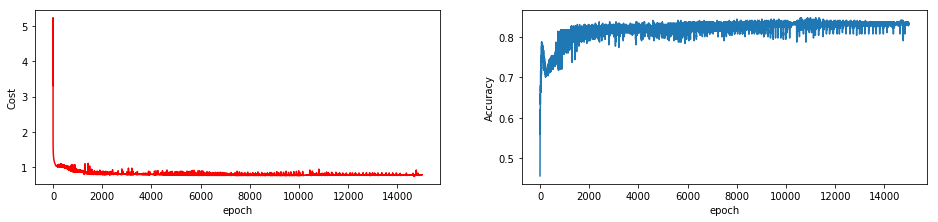

In [34]:
#### RUN this after training is done
#access the cost and accuracy during training by referencing the nnet object's attributes costs and accuracies
#This is done in the following way:
cost_training= nnet_2.costs
accuracy_training=nnet_2.accuracies
# Plots the cost and accuracy evolution during training 
fig = plt.figure(figsize=plt.figaspect(0.2))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(cost_training,'r')
plt.xlabel('epoch')
plt.ylabel('Cost')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(accuracy_training)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
A=np.array(accuracy_training)
best_epoch=np.argmax(A)
print('best_accuracy:',max(accuracy_training),'achieved at epoch:',best_epoch)

#### Visualize the posterior of the model trained above

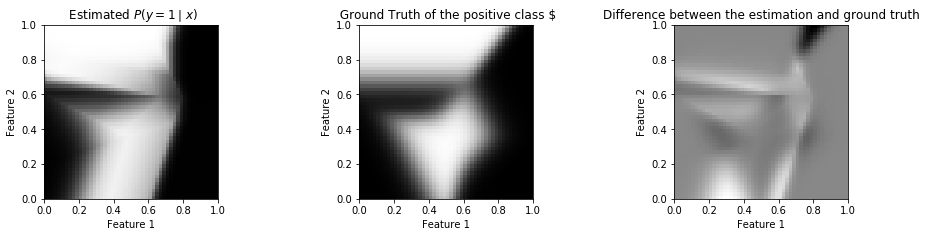

In [35]:
#### RUN this after training is done
x_rng = y_rng = np.linspace(0, 1, 50)
gridx,gridy = np.meshgrid(x_rng, y_rng)
p1=np.zeros((50,50))
p0=np.zeros((50,50))
for i in range(50):
    for j in range(50):
        v = np.array([gridx[i,j],gridy[i,j]])
        v=v[:,np.newaxis]
        out,dum1,dum2=nnet_2.feedforward(v)
        #print(out[0],out[1])
        p0[i,j]=out[0]
        p1[i,j]=out[1]
        #print(p0[i,j],p1[i,j])

fig = plt.figure(figsize=plt.figaspect(0.2))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(p1, extent=[0, 1, 0, 1], origin='lower')
ax1.set_title(" Estimated $P(y=1 \mid x)$")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")

ax1 = fig.add_subplot(1, 3, 2)
ax1.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax1.set_title(" Ground Truth of the positive class $")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")

ax1 = fig.add_subplot(1, 3, 3)
ax1.imshow(p1-posterior, extent=[0, 1, 0, 1], origin='lower')
ax1.set_title("Difference between the estimation and ground truth")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
plt.show()   